In this notebook the eQTLs and pQTLs indentified with statistical package MatrixEQTL are analysed with respect to the network of protein-protein interactions in yeast.

In [5]:
%matplotlib inline

# utilities
import gc
import time
import os

import collections
import itertools
from importlib import reload
import pickle

# data analysis tools
import joblib
import random
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
from statsmodels.sandbox.stats.multicomp import multipletests
from tqdm import *

tqdm.monitor_interval = 0

# network analysis tools
import igraph as ig

# multiprocessing tools
import subprocess
import multiprocessing as mp

os.chdir("{}/Science/eQTL_analysis/".format(os.environ["HOME"]))

# visualization tools
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import networks
import qtls
import util
import ontologies

gc.enable()

%autosave 15

Autosaving every 15 seconds


## Datasets used

Take a look at readme.md in /data folder for data description. (currently unavailable)

In [2]:
random.seed(int(time.time()))

# 112 segregants genotyped by inherited marker variants

''' Where possible, gene names were converted from systematic to standard notation '''

expression_df, genotypes_df, qtls_df = {}, {}, {}

expression_df["eQTLs_old"] = pd.read_table("./data/eQTLs/expression_2011.csv")
expression_df["eQTLs_interpolated"] = pd.read_table("./data/eQTLs/expression_2011.csv")
expression_df["eQTLs_new"] = pd.read_table("./data/eQTLs/expression_2018.csv")
expression_df["pQTLs"] = pd.read_table("./data/pQTLs/expression_2011.csv")

genotypes_df["eQTLs_old"] = pd.read_table("./data/eQTLs/genotypes_2011.csv")
genotypes_df["eQTLs_new"] = pd.read_table("./data/eQTLs/genotypes_2018.csv")
genotypes_df["eQTLs_interpolated"] = pd.read_table("./data/eQTLs/genotypes_interpolated.csv")
genotypes_df["pQTLs"] = pd.read_table("./data/pQTLs/genotypes_2011.csv")

# QTLs estimated with MatrixEQTL package for R
qtls_df["eQTLs_old"] = pd.read_table("./data/eQTLs/qtls_2011.csv").query("q_value <= 0.001")
qtls_df["eQTLs_new"] = pd.read_table("./data/eQTLs/qtls_2018.csv")#.query("q_value <= 0.05")
# qtls_df["eQTLs_new_recomputed"] = pd.read_table("./data/eQTLs/qtls_2018_recomputed.csv").query("q_value <= 0.001")
qtls_df["eQTLs_interpolated"] = pd.read_table("./data/eQTLs/qtls_interpolated.csv")
qtls_df["pQTLs"] = pd.read_table("./data/pQTLs/qtls_2011.csv").query("q_value <= 0.001")

# Physical and genetic interactions taken from TheBioGrid project
# full_interactome_df = pd.read_table("./data/interactions/yeast_interactome.csv")
# full_interactome_df = full_interactome_df[full_interactome_df['Publication year'] <= 2011]

# genetic_interaction_categories = [
#     "additive genetic interaction defined by inequality",
#     "suppressive genetic interaction defined by inequality",
#     "synthetic genetic interaction defined by inequality"
# ]
# physical_interaction_categories = [
#     "association",
#     "colocalization",   
#     "direct interaction",
#     "physical association"
# ]
# 
# interaction_categories = genetic_interaction_categories + physical_interaction_categories
# interactome_df = full_interactome_df.copy()
# interactome_df.set_index('Interaction Type', inplace=True)
# genetic_interactions_df = interactome_df[
#     interactome_df.index.isin(genetic_interaction_categories)
# ]
# physical_interactions_df = interactome_df[
#     interactome_df.index.isin(physical_interaction_categories)
# ]
# 
# def extract_interactions(interactions_df):
#     ''' Helper function to retrieve the edges of the graph of interactions '''
#     return interactions_df[["Interactor A", "Interactor B"]].values
# 
# interactome_graphs_dict = {}
# for category_name in interaction_categories + ["all", "genetic", "physical"]:
#     with open("./data/interactions/{}_interactions_graph.pkl".format(category_name), "rb") as pickle_file:
#         interactome_graphs_dict[category_name] = pickle.load(pickle_file)
# interactome_graph = interactome_graphs_dict["physical"]


## Introduction and problem formulation

It seems rational to suppose that transcription and translation levels must be controlled by similar genetic mechanisms.  
Unfortunately, at the first sight there is no evidence to support that intuition: sets of eQTLs and pQTLs linked to given gene show no significant overlap for almost all genes. This is illustrated by the histogram below.

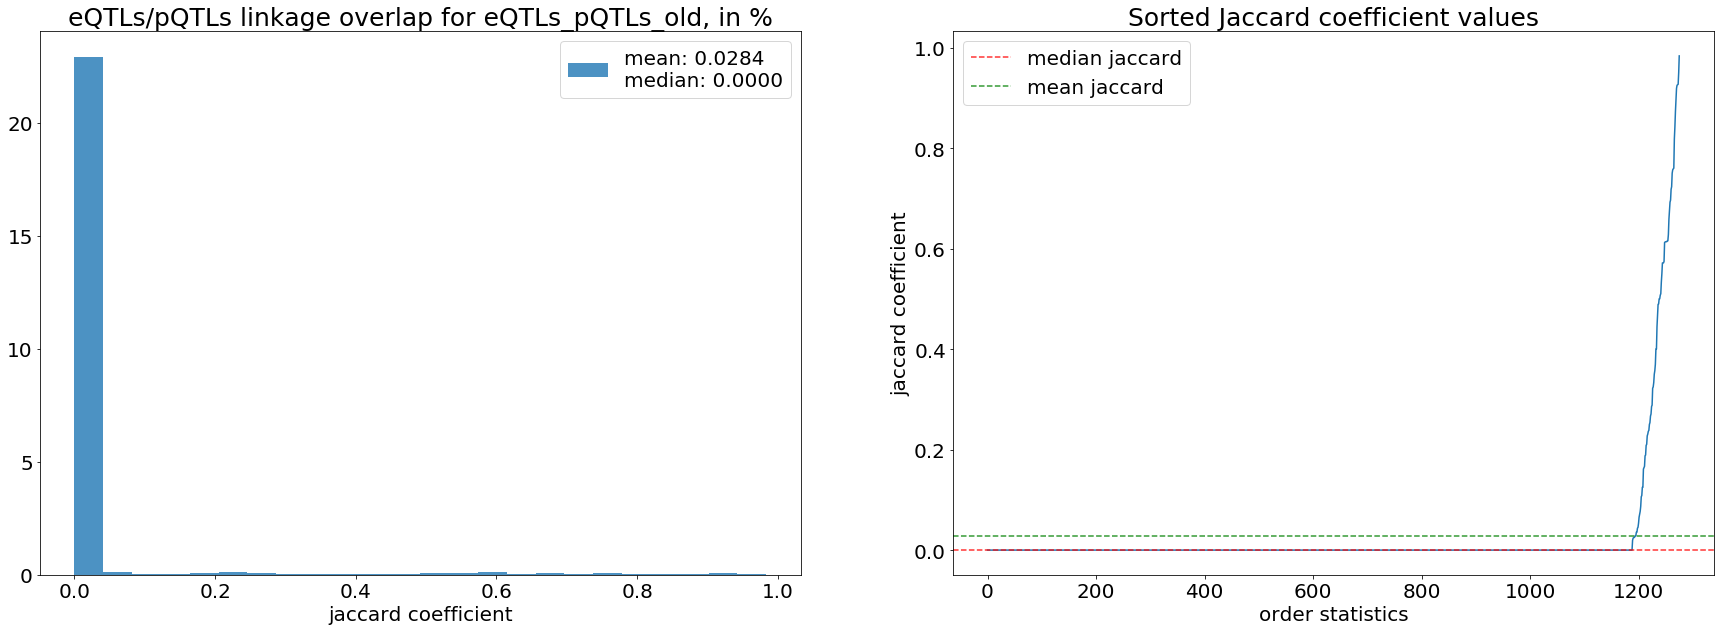

CPU times: user 4.86 s, sys: 24 ms, total: 4.88 s
Wall time: 4.94 s


In [83]:
%%time

reload(qtls)
gene_pool = np.intersect1d(expression_df["eQTLs_old"]["gene"], expression_df["pQTLs"]["gene"])

linkage_overlap_data = []
for gene_name in gene_pool:
    linked_eQTLs = qtls.linked_markers(qtls_df["eQTLs_old"], [gene_name])
    linked_pQTLs = qtls.linked_markers(qtls_df["pQTLs"], [gene_name])
    linkage_overlap_data.append(qtls.jaccard(set(linked_eQTLs), set(linked_pQTLs)))

qtls.qtl_overlap_hist(linkage_overlap_data, "eQTLs_pQTLs_old")


In [10]:
%%time

""" Using simple PPIN-based test to assess whether interacting genes really have better eQTL/pQTL intersection 
    TODO: вычислять доверительные интервалы
"""

def eQTL_pQTL_similarity_ppin_test(qtl_type2graph, interactome_graph):
    scores = []
    for marker in np.intersect1d(qtl_type2graph["eQTLs"].vs.select(part=0)["name"], 
                                 qtl_type2graph["pQTLs"].vs.select(part=0)["name"]):
        linked = {}
        for qtl_type in ["eQTLs", "pQTLs"]:
            linked[qtl_type] = set(qtl_type2graph[qtl_type].vs[qtl_type2graph[qtl_type].neighborhood(marker, mode="out")]["name"])
            linked[qtl_type].remove(marker)
        matches = len(linked["eQTLs"] & linked["pQTLs"])
        tests_count = len(linked["eQTLs"]) * len(linked["pQTLs"])
        for qtl_type in ["eQTLs", "pQTLs"]:
            linked[qtl_type] &= set(interactome_graph.vs["name"])
        for eQTL_gene in linked["eQTLs"]:
            for pQTL_gene in linked["pQTLs"]:
                if eQTL_gene != pQTL_gene \
                        and interactome_graph.are_connected(eQTL_gene, pQTL_gene): 
                    matches += 1
        scores.append(matches / tests_count)
    return np.mean(scores)

tuples_for_df = []
for q_cutoff in 10. ** np.arange(-5, -1):
    qtl_graph = {"eQTLs" : networks.graph_from_edges(qtls_df["eQTLs_old"].query("q_value <= {}".format(q_cutoff))[["SNP", "gene"]].values, directed=True),
                 "pQTLs" : networks.graph_from_edges(qtls_df["pQTLs"].query("q_value <= {}".format(q_cutoff))[["SNP", "gene"]].values, directed=True)}
    
    real_test_results = eQTL_pQTL_similarity_ppin_test(qtl_graph, interactome_graph)
    randomized_test_results = []
    for i in range(1024):
        with open("./data/randomized_interactome_copies/physical/{}.pkl".format(i), "rb") as pickle_file:
            randomized_interactome_graph = pickle.load(pickle_file)
            randomized_test_results.append(
                eQTL_pQTL_similarity_ppin_test(qtl_graph, randomized_interactome_graph)
            )
    tuples_for_df.append((q_cutoff, real_test_results, np.mean(randomized_test_results)))
    
results_df = pd.DataFrame(tuples_for_df, columns=["q_cutoff", "real_mean", "random_mean"])
results_df.to_csv("./data/interactions/eQTL_pQTL_intersection.csv", sep='\t', index=False)
display(results_df)

        

,q_cutoff,real_mean,random_mean,random_median
0,0.00001,0.037566,0.032253,0.031037
1,0.00010,0.030541,0.028900,0.027287
2,0.00100,0.038020,0.029751,0.028188
3,0.01000,0.027084,0.023223,0.022694


CPU times: user 26min 13s, sys: 1.25 s, total: 26min 14s
Wall time: 26min 21s


In [68]:
%%time

""" TODO: доверительные интервалы """

gene_pool = np.intersect1d(expression_df["eQTLs_old"]["gene"].values, expression_df["pQTLs"]["gene"].values)
for q_cutoff in 10. ** np.arange(-5, -1):
    print("q-value threshold: {}".format(q_cutoff))
    for modules_type in ["thecellmap", "kegg_modules", "kegg_pathways", "geneontology"]:
        qtl_graph = {"eQTLs" : networks.graph_from_edges(qtls_df["eQTLs_old"].query("q_value <= {}".format(q_cutoff))[["SNP", "gene"]].values, directed=True),
                     "pQTLs" : networks.graph_from_edges(qtls_df["pQTLs"].query("q_value <= {}".format(q_cutoff))[["SNP", "gene"]].values, directed=True)}
        with open("./results/{}/modules_dict.pkl".format(modules_type), "rb") as pickle_file:
            modules_dict = pickle.load(pickle_file)
        module_genes_union = np.intersect1d(np.unique(np.hstack(modules_dict.values())), gene_pool)
        module_qtls = {}
        for qtl_type in ["eQTLs", "pQTLs"]:
            genes_with_linkages = np.intersect1d(module_genes_union, qtl_graph[qtl_type].vs.select(part=1)["name"])
            induced_subgraph = qtl_graph[qtl_type].subgraph(np.unique(np.hstack(qtl_graph[qtl_type].neighborhood(genes_with_linkages))))
            module_qtls[qtl_type] = [(marker, modules_type) for marker in induced_subgraph.vs.select(part=0)["name"]]
            
        randomized_J_scores = []
        for i in range(1024):
            randomized_modules = [np.random.RandomState().choice(gene_pool, len(module_genes)) for module_genes in modules_dict.values()]
            randomized_module_genes_union = np.unique(np.hstack(randomized_modules))
            randomized_module_qtls = {}
            for qtl_type in ["eQTLs", "pQTLs"]:
                genes_with_linkages = np.intersect1d(randomized_module_genes_union, qtl_graph[qtl_type].vs.select(part=1)["name"])
                induced_subgraph = qtl_graph[qtl_type].subgraph(np.unique(np.hstack(qtl_graph[qtl_type].neighborhood(genes_with_linkages))))
                randomized_module_qtls[qtl_type] = [(marker, modules_type) for marker in induced_subgraph.vs.select(part=0)["name"]]
            randomized_J_scores.append(qtls.jaccard(set(randomized_module_qtls["eQTLs"]), set(randomized_module_qtls["pQTLs"])))
        print("{}\tJ: {:.4}\trJ: {:.4}".format(
            modules_type, 
            qtls.jaccard(set(module_qtls["eQTLs"]), set(module_qtls["pQTLs"])),
            np.mean(randomized_J_scores)
        ))
    print("\n")

q-value threshold: 1e-05


thecellmap	J: 0.2638	rJ: 0.2044


kegg_modules	J: 0.3941	rJ: 0.21


kegg_pathways	J: 0.3736	rJ: 0.1924


geneontology	J: 0.1954	rJ: 0.1916


q-value threshold: 0.0001


thecellmap	J: 0.2617	rJ: 0.2339


kegg_modules	J: 0.3454	rJ: 0.2385


kegg_pathways	J: 0.3814	rJ: 0.2298


geneontology	J: 0.237	rJ: 0.2301


q-value threshold: 0.001


thecellmap	J: 0.3116	rJ: 0.2699


kegg_modules	J: 0.2909	rJ: 0.2763


kegg_pathways	J: 0.3397	rJ: 0.2639


geneontology	J: 0.2655	rJ: 0.2634


q-value threshold: 0.01


thecellmap	J: 0.3154	rJ: 0.324


kegg_modules	J: 0.2753	rJ: 0.3243


kegg_pathways	J: 0.3996	rJ: 0.3426


geneontology	J: 0.3491	rJ: 0.3466


CPU times: user 5min 53s, sys: 3min 8s, total: 9min 2s
Wall time: 9min 2s


Hypothesis arises: maybe not single genes, but functional modules tend to share linkages.  
The goal of this work is to test that hypothesis using yeast interactome data.

## Module processing

## Predicting pQTLs from eQTLs using PPI networks

Now, when approach using interaction networks is justified, it's time to provide solid ground: if significant fraction of pQTLs can be rediscovered from eQTLs linked to genes interacting with given (including itself), it will serve as an additional evidence for hypothesis being actually true (once again, no sophisticated clustering was performed here, while it would possibly yield better results).  

The main idea is not to test all (marker, gene) pairs but to filter for trusted only. In order to get rid of the pairs that will not link (or at least to dump more false than real linkages), the following approach is proposed: 
1. For each gene with measured protein abundance select its eQTL linkages as candidates into pQTLs. 
2. Extend eQTL linkages with those of the interacting genes. 

FDR decreases for the same q-value threshold, which results in more trustworthy observations.

Here is some statistics computed from some subgraphs of the interactome. 

**Physical interactions only**:   
- Common linkages: 2021, 32.7977929243752%
- Old linkages, total: 6162
- New linkages, total: 4048
- New linkages found: 2027

**Full interactome**:
- Common linkages: 3688, 59.85069782538137%
- Old linkages, total: 6162
- New linkages, total: 6219
- New linkages found: 2531

It becomes evident, that a significant fraction of estimated pQTLs can be reproduced using this approach.  
**Nevertheless, many questions arise**:
- Which fraction of trans-pQTLs is reproduced? (and is this approach capable of detecting those)
- Are all the hotspots reproduced? If some are not, why then? It is worth mentioning, that some of those were given cryptic names which are nowhere to be found. 
- How robust the results are? So far results are not compared with those computed from simulated, perturbed graphs. 

In [12]:
modules_type = "thecellmap"
with open("./results/{}/modules_dict.pkl".format(modules_type), "rb") as pickle_file:
    modules_dict = pickle.load(pickle_file)
fdr_cutoffs = np.logspace(-5, -2, 10)

In [13]:
"""Basic information about the functional modules: numbers of vertices and edges for pseudo- and simple subgraphs spanned by modules' genes"""
%%time

for simplify_flag in [False, True]:
    modules_stats = networks.basic_module_info(
         interactome_graph=interactome_graph, 
         modules_dict=modules_dict, 
         modules_type=modules_type,
         simplify=simplify_flag)
    modules_stats.to_csv("./results/{}/".format(modules_type) 
              + ("simplified" if simplify_flag else "raw") 
              + "_module_stats.csv", sep='\t', index=False)
    display(modules_stats.sort_values(by="genes_count", ascending=False))

,module_name,genes_count,genes_with_interactions,interactions_count
6,Mitosis & chromosome segregation,199,149,2478
12,"Glycosylation, protein folding|targeting, cell...",160,140,549
5,"Respiration, oxidative phosphorylation, mitoch...",138,135,318
15,Transcription & chromatin organization,110,85,1575
3,Cell polarity & morphogenesis,102,64,966
14,mRNA & tRNA processing,96,84,1126
4,Vesicle traffic,95,84,770
7,DNA replication & repair,95,75,926
0,rDNA & ncDNA processing,90,76,1055
13,Ribosome biogenesis,74,70,65


,module_name,genes_count,genes_with_interactions,interactions_count
6,Mitosis & chromosome segregation,199,145,667
12,"Glycosylation, protein folding|targeting, cell...",160,96,185
5,"Respiration, oxidative phosphorylation, mitoch...",138,88,165
15,Transcription & chromatin organization,110,81,303
3,Cell polarity & morphogenesis,102,60,225
14,mRNA & tRNA processing,96,80,456
4,Vesicle traffic,95,73,169
7,DNA replication & repair,95,71,183
0,rDNA & ncDNA processing,90,68,424
13,Ribosome biogenesis,74,35,45


CPU times: user 8.65 s, sys: 16 ms, total: 8.66 s
Wall time: 9.33 s


In [9]:
gene_pool = np.intersect1d(expression_df["eQTLs_interpolated"]["gene"], expression_df["pQTLs"]["gene"])

In [18]:

%%time
reload(qtls)

def calculate_eqtl_pqtl_intersection(modules_type):
    with open("./results/{}/modules_dict.pkl".format(modules_type), "rb") as pickle_file:
        modules_dict = pickle.load(pickle_file)
    for eqtls_type in ["old"]:
        print("{}: {}".format(modules_type, eqtls_type))
        pd.DataFrame(
            [
                (q_cutoff, *qtls.qtl_overlap_test(qtls_df["eQTLs_{}".format(eqtls_type)].query("q_value < {}".format(q_cutoff)),
                                                  qtls_df["pQTLs"].query("q_value < {}".format(q_cutoff)),
                                                  gene_pool, modules_dict))
                for q_cutoff in 10.**np.arange(-8, -1)
            ],
            columns = ["q_value_cutoff", "real_modules", "random_modules"],
            dtype=np.float32
        ).to_csv("./results/{}/eQTL_pQTL_intersection_{}.csv".format(modules_type, eqtls_type), sep='\t', index=False)
        
module_types = ["geneontology"]        
joblib.Parallel(n_jobs=len(modules_type))(
    joblib.delayed(calculate_eqtl_pqtl_intersection)(modules_type) 
    for modules_type in module_types
)

CPU times: user 2.1 s, sys: 180 ms, total: 2.28 s
Wall time: 13min 5s


In [6]:
""" The same information, only visualized. """

%%time

intersection_j, randomized_intersection_j = qtls.qtl_overlap_by_module_test(qtls_df["eQTLs_old"], qtls_df["pQTLs"], 
                                                                            gene_pool, modules_dict)

qtls.qtl_overlap_hist(intersection_j, modules_type)
qtls.qtl_overlap_hist(randomized_intersection_j, modules_type + "_randomized")

random samples generated:   0%|          | 0/108 [00:00<?, ?it/s]

random samples generated:   1%|          | 1/108 [00:00<00:31,  3.38it/s]

random samples generated:   2%|▏         | 2/108 [00:00<00:30,  3.53it/s]

random samples generated:   3%|▎         | 3/108 [00:00<00:29,  3.53it/s]

random samples generated:   4%|▎         | 4/108 [00:01<00:29,  3.49it/s]

random samples generated:   5%|▍         | 5/108 [00:01<00:30,  3.34it/s]

random samples generated:   6%|▌         | 6/108 [00:01<00:31,  3.25it/s]

random samples generated:   6%|▋         | 7/108 [00:02<00:30,  3.28it/s]

random samples generated:   7%|▋         | 8/108 [00:02<00:32,  3.11it/s]

random samples generated:   8%|▊         | 9/108 [00:02<00:31,  3.14it/s]

random samples generated:   9%|▉         | 10/108 [00:03<00:30,  3.17it/s]

random samples generated:  10%|█         | 11/108 [00:03<00:30,  3.20it/s]

random samples generated:  11%|█         | 12/108 [00:03<00:30,  3.10it/s]

random samples generated:  12%|█▏        | 13/108 [00:04<00:30,  3.10it/s]

random samples generated:  13%|█▎        | 14/108 [00:04<00:30,  3.11it/s]

random samples generated:  14%|█▍        | 15/108 [00:04<00:29,  3.12it/s]

random samples generated:  15%|█▍        | 16/108 [00:05<00:29,  3.10it/s]

random samples generated:  16%|█▌        | 17/108 [00:05<00:29,  3.07it/s]

random samples generated:  17%|█▋        | 18/108 [00:05<00:28,  3.10it/s]

random samples generated:  18%|█▊        | 19/108 [00:06<00:28,  3.12it/s]

random samples generated:  19%|█▊        | 20/108 [00:06<00:27,  3.15it/s]

random samples generated:  19%|█▉        | 21/108 [00:06<00:27,  3.15it/s]

random samples generated:  20%|██        | 22/108 [00:06<00:27,  3.16it/s]

random samples generated:  21%|██▏       | 23/108 [00:07<00:26,  3.17it/s]

random samples generated:  22%|██▏       | 24/108 [00:07<00:27,  3.09it/s]

random samples generated:  23%|██▎       | 25/108 [00:08<00:27,  3.07it/s]

random samples generated:  24%|██▍       | 26/108 [00:08<00:26,  3.06it/s]

random samples generated:  25%|██▌       | 27/108 [00:08<00:26,  3.05it/s]

random samples generated:  26%|██▌       | 28/108 [00:09<00:26,  3.05it/s]

random samples generated:  27%|██▋       | 29/108 [00:09<00:25,  3.04it/s]

random samples generated:  28%|██▊       | 30/108 [00:09<00:25,  3.06it/s]

random samples generated:  29%|██▊       | 31/108 [00:10<00:25,  3.05it/s]

random samples generated:  30%|██▉       | 32/108 [00:10<00:24,  3.05it/s]

random samples generated:  31%|███       | 33/108 [00:10<00:24,  3.06it/s]

random samples generated:  31%|███▏      | 34/108 [00:11<00:24,  3.05it/s]

random samples generated:  32%|███▏      | 35/108 [00:11<00:23,  3.06it/s]

random samples generated:  33%|███▎      | 36/108 [00:11<00:23,  3.04it/s]

random samples generated:  34%|███▍      | 37/108 [00:12<00:23,  3.02it/s]

random samples generated:  35%|███▌      | 38/108 [00:12<00:23,  3.01it/s]

random samples generated:  36%|███▌      | 39/108 [00:12<00:22,  3.02it/s]

random samples generated:  37%|███▋      | 40/108 [00:13<00:22,  3.03it/s]

random samples generated:  38%|███▊      | 41/108 [00:13<00:22,  3.03it/s]

random samples generated:  39%|███▉      | 42/108 [00:13<00:21,  3.04it/s]

random samples generated:  40%|███▉      | 43/108 [00:14<00:21,  3.04it/s]

random samples generated:  41%|████      | 44/108 [00:14<00:21,  3.05it/s]

random samples generated:  42%|████▏     | 45/108 [00:14<00:20,  3.05it/s]

random samples generated:  43%|████▎     | 46/108 [00:15<00:20,  3.05it/s]

random samples generated:  44%|████▎     | 47/108 [00:15<00:20,  3.05it/s]

random samples generated:  44%|████▍     | 48/108 [00:15<00:19,  3.03it/s]

random samples generated:  45%|████▌     | 49/108 [00:16<00:19,  3.04it/s]

random samples generated:  46%|████▋     | 50/108 [00:16<00:19,  3.05it/s]

random samples generated:  47%|████▋     | 51/108 [00:16<00:18,  3.05it/s]

random samples generated:  48%|████▊     | 52/108 [00:16<00:18,  3.06it/s]

random samples generated:  49%|████▉     | 53/108 [00:17<00:17,  3.06it/s]

random samples generated:  50%|█████     | 54/108 [00:17<00:17,  3.07it/s]

random samples generated:  51%|█████     | 55/108 [00:18<00:17,  3.05it/s]

random samples generated:  52%|█████▏    | 56/108 [00:18<00:17,  3.05it/s]

random samples generated:  53%|█████▎    | 57/108 [00:18<00:16,  3.04it/s]

random samples generated:  54%|█████▎    | 58/108 [00:19<00:16,  3.04it/s]

random samples generated:  55%|█████▍    | 59/108 [00:19<00:16,  3.05it/s]

random samples generated:  56%|█████▌    | 60/108 [00:19<00:15,  3.03it/s]

random samples generated:  56%|█████▋    | 61/108 [00:20<00:15,  3.04it/s]

random samples generated:  57%|█████▋    | 62/108 [00:20<00:15,  3.04it/s]

random samples generated:  58%|█████▊    | 63/108 [00:20<00:14,  3.04it/s]

random samples generated:  59%|█████▉    | 64/108 [00:21<00:14,  3.03it/s]

random samples generated:  60%|██████    | 65/108 [00:21<00:14,  3.03it/s]

random samples generated:  61%|██████    | 66/108 [00:21<00:13,  3.04it/s]

random samples generated:  62%|██████▏   | 67/108 [00:22<00:13,  3.04it/s]

random samples generated:  63%|██████▎   | 68/108 [00:22<00:13,  3.04it/s]

random samples generated:  64%|██████▍   | 69/108 [00:22<00:12,  3.02it/s]

random samples generated:  65%|██████▍   | 70/108 [00:23<00:12,  3.02it/s]

random samples generated:  66%|██████▌   | 71/108 [00:23<00:12,  3.02it/s]

random samples generated:  67%|██████▋   | 72/108 [00:23<00:11,  3.03it/s]

random samples generated:  68%|██████▊   | 73/108 [00:24<00:11,  3.03it/s]

random samples generated:  69%|██████▊   | 74/108 [00:24<00:11,  3.04it/s]

random samples generated:  69%|██████▉   | 75/108 [00:24<00:10,  3.03it/s]

random samples generated:  70%|███████   | 76/108 [00:25<00:10,  3.03it/s]

random samples generated:  71%|███████▏  | 77/108 [00:25<00:10,  3.04it/s]

random samples generated:  72%|███████▏  | 78/108 [00:25<00:09,  3.03it/s]

random samples generated:  73%|███████▎  | 79/108 [00:26<00:09,  3.03it/s]

random samples generated:  74%|███████▍  | 80/108 [00:26<00:09,  3.04it/s]

random samples generated:  75%|███████▌  | 81/108 [00:26<00:08,  3.03it/s]

random samples generated:  76%|███████▌  | 82/108 [00:26<00:08,  3.04it/s]

random samples generated:  77%|███████▋  | 83/108 [00:27<00:08,  3.03it/s]

random samples generated:  78%|███████▊  | 84/108 [00:27<00:07,  3.03it/s]

random samples generated:  79%|███████▊  | 85/108 [00:28<00:07,  3.03it/s]

random samples generated:  80%|███████▉  | 86/108 [00:28<00:07,  3.02it/s]

random samples generated:  81%|████████  | 87/108 [00:28<00:06,  3.01it/s]

random samples generated:  81%|████████▏ | 88/108 [00:29<00:06,  3.00it/s]

random samples generated:  82%|████████▏ | 89/108 [00:29<00:06,  3.01it/s]

random samples generated:  83%|████████▎ | 90/108 [00:29<00:05,  3.01it/s]

random samples generated:  84%|████████▍ | 91/108 [00:30<00:05,  3.00it/s]

random samples generated:  85%|████████▌ | 92/108 [00:30<00:05,  3.01it/s]

random samples generated:  86%|████████▌ | 93/108 [00:30<00:04,  3.00it/s]

random samples generated:  87%|████████▋ | 94/108 [00:31<00:04,  3.00it/s]

random samples generated:  88%|████████▊ | 95/108 [00:31<00:04,  3.00it/s]

random samples generated:  89%|████████▉ | 96/108 [00:31<00:03,  3.00it/s]

random samples generated:  90%|████████▉ | 97/108 [00:32<00:03,  2.99it/s]

random samples generated:  91%|█████████ | 98/108 [00:32<00:03,  2.99it/s]

random samples generated:  92%|█████████▏| 99/108 [00:33<00:03,  2.99it/s]

random samples generated:  93%|█████████▎| 100/108 [00:33<00:02,  2.99it/s]

random samples generated:  94%|█████████▎| 101/108 [00:33<00:02,  2.99it/s]

random samples generated:  94%|█████████▍| 102/108 [00:34<00:02,  2.99it/s]

random samples generated:  95%|█████████▌| 103/108 [00:34<00:01,  2.98it/s]

random samples generated:  96%|█████████▋| 104/108 [00:34<00:01,  2.99it/s]

random samples generated:  97%|█████████▋| 105/108 [00:35<00:01,  2.99it/s]

random samples generated:  98%|█████████▊| 106/108 [00:35<00:00,  2.98it/s]

random samples generated:  99%|█████████▉| 107/108 [00:35<00:00,  2.98it/s]

random samples generated: 100%|██████████| 108/108 [00:36<00:00,  2.97it/s]

CPU times: user 39.8 s, sys: 184 ms, total: 40 s
Wall time: 39.8 s


In [146]:
"""
OBSERVATION: gene pool tends to be biased towards high eQTL/pQTL overlap ration.
Reasons and interpretations of such behaviour remain unclear.    
"""

sample_size = 10
def randomize_and_overlap(sample_size, iter_num=200):
    jaccard_coeffs = []
    for i in range(iter_num):
        gene_sample = np.random.RandomState().choice(gene_pool, sample_size, replace=False)
        linked_eQTLs = set(qtls.linked_markers(qtls_df["eQTLs_old"], gene_sample))
        linked_pQTLs = set(qtls.linked_markers(qtls_df["pQTLs"], gene_sample))
        jaccard_coeffs.append(qtls.jaccard(linked_eQTLs, linked_pQTLs))
    return np.mean(jaccard_coeffs)

display(
    pd.DataFrame(
        [
            (q_cutoff, randomize_and_overlap(sample_size))
            for q_cutoff in 10.**np.arange(-8, -1)
        ],
        columns = ["q_value_cutoff", "random_samples_of_size_{}".format(sample_size)],
        dtype=np.float32
    )
)

,q_value_cutoff,random_samples_of_size_10
0,1.000000e-08,0.137914
1,1.000000e-07,0.159089
2,1.000000e-06,0.160416
3,1.000000e-05,0.135067
4,1.000000e-04,0.171282
5,1.000000e-03,0.156258
6,1.000000e-02,0.153712


In [5]:
""" Helper cell. Used to visualize results of full-graph test and PPIN test. """

%%time
reload(qtls)
for expression_df, qtl_df, qtl_type in [(expression_df["eQTLs_old"], qtls_df["eQTLs_old"], "eQTLs"),
                                        (expression_df["pQTLs"], qtls_df["pQTLs"], "pQTLs")]:
    qtls.plot_analysis_results(
        expression_df=expression_df,
        interactions_type="physical",
        interactome_graph=interactome_graph,
        modules_dict=modules_dict,
        modules_type=modules_type,
        qtl_df=qtl_df,
        qtl_type=qtl_type
    )
    


subdirectories processed:   0%|          | 0/18 [00:00<?, ?it/s]

subdirectories processed:   6%|▌         | 1/18 [00:00<00:07,  2.28it/s]

subdirectories processed:  11%|█         | 2/18 [00:00<00:07,  2.22it/s]

subdirectories processed:  17%|█▋        | 3/18 [00:01<00:07,  2.14it/s]

subdirectories processed:  33%|███▎      | 6/18 [00:01<00:03,  3.41it/s]

subdirectories processed:  39%|███▉      | 7/18 [00:02<00:03,  3.30it/s]

subdirectories processed:  56%|█████▌    | 10/18 [00:02<00:01,  4.04it/s]

subdirectories processed:  67%|██████▋   | 12/18 [00:02<00:01,  4.23it/s]

subdirectories processed:  89%|████████▉ | 16/18 [00:03<00:00,  5.00it/s]

subdirectories processed:  94%|█████████▍| 17/18 [00:03<00:00,  4.77it/s]

subdirectories processed: 100%|██████████| 18/18 [00:03<00:00,  4.59it/s]


graphs and hists plotted:   0%|          | 0/10 [00:00<?, ?it/s]

graphs and hists plotted:  10%|█         | 1/10 [00:00<00:03,  2.69it/s]

graphs and hists plotted:  20%|██        | 2/10 [00:00<00:02,  2.71it/s]

graphs and hists plotted:  30%|███       | 3/10 [00:01<00:02,  2.71it/s]

graphs and hists plotted:  40%|████      | 4/10 [00:01<00:02,  2.65it/s]

graphs and hists plotted:  50%|█████     | 5/10 [00:01<00:01,  2.63it/s]

graphs and hists plotted:  60%|██████    | 6/10 [00:02<00:01,  2.62it/s]

graphs and hists plotted:  70%|███████   | 7/10 [00:02<00:01,  2.60it/s]

graphs and hists plotted:  80%|████████  | 8/10 [00:03<00:00,  2.60it/s]

graphs and hists plotted:  90%|█████████ | 9/10 [00:03<00:00,  2.61it/s]

graphs and hists plotted: 100%|██████████| 10/10 [00:03<00:00,  2.61it/s]


vignettes plotted:   0%|          | 0/10 [00:00<?, ?it/s]

vignettes plotted:  10%|█         | 1/10 [00:00<00:03,  2.57it/s]

vignettes plotted:  20%|██        | 2/10 [00:00<00:02,  2.93it/s]

vignettes plotted:  30%|███       | 3/10 [00:00<00:02,  3.09it/s]

vignettes plotted:  40%|████      | 4/10 [00:01<00:01,  3.17it/s]

vignettes plotted:  50%|█████     | 5/10 [00:01<00:01,  3.22it/s]

vignettes plotted:  60%|██████    | 6/10 [00:01<00:01,  3.26it/s]

vignettes plotted:  70%|███████   | 7/10 [00:02<00:00,  3.28it/s]

vignettes plotted:  80%|████████  | 8/10 [00:02<00:00,  3.31it/s]

vignettes plotted:  90%|█████████ | 9/10 [00:02<00:00,  3.32it/s]

vignettes plotted: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


subdirectories processed:   0%|          | 0/28 [00:00<?, ?it/s]

subdirectories processed:   4%|▎         | 1/28 [00:00<00:11,  2.35it/s]

subdirectories processed:  14%|█▍        | 4/28 [00:00<00:05,  4.77it/s]

subdirectories processed:  18%|█▊        | 5/28 [00:01<00:05,  3.92it/s]

subdirectories processed:  36%|███▌      | 10/28 [00:01<00:03,  5.89it/s]

subdirectories processed:  39%|███▉      | 11/28 [00:02<00:03,  5.21it/s]

subdirectories processed:  54%|█████▎    | 15/28 [00:02<00:02,  5.89it/s]

subdirectories processed:  61%|██████    | 17/28 [00:02<00:01,  5.69it/s]

subdirectories processed:  79%|███████▊  | 22/28 [00:03<00:00,  6.42it/s]

subdirectories processed:  89%|████████▉ | 25/28 [00:03<00:00,  6.43it/s]

subdirectories processed:  93%|█████████▎| 26/28 [00:04<00:00,  5.95it/s]

subdirectories processed: 100%|██████████| 28/28 [00:04<00:00,  6.41it/s]


graphs and hists plotted:   0%|          | 0/10 [00:00<?, ?it/s]

graphs and hists plotted:  10%|█         | 1/10 [00:00<00:04,  2.24it/s]

graphs and hists plotted:  20%|██        | 2/10 [00:00<00:03,  2.29it/s]

graphs and hists plotted:  30%|███       | 3/10 [00:01<00:03,  2.31it/s]

graphs and hists plotted:  40%|████      | 4/10 [00:01<00:02,  2.35it/s]

graphs and hists plotted:  50%|█████     | 5/10 [00:02<00:02,  2.35it/s]

graphs and hists plotted:  60%|██████    | 6/10 [00:02<00:01,  2.32it/s]

graphs and hists plotted:  70%|███████   | 7/10 [00:03<00:01,  2.31it/s]

graphs and hists plotted:  80%|████████  | 8/10 [00:03<00:00,  2.32it/s]

graphs and hists plotted:  90%|█████████ | 9/10 [00:03<00:00,  2.32it/s]

graphs and hists plotted: 100%|██████████| 10/10 [00:04<00:00,  2.32it/s]


vignettes plotted:   0%|          | 0/10 [00:00<?, ?it/s]

vignettes plotted:  10%|█         | 1/10 [00:00<00:04,  1.91it/s]

vignettes plotted:  20%|██        | 2/10 [00:01<00:04,  1.92it/s]

vignettes plotted:  30%|███       | 3/10 [00:01<00:03,  1.90it/s]

vignettes plotted:  40%|████      | 4/10 [00:02<00:03,  1.89it/s]

vignettes plotted:  50%|█████     | 5/10 [00:02<00:02,  1.89it/s]

vignettes plotted:  60%|██████    | 6/10 [00:03<00:02,  1.89it/s]

vignettes plotted:  70%|███████   | 7/10 [00:03<00:01,  1.89it/s]

vignettes plotted:  80%|████████  | 8/10 [00:04<00:01,  1.87it/s]

vignettes plotted:  90%|█████████ | 9/10 [00:04<00:00,  1.86it/s]

vignettes plotted: 100%|██████████| 10/10 [00:05<00:00,  1.87it/s]

CPU times: user 38.8 s, sys: 580 ms, total: 39.4 s
Wall time: 25 s


In [126]:
""" INVESTIGATION: how precisely can pQTLs be predicted from eQTLs given PPIN? """

%%time

reload(qtls)
print(modules_type)

predictions_dict = {}
for module_name, module_genes in tqdm(modules_dict.items()):
    predictions_dict[module_name] = qtls.PqtlPredictor(
        eqtls_df=qtls_df["eQTLs_old"], pqtls_df=qtls_df["pQTLs"],
        pqtls_expression_df=expression_df["pQTLs"], pqtls_genotypes_df=genotypes_df["pQTLs"],
        module_name=module_name, module_genes=module_genes,
        interactome_graph=interactome_graph
    ).predict()

display(pd.DataFrame(
    ((key, *values) for key, values in predictions_dict.items()),
    columns=["module_name", "common_pQTLs", "overlap_ratio", "old_pQTLs", "predicted_pQTLs", "delta"]
).sort_values(by="overlap_ratio", ascending=False))

thecellmap
Ribosome biogenesis


/home/vvi/Science/eQTL_analysis/src/qtls.py:796: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  columns=pqtls_expression_df.columns[1:]
/home/vvi/Science/eQTL_analysis/src/qtls.py:800: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  columns=pqtls_genotypes_df.columns[1:]


CPU times: user 2min 56s, sys: 20.3 s, total: 3min 16s
Wall time: 3min 22s


## GeneOntology

In [5]:
""" GO terms covering 10-150 genes are extracted and used to generate functional modules."""

from goatools import obo_parser

# building the GeneOntology DAG
obodag = obo_parser.GODag(
    "./data/geneontology/go-basic.obo",
    optional_attrs=["relationship"]
)
from Bio.UniProt.GOA import gafiterator

# how many of them are present in actual yeast genome?
yeast_gaf = './data/geneontology/goa_yeast.gaf'
goid2genes = collections.defaultdict(list)
with open(yeast_gaf) as handle:
    for rec in gafiterator(handle):
        go_term = obodag[rec["GO_ID"]]
        for par in go_term.parents:
            goid2genes[par.id].append(rec["DB_Object_Symbol"])
            
for key, val in goid2genes.items():
    goid2genes[key] = np.unique(val)

physically_interacting_genes = set(interactome_graphs_dict["physical"].vs["name"])
geneontology_modules_dict = {
    obodag[go_id].name.replace('/', '|') : genes 
    for go_id, genes in tqdm(goid2genes.items()) 
    if 10 <= len(interactome_graphs_dict["physical"].subgraph(
            set(genes) & physically_interacting_genes
        ).simplify().vs.select(_degree_gt=0)) <= 150
}

with open("./results/geneontology/modules_dict.pkl", "wb+") as pickle_file:
    pickle.dump(geneontology_modules_dict, pickle_file)
# with open("./results/geneontology/modules_dict.pkl", "rb+") as pickle_file:
#     geneontology_modules_dict = pickle.load(pickle_file)

./data/geneontology/go-basic.obo: fmt(1.2) rel(2018-07-02) 47,231 GO Terms; optional_attrs(relationship)


  0%|          | 0/4136 [00:00<?, ?it/s]

 17%|█▋        | 687/4136 [00:00<00:00, 6862.20it/s]

 29%|██▉       | 1218/4136 [00:00<00:00, 6084.30it/s]

 47%|████▋     | 1960/4136 [00:00<00:00, 6528.53it/s]

 65%|██████▍   | 2682/4136 [00:00<00:00, 6686.99it/s]

 78%|███████▊  | 3226/4136 [00:00<00:00, 6437.86it/s]

 95%|█████████▍| 3915/4136 [00:00<00:00, 6509.87it/s]

100%|██████████| 4136/4136 [00:00<00:00, 6431.32it/s]

## KEGG pathways

In [6]:
""" KEGG pathways are retrieved by querying KEGG database """

%%time 
kegg_pathways_dict = {("-".join(key.split('-')[:-1])):value for key, value in 
                     ontologies.query_KEGG(database="pathway", organism="sce").items()}

with open("./results/kegg_pathways/modules_dict.pkl", "wb+") as pickle_file:
    pickle.dump(kegg_pathways_dict, pickle_file)
# with open("./results/kegg_pathways/modules_dict.pkl", "rb+") as pickle_file:
#     kegg_pathways_dict = pickle.load(pickle_file)

modules retrieved:   0%|          | 0/116 [00:00<?, ?it/s]

modules retrieved:   1%|          | 1/116 [00:01<02:12,  1.15s/it]

modules retrieved:   2%|▏         | 2/116 [00:02<02:12,  1.16s/it]

modules retrieved:   3%|▎         | 3/116 [00:07<04:25,  2.35s/it]

modules retrieved:   3%|▎         | 4/116 [00:08<03:47,  2.03s/it]

modules retrieved:   4%|▍         | 5/116 [00:09<03:27,  1.87s/it]

modules retrieved:   5%|▌         | 6/116 [00:10<03:04,  1.68s/it]

modules retrieved:   6%|▌         | 7/116 [00:10<02:48,  1.54s/it]

modules retrieved:   7%|▋         | 8/116 [00:11<02:39,  1.48s/it]

modules retrieved:   8%|▊         | 9/116 [00:12<02:29,  1.39s/it]

modules retrieved:   9%|▊         | 10/116 [00:13<02:20,  1.32s/it]

modules retrieved:   9%|▉         | 11/116 [00:14<02:16,  1.30s/it]

modules retrieved:  10%|█         | 12/116 [00:17<02:29,  1.43s/it]

modules retrieved:  11%|█         | 13/116 [00:18<02:25,  1.41s/it]

modules retrieved:  12%|█▏        | 14/116 [00:19<02:19,  1.37s/it]

modules retrieved:  13%|█▎        | 15/116 [00:20<02:16,  1.35s/it]

modules retrieved:  14%|█▍        | 16/116 [00:21<02:14,  1.35s/it]

modules retrieved:  15%|█▍        | 17/116 [00:22<02:13,  1.35s/it]

modules retrieved:  16%|█▌        | 18/116 [00:24<02:12,  1.36s/it]

modules retrieved:  16%|█▋        | 19/116 [00:25<02:11,  1.36s/it]

modules retrieved:  17%|█▋        | 20/116 [00:26<02:09,  1.35s/it]

modules retrieved:  18%|█▊        | 21/116 [00:27<02:04,  1.31s/it]

modules retrieved:  19%|█▉        | 22/116 [00:28<02:00,  1.29s/it]

modules retrieved:  20%|█▉        | 23/116 [00:29<01:57,  1.26s/it]

modules retrieved:  21%|██        | 24/116 [00:31<02:00,  1.31s/it]

modules retrieved:  22%|██▏       | 25/116 [00:32<01:57,  1.30s/it]

modules retrieved:  22%|██▏       | 26/116 [00:33<01:55,  1.29s/it]

modules retrieved:  23%|██▎       | 27/116 [00:34<01:52,  1.27s/it]

modules retrieved:  24%|██▍       | 28/116 [00:34<01:49,  1.25s/it]

modules retrieved:  25%|██▌       | 29/116 [00:36<01:48,  1.25s/it]

modules retrieved:  26%|██▌       | 30/116 [00:36<01:45,  1.23s/it]

modules retrieved:  27%|██▋       | 31/116 [00:37<01:43,  1.22s/it]

modules retrieved:  28%|██▊       | 32/116 [00:38<01:40,  1.20s/it]

modules retrieved:  28%|██▊       | 33/116 [00:39<01:38,  1.19s/it]

modules retrieved:  29%|██▉       | 34/116 [00:40<01:36,  1.18s/it]

modules retrieved:  30%|███       | 35/116 [00:40<01:34,  1.17s/it]

modules retrieved:  31%|███       | 36/116 [00:41<01:32,  1.15s/it]

modules retrieved:  32%|███▏      | 37/116 [00:42<01:31,  1.15s/it]

modules retrieved:  33%|███▎      | 38/116 [00:43<01:29,  1.15s/it]

modules retrieved:  34%|███▎      | 39/116 [00:44<01:28,  1.15s/it]

modules retrieved:  34%|███▍      | 40/116 [00:45<01:26,  1.14s/it]

modules retrieved:  35%|███▌      | 41/116 [00:46<01:25,  1.14s/it]

modules retrieved:  36%|███▌      | 42/116 [00:47<01:23,  1.13s/it]

modules retrieved:  37%|███▋      | 43/116 [00:48<01:22,  1.12s/it]

modules retrieved:  38%|███▊      | 44/116 [00:49<01:20,  1.12s/it]

modules retrieved:  39%|███▉      | 45/116 [00:50<01:19,  1.12s/it]

modules retrieved:  40%|███▉      | 46/116 [00:51<01:17,  1.11s/it]

modules retrieved:  41%|████      | 47/116 [00:52<01:16,  1.11s/it]

modules retrieved:  41%|████▏     | 48/116 [00:53<01:15,  1.11s/it]

modules retrieved:  42%|████▏     | 49/116 [00:53<01:13,  1.10s/it]

modules retrieved:  43%|████▎     | 50/116 [00:54<01:12,  1.10s/it]

modules retrieved:  44%|████▍     | 51/116 [00:55<01:10,  1.09s/it]

modules retrieved:  45%|████▍     | 52/116 [00:56<01:09,  1.08s/it]

modules retrieved:  46%|████▌     | 53/116 [00:57<01:07,  1.08s/it]

modules retrieved:  47%|████▋     | 54/116 [00:58<01:06,  1.08s/it]

modules retrieved:  47%|████▋     | 55/116 [00:58<01:05,  1.07s/it]

modules retrieved:  48%|████▊     | 56/116 [00:59<01:03,  1.06s/it]

modules retrieved:  49%|████▉     | 57/116 [01:00<01:02,  1.06s/it]

modules retrieved:  50%|█████     | 58/116 [01:00<01:00,  1.05s/it]

modules retrieved:  51%|█████     | 59/116 [01:02<00:59,  1.05s/it]

modules retrieved:  52%|█████▏    | 60/116 [01:03<00:58,  1.05s/it]

modules retrieved:  53%|█████▎    | 61/116 [01:03<00:57,  1.04s/it]

modules retrieved:  53%|█████▎    | 62/116 [01:04<00:56,  1.05s/it]

modules retrieved:  54%|█████▍    | 63/116 [01:05<00:55,  1.05s/it]

modules retrieved:  55%|█████▌    | 64/116 [01:06<00:54,  1.04s/it]

modules retrieved:  56%|█████▌    | 65/116 [01:07<00:53,  1.04s/it]

modules retrieved:  57%|█████▋    | 66/116 [01:08<00:51,  1.04s/it]

modules retrieved:  58%|█████▊    | 67/116 [01:09<00:50,  1.04s/it]

modules retrieved:  59%|█████▊    | 68/116 [01:10<00:49,  1.03s/it]

modules retrieved:  59%|█████▉    | 69/116 [01:11<00:48,  1.03s/it]

modules retrieved:  60%|██████    | 70/116 [01:12<00:47,  1.03s/it]

modules retrieved:  61%|██████    | 71/116 [01:13<00:46,  1.04s/it]

modules retrieved:  62%|██████▏   | 72/116 [01:14<00:45,  1.04s/it]

modules retrieved:  63%|██████▎   | 73/116 [01:15<00:44,  1.04s/it]

modules retrieved:  64%|██████▍   | 74/116 [01:17<00:44,  1.05s/it]

modules retrieved:  65%|██████▍   | 75/116 [01:18<00:43,  1.05s/it]

modules retrieved:  66%|██████▌   | 76/116 [01:19<00:41,  1.04s/it]

modules retrieved:  66%|██████▋   | 77/116 [01:20<00:40,  1.04s/it]

modules retrieved:  67%|██████▋   | 78/116 [01:20<00:39,  1.04s/it]

modules retrieved:  68%|██████▊   | 79/116 [01:21<00:38,  1.03s/it]

modules retrieved:  69%|██████▉   | 80/116 [01:22<00:37,  1.03s/it]

modules retrieved:  70%|██████▉   | 81/116 [01:22<00:35,  1.02s/it]

modules retrieved:  71%|███████   | 82/116 [01:23<00:34,  1.02s/it]

modules retrieved:  72%|███████▏  | 83/116 [01:24<00:33,  1.02s/it]

modules retrieved:  72%|███████▏  | 84/116 [01:25<00:32,  1.02s/it]

modules retrieved:  73%|███████▎  | 85/116 [01:27<00:31,  1.03s/it]

modules retrieved:  74%|███████▍  | 86/116 [01:28<00:30,  1.03s/it]

modules retrieved:  75%|███████▌  | 87/116 [01:29<00:29,  1.03s/it]

modules retrieved:  76%|███████▌  | 88/116 [01:30<00:28,  1.03s/it]

modules retrieved:  77%|███████▋  | 89/116 [01:31<00:27,  1.03s/it]

modules retrieved:  78%|███████▊  | 90/116 [01:32<00:26,  1.03s/it]

modules retrieved:  78%|███████▊  | 91/116 [01:33<00:25,  1.02s/it]

modules retrieved:  79%|███████▉  | 92/116 [01:34<00:24,  1.02s/it]

modules retrieved:  80%|████████  | 93/116 [01:35<00:23,  1.03s/it]

modules retrieved:  81%|████████  | 94/116 [01:36<00:22,  1.03s/it]

modules retrieved:  82%|████████▏ | 95/116 [01:38<00:21,  1.04s/it]

modules retrieved:  83%|████████▎ | 96/116 [01:39<00:20,  1.03s/it]

modules retrieved:  84%|████████▎ | 97/116 [01:39<00:19,  1.03s/it]

modules retrieved:  84%|████████▍ | 98/116 [01:40<00:18,  1.03s/it]

modules retrieved:  85%|████████▌ | 99/116 [01:41<00:17,  1.02s/it]

modules retrieved:  86%|████████▌ | 100/116 [01:42<00:16,  1.02s/it]

modules retrieved:  87%|████████▋ | 101/116 [01:43<00:15,  1.02s/it]

modules retrieved:  88%|████████▊ | 102/116 [01:44<00:14,  1.03s/it]

modules retrieved:  89%|████████▉ | 103/116 [01:46<00:13,  1.03s/it]

modules retrieved:  90%|████████▉ | 104/116 [01:47<00:12,  1.03s/it]

modules retrieved:  91%|█████████ | 105/116 [01:47<00:11,  1.03s/it]

modules retrieved:  91%|█████████▏| 106/116 [01:49<00:10,  1.03s/it]

modules retrieved:  92%|█████████▏| 107/116 [01:50<00:09,  1.03s/it]

modules retrieved:  93%|█████████▎| 108/116 [01:50<00:08,  1.03s/it]

modules retrieved:  94%|█████████▍| 109/116 [01:51<00:07,  1.03s/it]

modules retrieved:  95%|█████████▍| 110/116 [01:52<00:06,  1.03s/it]

modules retrieved:  96%|█████████▌| 111/116 [01:53<00:05,  1.03s/it]

modules retrieved:  97%|█████████▋| 112/116 [01:54<00:04,  1.02s/it]

modules retrieved:  97%|█████████▋| 113/116 [01:55<00:03,  1.02s/it]

modules retrieved:  98%|█████████▊| 114/116 [01:56<00:02,  1.02s/it]

modules retrieved:  99%|█████████▉| 115/116 [01:57<00:01,  1.02s/it]

modules retrieved: 100%|██████████| 116/116 [01:58<00:00,  1.02s/it]

CPU times: user 7.33 s, sys: 308 ms, total: 7.64 s
Wall time: 2min


## KEGG modules

In [7]:
""" Same for KEGG modules. """

%%time
reload(ontologies)

kegg_modules_dict = {key.replace('=>', 'to'):value for key, value in 
                     ontologies.query_KEGG(database="module", organism="sce").items()}

with open("./results/kegg_modules/modules_dict.pkl", "wb+") as pickle_file:
    pickle.dump(kegg_modules_dict, pickle_file)


modules retrieved:   0%|          | 0/108 [00:00<?, ?it/s]

modules retrieved:   1%|          | 1/108 [00:00<01:18,  1.36it/s]

modules retrieved:   2%|▏         | 2/108 [00:02<02:22,  1.35s/it]

modules retrieved:   3%|▎         | 3/108 [00:03<01:59,  1.14s/it]

modules retrieved:   4%|▎         | 4/108 [00:04<01:48,  1.05s/it]

modules retrieved:   5%|▍         | 5/108 [00:04<01:40,  1.02it/s]

modules retrieved:   6%|▌         | 6/108 [00:05<01:34,  1.08it/s]

modules retrieved:   6%|▋         | 7/108 [00:06<01:29,  1.12it/s]

modules retrieved:   7%|▋         | 8/108 [00:06<01:26,  1.16it/s]

modules retrieved:   8%|▊         | 9/108 [00:07<01:23,  1.19it/s]

modules retrieved:   9%|▉         | 10/108 [00:08<01:21,  1.20it/s]

modules retrieved:  10%|█         | 11/108 [00:09<01:19,  1.22it/s]

modules retrieved:  11%|█         | 12/108 [00:09<01:17,  1.24it/s]

modules retrieved:  12%|█▏        | 13/108 [00:10<01:15,  1.26it/s]

modules retrieved:  13%|█▎        | 14/108 [00:10<01:13,  1.28it/s]

modules retrieved:  14%|█▍        | 15/108 [00:11<01:13,  1.27it/s]

modules retrieved:  15%|█▍        | 16/108 [00:12<01:11,  1.28it/s]

modules retrieved:  16%|█▌        | 17/108 [00:13<01:11,  1.26it/s]

modules retrieved:  17%|█▋        | 18/108 [00:14<01:10,  1.28it/s]

modules retrieved:  18%|█▊        | 19/108 [00:14<01:09,  1.28it/s]

modules retrieved:  19%|█▊        | 20/108 [00:15<01:07,  1.29it/s]

modules retrieved:  19%|█▉        | 21/108 [00:16<01:06,  1.30it/s]

modules retrieved:  20%|██        | 22/108 [00:16<01:05,  1.31it/s]

modules retrieved:  21%|██▏       | 23/108 [00:17<01:04,  1.32it/s]

modules retrieved:  22%|██▏       | 24/108 [00:18<01:03,  1.32it/s]

modules retrieved:  23%|██▎       | 25/108 [00:18<01:02,  1.33it/s]

modules retrieved:  24%|██▍       | 26/108 [00:19<01:01,  1.33it/s]

modules retrieved:  25%|██▌       | 27/108 [00:20<01:00,  1.34it/s]

modules retrieved:  26%|██▌       | 28/108 [00:20<00:59,  1.34it/s]

modules retrieved:  27%|██▋       | 29/108 [00:21<00:59,  1.32it/s]

modules retrieved:  28%|██▊       | 30/108 [00:22<00:59,  1.31it/s]

modules retrieved:  29%|██▊       | 31/108 [00:24<00:59,  1.29it/s]

modules retrieved:  30%|██▉       | 32/108 [00:27<01:05,  1.15it/s]

modules retrieved:  31%|███       | 33/108 [00:28<01:04,  1.16it/s]

modules retrieved:  31%|███▏      | 34/108 [00:29<01:03,  1.17it/s]

modules retrieved:  32%|███▏      | 35/108 [00:29<01:02,  1.17it/s]

modules retrieved:  33%|███▎      | 36/108 [00:30<01:00,  1.18it/s]

modules retrieved:  34%|███▍      | 37/108 [00:31<00:59,  1.19it/s]

modules retrieved:  35%|███▌      | 38/108 [00:31<00:58,  1.19it/s]

modules retrieved:  36%|███▌      | 39/108 [00:32<00:57,  1.20it/s]

modules retrieved:  37%|███▋      | 40/108 [00:33<00:56,  1.20it/s]

modules retrieved:  38%|███▊      | 41/108 [00:33<00:55,  1.21it/s]

modules retrieved:  39%|███▉      | 42/108 [00:34<00:54,  1.21it/s]

modules retrieved:  40%|███▉      | 43/108 [00:35<00:53,  1.22it/s]

modules retrieved:  41%|████      | 44/108 [00:36<00:52,  1.22it/s]

modules retrieved:  42%|████▏     | 45/108 [00:36<00:51,  1.22it/s]

modules retrieved:  43%|████▎     | 46/108 [00:37<00:50,  1.22it/s]

modules retrieved:  44%|████▎     | 47/108 [00:38<00:49,  1.23it/s]

modules retrieved:  44%|████▍     | 48/108 [00:39<00:48,  1.23it/s]

modules retrieved:  45%|████▌     | 49/108 [00:39<00:47,  1.23it/s]

modules retrieved:  46%|████▋     | 50/108 [00:40<00:46,  1.24it/s]

modules retrieved:  47%|████▋     | 51/108 [00:41<00:46,  1.24it/s]

modules retrieved:  48%|████▊     | 52/108 [00:41<00:45,  1.24it/s]

modules retrieved:  49%|████▉     | 53/108 [00:42<00:44,  1.24it/s]

modules retrieved:  50%|█████     | 54/108 [00:43<00:43,  1.25it/s]

modules retrieved:  51%|█████     | 55/108 [00:44<00:43,  1.23it/s]

modules retrieved:  52%|█████▏    | 56/108 [00:46<00:43,  1.19it/s]

modules retrieved:  53%|█████▎    | 57/108 [00:47<00:42,  1.19it/s]

modules retrieved:  54%|█████▎    | 58/108 [00:48<00:41,  1.20it/s]

modules retrieved:  55%|█████▍    | 59/108 [00:49<00:40,  1.20it/s]

modules retrieved:  56%|█████▌    | 60/108 [00:49<00:39,  1.20it/s]

modules retrieved:  56%|█████▋    | 61/108 [00:50<00:38,  1.21it/s]

modules retrieved:  57%|█████▋    | 62/108 [00:51<00:38,  1.21it/s]

modules retrieved:  58%|█████▊    | 63/108 [00:51<00:37,  1.21it/s]

modules retrieved:  59%|█████▉    | 64/108 [00:52<00:36,  1.21it/s]

modules retrieved:  60%|██████    | 65/108 [00:53<00:35,  1.22it/s]

modules retrieved:  61%|██████    | 66/108 [00:54<00:34,  1.22it/s]

modules retrieved:  62%|██████▏   | 67/108 [00:54<00:33,  1.22it/s]

modules retrieved:  63%|██████▎   | 68/108 [00:55<00:32,  1.23it/s]

modules retrieved:  64%|██████▍   | 69/108 [00:56<00:31,  1.23it/s]

modules retrieved:  65%|██████▍   | 70/108 [00:56<00:30,  1.23it/s]

modules retrieved:  66%|██████▌   | 71/108 [00:57<00:30,  1.23it/s]

modules retrieved:  67%|██████▋   | 72/108 [00:58<00:29,  1.23it/s]

modules retrieved:  68%|██████▊   | 73/108 [00:59<00:28,  1.23it/s]

modules retrieved:  69%|██████▊   | 74/108 [01:00<00:27,  1.23it/s]

modules retrieved:  69%|██████▉   | 75/108 [01:00<00:26,  1.23it/s]

modules retrieved:  70%|███████   | 76/108 [01:01<00:25,  1.24it/s]

modules retrieved:  71%|███████▏  | 77/108 [01:02<00:25,  1.24it/s]

modules retrieved:  72%|███████▏  | 78/108 [01:02<00:24,  1.24it/s]

modules retrieved:  73%|███████▎  | 79/108 [01:03<00:23,  1.24it/s]

modules retrieved:  74%|███████▍  | 80/108 [01:04<00:22,  1.24it/s]

modules retrieved:  75%|███████▌  | 81/108 [01:05<00:21,  1.24it/s]

modules retrieved:  76%|███████▌  | 82/108 [01:05<00:20,  1.25it/s]

modules retrieved:  77%|███████▋  | 83/108 [01:06<00:20,  1.25it/s]

modules retrieved:  78%|███████▊  | 84/108 [01:07<00:19,  1.25it/s]

modules retrieved:  79%|███████▊  | 85/108 [01:07<00:18,  1.25it/s]

modules retrieved:  80%|███████▉  | 86/108 [01:08<00:17,  1.26it/s]

modules retrieved:  81%|████████  | 87/108 [01:09<00:16,  1.26it/s]

modules retrieved:  81%|████████▏ | 88/108 [01:09<00:15,  1.26it/s]

modules retrieved:  82%|████████▏ | 89/108 [01:10<00:15,  1.26it/s]

modules retrieved:  83%|████████▎ | 90/108 [01:11<00:14,  1.26it/s]

modules retrieved:  84%|████████▍ | 91/108 [01:11<00:13,  1.26it/s]

modules retrieved:  85%|████████▌ | 92/108 [01:12<00:12,  1.27it/s]

modules retrieved:  86%|████████▌ | 93/108 [01:13<00:11,  1.27it/s]

modules retrieved:  87%|████████▋ | 94/108 [01:14<00:11,  1.27it/s]

modules retrieved:  88%|████████▊ | 95/108 [01:14<00:10,  1.27it/s]

modules retrieved:  89%|████████▉ | 96/108 [01:15<00:09,  1.27it/s]

modules retrieved:  90%|████████▉ | 97/108 [01:16<00:08,  1.28it/s]

modules retrieved:  91%|█████████ | 98/108 [01:16<00:07,  1.28it/s]

modules retrieved:  92%|█████████▏| 99/108 [01:17<00:07,  1.28it/s]

modules retrieved:  93%|█████████▎| 100/108 [01:18<00:06,  1.28it/s]

modules retrieved:  94%|█████████▎| 101/108 [01:18<00:05,  1.28it/s]

modules retrieved:  94%|█████████▍| 102/108 [01:19<00:04,  1.28it/s]

modules retrieved:  95%|█████████▌| 103/108 [01:20<00:03,  1.28it/s]

modules retrieved:  96%|█████████▋| 104/108 [01:21<00:03,  1.28it/s]

modules retrieved:  97%|█████████▋| 105/108 [01:21<00:02,  1.28it/s]

modules retrieved:  98%|█████████▊| 106/108 [01:22<00:01,  1.29it/s]

modules retrieved:  99%|█████████▉| 107/108 [01:23<00:00,  1.29it/s]

modules retrieved: 100%|██████████| 108/108 [01:23<00:00,  1.29it/s]

CPU times: user 3.08 s, sys: 148 ms, total: 3.22 s
Wall time: 1min 25s


## Analyzing new data: interpolation of genotypes

In [64]:
""" The total number of genes with linkages is calculated here. """

has_linkages = collections.defaultdict(collections.Counter)
for qtl_type, qtl_df in [("eQTLs", qtls_df["eQTLs_old"]), ("pQTLs", qtls_df["pQTLs"])]:
    for gene_name in tqdm(expression_df["eQTLs_old"]["gene"] if qtl_type == "eQTLs" else expression_df["pQTLs"]["gene"]):
        has_linkages[qtl_type][len(qtls.linked_markers(qtl_df, [gene_name])) > 0] += 1
has_linkages

  0%|          | 0/6580 [00:00<?, ?it/s]

  1%|          | 55/6580 [00:00<00:12, 543.64it/s]

  2%|▏         | 123/6580 [00:00<00:11, 577.13it/s]

  3%|▎         | 205/6580 [00:00<00:10, 632.47it/s]

  4%|▍         | 267/6580 [00:00<00:10, 628.60it/s]

  5%|▌         | 330/6580 [00:00<00:09, 625.97it/s]

  6%|▌         | 397/6580 [00:00<00:09, 636.80it/s]

  7%|▋         | 456/6580 [00:00<00:10, 570.52it/s]

  8%|▊         | 523/6580 [00:00<00:10, 595.13it/s]

  9%|▉         | 594/6580 [00:00<00:09, 624.91it/s]

 10%|█         | 659/6580 [00:01<00:09, 631.15it/s]

 11%|█         | 722/6580 [00:01<00:10, 566.20it/s]

 12%|█▏        | 780/6580 [00:01<00:11, 518.85it/s]

 13%|█▎        | 846/6580 [00:01<00:10, 552.68it/s]

 14%|█▍        | 925/6580 [00:01<00:09, 607.19it/s]

 15%|█▌        | 1013/6580 [00:01<00:08, 668.94it/s]

 17%|█▋        | 1092/6580 [00:01<00:07, 701.14it/s]

 18%|█▊        | 1181/6580 [00:01<00:07, 746.58it/s]

 19%|█▉        | 1267/6580 [00:01<00:06, 774.69it/s]

 21%|██        | 1351/6580 [00:02<00:06, 791.21it/s]

 22%|██▏       | 1437/6580 [00:02<00:06, 809.97it/s]

 23%|██▎       | 1520/6580 [00:02<00:06, 801.97it/s]

 24%|██▍       | 1606/6580 [00:02<00:06, 817.49it/s]

 26%|██▌       | 1693/6580 [00:02<00:05, 831.77it/s]

 27%|██▋       | 1777/6580 [00:02<00:05, 827.50it/s]

 28%|██▊       | 1865/6580 [00:02<00:05, 841.80it/s]

 30%|██▉       | 1950/6580 [00:02<00:05, 839.32it/s]

 31%|███       | 2045/6580 [00:02<00:05, 868.23it/s]

 32%|███▏      | 2133/6580 [00:02<00:05, 863.84it/s]

 34%|███▎      | 2220/6580 [00:03<00:05, 839.90it/s]

 35%|███▌      | 2305/6580 [00:03<00:05, 804.71it/s]

 36%|███▋      | 2387/6580 [00:03<00:05, 781.20it/s]

 38%|███▊      | 2476/6580 [00:03<00:05, 810.30it/s]

 39%|███▉      | 2563/6580 [00:03<00:04, 825.54it/s]

 40%|████      | 2656/6580 [00:03<00:04, 853.88it/s]

 42%|████▏     | 2751/6580 [00:03<00:04, 878.14it/s]

 43%|████▎     | 2840/6580 [00:03<00:04, 878.51it/s]

 45%|████▍     | 2933/6580 [00:03<00:04, 892.47it/s]

 46%|████▌     | 3023/6580 [00:03<00:04, 874.17it/s]

 47%|████▋     | 3115/6580 [00:04<00:03, 884.95it/s]

 49%|████▉     | 3208/6580 [00:04<00:03, 893.19it/s]

 50%|█████     | 3299/6580 [00:04<00:03, 896.58it/s]

 52%|█████▏    | 3389/6580 [00:04<00:03, 885.90it/s]

 53%|█████▎    | 3478/6580 [00:04<00:03, 877.39it/s]

 54%|█████▍    | 3573/6580 [00:04<00:03, 897.03it/s]

 56%|█████▌    | 3664/6580 [00:04<00:03, 898.37it/s]

 57%|█████▋    | 3754/6580 [00:04<00:03, 893.23it/s]

 58%|█████▊    | 3845/6580 [00:04<00:03, 895.52it/s]

 60%|█████▉    | 3935/6580 [00:04<00:02, 890.85it/s]

 61%|██████    | 4029/6580 [00:05<00:02, 902.25it/s]

 63%|██████▎   | 4120/6580 [00:05<00:02, 890.71it/s]

 64%|██████▍   | 4214/6580 [00:05<00:02, 904.81it/s]

 65%|██████▌   | 4306/6580 [00:05<00:02, 906.82it/s]

 67%|██████▋   | 4397/6580 [00:05<00:02, 890.17it/s]

 68%|██████▊   | 4495/6580 [00:05<00:02, 914.53it/s]

 70%|██████▉   | 4587/6580 [00:05<00:02, 904.61it/s]

 71%|███████   | 4680/6580 [00:05<00:02, 910.08it/s]

 73%|███████▎  | 4772/6580 [00:05<00:01, 905.36it/s]

 74%|███████▍  | 4863/6580 [00:06<00:01, 894.56it/s]

 75%|███████▌  | 4961/6580 [00:06<00:01, 917.13it/s]

 77%|███████▋  | 5053/6580 [00:06<00:01, 914.23it/s]

 78%|███████▊  | 5145/6580 [00:06<00:01, 915.21it/s]

 80%|███████▉  | 5237/6580 [00:06<00:01, 916.01it/s]

 81%|████████  | 5329/6580 [00:06<00:01, 861.18it/s]

 82%|████████▏ | 5416/6580 [00:06<00:01, 837.61it/s]

 84%|████████▎ | 5503/6580 [00:06<00:01, 846.88it/s]

 85%|████████▌ | 5595/6580 [00:06<00:01, 866.79it/s]

 86%|████████▋ | 5683/6580 [00:06<00:01, 865.01it/s]

 88%|████████▊ | 5781/6580 [00:07<00:00, 896.03it/s]

 89%|████████▉ | 5876/6580 [00:07<00:00, 910.57it/s]

 91%|█████████ | 5968/6580 [00:07<00:00, 900.12it/s]

 92%|█████████▏| 6059/6580 [00:07<00:00, 901.03it/s]

 93%|█████████▎| 6150/6580 [00:07<00:00, 897.15it/s]

 95%|█████████▍| 6246/6580 [00:07<00:00, 914.12it/s]

 96%|█████████▋| 6344/6580 [00:07<00:00, 930.45it/s]

 98%|█████████▊| 6438/6580 [00:07<00:00, 922.54it/s]

 99%|█████████▉| 6531/6580 [00:07<00:00, 909.88it/s]

100%|██████████| 6580/6580 [00:07<00:00, 828.96it/s]


  0%|          | 0/1311 [00:00<?, ?it/s]

 12%|█▏        | 160/1311 [00:00<00:00, 1599.08it/s]

 25%|██▌       | 332/1311 [00:00<00:00, 1631.82it/s]

 37%|███▋      | 482/1311 [00:00<00:00, 1587.99it/s]

 50%|████▉     | 649/1311 [00:00<00:00, 1609.43it/s]

 61%|██████▏   | 806/1311 [00:00<00:00, 1597.18it/s]

 75%|███████▍  | 978/1311 [00:00<00:00, 1631.72it/s]

 88%|████████▊ | 1152/1311 [00:00<00:00, 1662.38it/s]

100%|██████████| 1311/1311 [00:00<00:00, 1636.73it/s]

defaultdict(collections.Counter,
            {'eQTLs': Counter({False: 3884, True: 2696}),
             'pQTLs': Counter({False: 652, True: 659})})

In [57]:
%%time

""" 
Full genome scan was used in the recent paper by Krulyak's lab. Using their eQTLs is ok whenever it doesn't require simultaneous analysis of pQTLs.
To make use of all datasets that we have, we decided to interpolate inheritance patterns of the old markers by the new ones.
The algorithm is simple: just choose the label of the nearest new marker.   
"""

old_gen_df = pd.read_table("./data/eQTLs/genotypes_2011.csv")[["SNP", "chromosome", "position"]]
new_gen_df = pd.read_table("./data/eQTLs/genotypes_2018_filtered.csv")

 # Chromosomes are enumerated in roman numerals in the new data 
roman2arabic = {"I":1, "II":2, "III":3, "IV":4, "V":5, "VI":6, "VII":7, "VIII":8, "IX":9, "X":10, "XI":11, "XII":12, "XIII":13, "XIV":14, "XV":15, "XVI":16}
arabic2roman = {val:key for key, val in roman2arabic.items()}

# Binary search 
def find_nearest(array, value):
    idx = np.searchsorted(array, value, side="left")
    shift = idx > 0 and (idx == len(array) or np.fabs(value - array[idx-1]) < np.fabs(value - array[idx]))
    return array[idx - shift]

# Markers get grouped by chromosome. Their genetic coordinates are sorted inside each group.
# After that, the groups are merged into one big list, that is stored on disk.
old_chr2markpos = {n : old_gen_df.groupby(by="chromosome").get_group(n).sort_values(by="position") for n in range(1, 17)}
new_chr2markpos = {n : new_gen_df.groupby(by="chromosome").get_group(n).sort_values(by="position") for n in range(1, 17)}
short2full = {colname.split("_")[0] : colname for colname in new_gen_df["SNP"]}


# For each of the old markers find the nearest new marker. 
old_markers2new_markers = {}
# Remember the distance between them to analyze the distribution later.
min_distances = []
for n in range(1, 17):
    for _, row in old_chr2markpos[n].iterrows():
        nearest_position = find_nearest(new_chr2markpos[n]["position"].values, int(row["position"]))
        old_markers2new_markers[row["SNP"]] = "chr{}:{}".format(arabic2roman[n], nearest_position)
        min_distances.append(abs(int(row["position"]) - nearest_position))
# Calculate how often each of new markers turned out to be the nearest one.
occurences = collections.Counter(old_markers2new_markers.values())
print("{}".format(occurences.most_common(10))) 

[('chrXV:9917175', 309), ('chrXI:6467627', 284), ('chrVII:3718760', 253), ('chrXII:7147844', 233), ('chrX:5764181', 208), ('chrXIII:8198821', 203), ('chrIV:1352268', 188), ('chrV:2868159', 145), ('chrVIII:4789628', 140), ('chrIX:5329884', 124)]
CPU times: user 443 ms, sys: 4.05 ms, total: 447 ms
Wall time: 440 ms


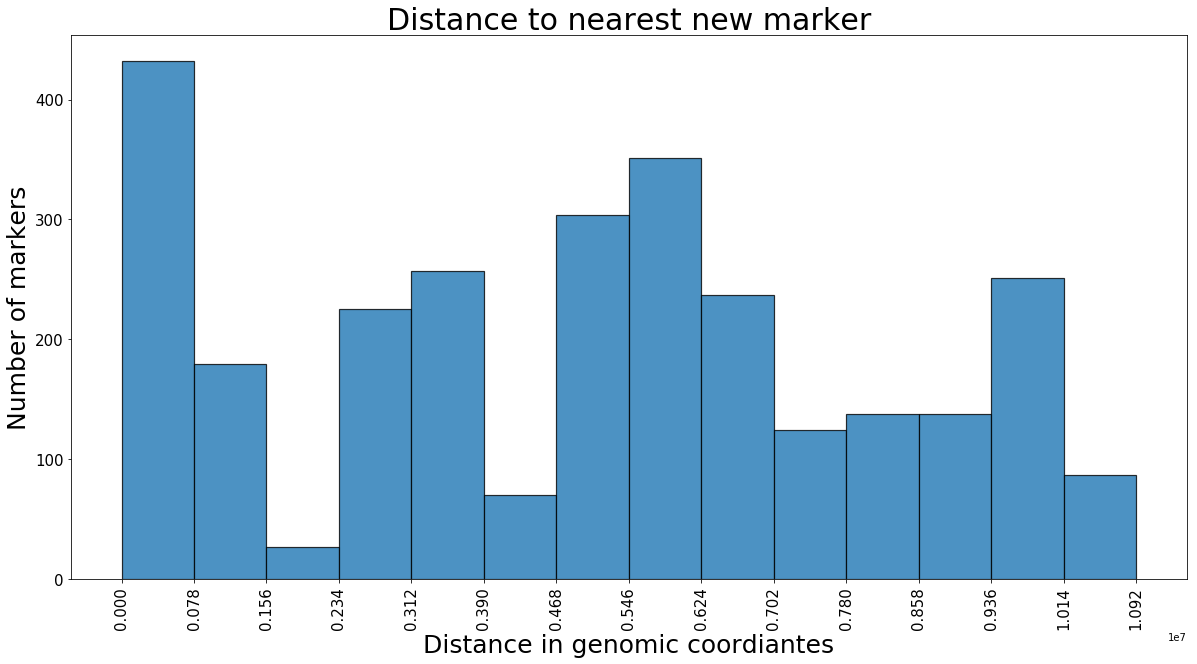

5250077.5


In [61]:
""" How close are old markers to new ones, on average and in general? """

plt.figure(figsize=(20, 10))
counts, bins, patches = plt.hist(min_distances, alpha=0.8, bins=util.bincount_scott(min_distances), edgecolor="black", linewidth=1.2)
plt.title("Distance to nearest new marker", fontsize=30)
plt.xticks(bins, fontsize=15, rotation="vertical")
plt.xlabel("Distance in genomic coordiantes", fontsize=25)
plt.yticks(fontsize=15)
plt.ylabel("Number of markers", fontsize=25)
plt.savefig("./img/distance_to_new_markers.png", dpi=300)
plt.show()

print(np.median(min_distances))

# pd.DataFrame(list(zip(np.round(bins), counts)), columns=["bin_left_border", "num_markers"]).to_csv("./img/distance_to_new_markers.csv", sep='\t', index=False)

In [9]:
""" Dump the interpolated genotypes on disc. """

%%time

predicted_rows = []
for old_marker, nearest_new in old_markers2new_markers.items():
    predicted_rows.append(np.hstack((old_marker, new_gen_df[short2full[nearest_new]].values + 1)))
predicted_df = pd.DataFrame(predicted_rows, columns=np.hstack(("SNP", new_gen_df["strain"])))
predicted_df.to_csv("./data/eQTLs/interpolated_genotypes.csv", sep='\t', index=False)


CPU times: user 4.38 s, sys: 80 ms, total: 4.46 s
Wall time: 4.58 s


## Analyzing new data: eQTLs

In [4]:
""" How many eQTLs are in both real and interpolated data? """

len(np.intersect1d(
    list(map(tuple, qtls_df["eQTLs_interpolated"][["SNP", "gene"]].values)), 
    list(map(tuple, qtls_df["eQTLs_old"][["SNP", "gene"]].values))
))

3672

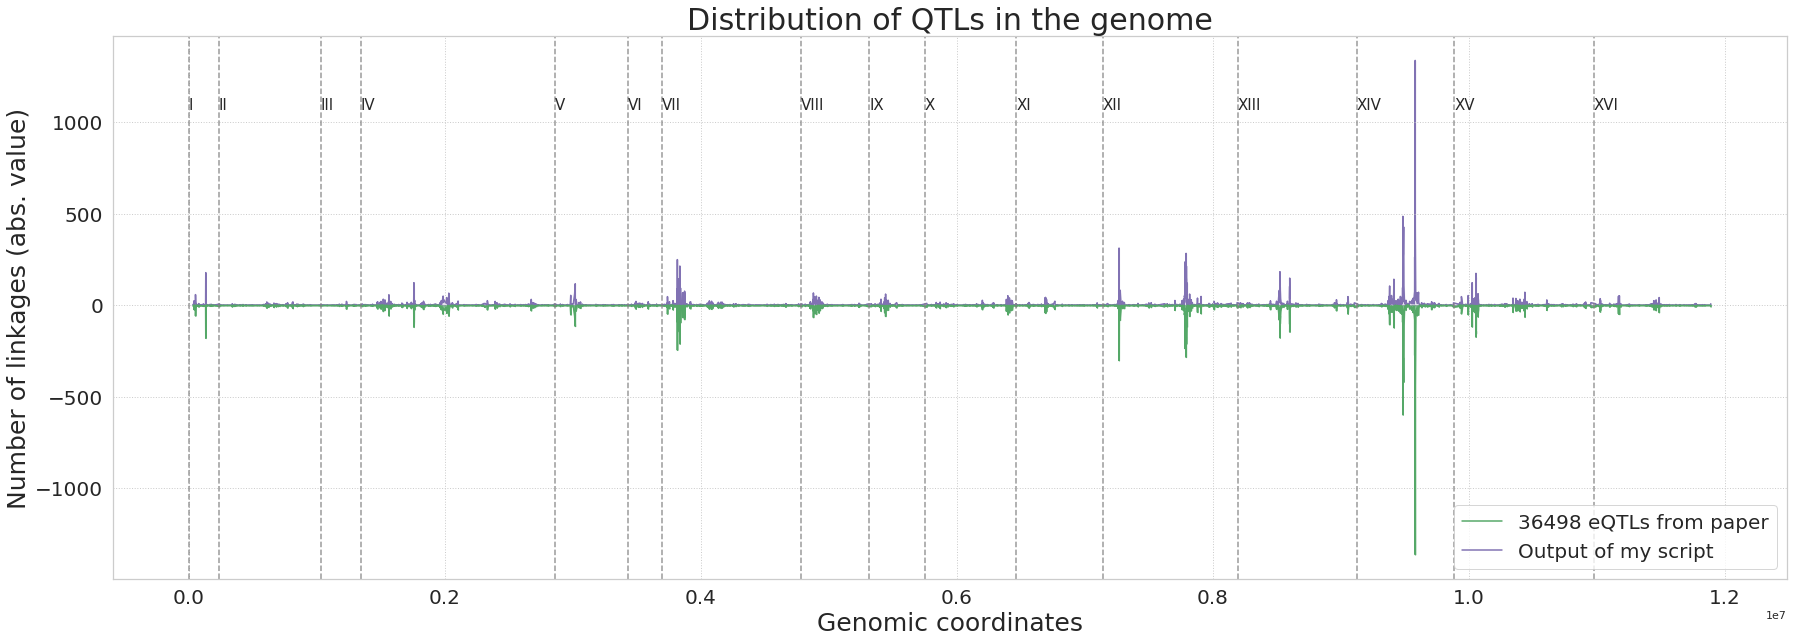

CPU times: user 2.54 s, sys: 43.9 ms, total: 2.59 s
Wall time: 2.59 s


In [37]:
%%time
""" Plot the distributions of each QTL dataset"""
reload(qtls)

sns.set(style="whitegrid")

roman2arabic = {"I":1, "II":2, "III":3, "IV":4, "V":5, "VI":6, "VII":7, "VIII":8, "IX":9, "X":10, "XI":11, "XII":12, "XIII":13, "XIV":14, "XV":15, "XVI":16}
arabic2roman = {val:key for key, val in roman2arabic.items()}

q_value_threshold = 1e-3
with open("./data/genotypes/order_of_markers.pkl", "rb") as pickle_file:
    marker2location = pickle.load(pickle_file)
with open("./data/genotypes/chromosome_endpoints.pkl", "rb") as pickle_file:
    chromosome_endpoints = pickle.load(pickle_file)

old_eQTL_markers, old_eQTL_y = qtls.linkages2gencoords(qtls_df["eQTLs_old"])
# interpolated_eQTL_markers, interpolated_eQTL_y = qtls.linkages2gencoords(qtls_df["eQTLs_interpolated"].query("q_value <= {}".format(q_value_threshold)))
# interpolated_eQTL_markers, interpolated_eQTL_y = qtls.linkages2gencoords(pd.DataFrame(np.vstack(qtl_list), columns=["SNP", "gene"]))
new_eQTL_markers, new_eQTL_y = qtls.linkages2gencoords(qtls_df["eQTLs_new"])
pQTL_markers, pQTL_y = qtls.linkages2gencoords(qtls_df["pQTLs"])
# recomputed_new_eQTL_markers, recomputed_new_eQTL_y = qtls.linkages2gencoords(qtls_df["recomputed_new_eQTLs"][qtls_df["recomputed_new_eQTLs"]["q.value"] <= 1e-32])
# recomputed_new_eQTL_markers, recomputed_new_eQTL_y = qtls.linkages2gencoords(pd.DataFrame(np.vstack(qtl_list), columns=["SNP", "gene"]))
recomputed_qtls_df = pd.read_table("./email_to_albert&bloom/qtls_2018_albert&bloom.csv")[["pmarker", "gene"]]
recomputed_qtls_df.rename(columns={"pmarker":"SNP"}, inplace=True)
recomputed_qtls_df.drop_duplicates(inplace=True)
recomputed_qtls_df["gene"] = recomputed_qtls_df["gene"].apply(networks.convert_to_std)
recomputed_new_eQTL_markers, recomputed_new_eQTL_y = qtls.linkages2gencoords(recomputed_qtls_df)

old_eQTL_x = list(map(marker2location.get, old_eQTL_markers))
# interpolated_eQTL_x = list(map(marker2location.get, interpolated_eQTL_markers))
new_eQTL_x = list(map(marker2location.get, new_eQTL_markers))
pQTL_x = list(map(marker2location.get, pQTL_markers))
recomputed_new_eQTL_x = list(map(marker2location.get, recomputed_new_eQTL_markers)) 

colors_dict = dict(zip(["old_eQTLs", "interpolated_eQTLs", "new_eQTLs", "pQTLs", "recomputed_new_eQTLs"], plt.rcParams['axes.prop_cycle'].by_key()['color'][:5]))

plt.figure(figsize=(30, 10))
plt.title("Distribution of QTLs in the genome", fontsize=30)
for n in range(1, 17):
    plt.axvline(x=chromosome_endpoints[n-1], linestyle='--', color='grey', alpha=0.8)
    plt.text(chromosome_endpoints[n-1], 0.8 * np.max(recomputed_new_eQTL_y), arabic2roman[n], fontsize=15)
# plt.plot(old_eQTL_x, -old_eQTL_y, label="old_eQTLs", color=colors_dict["old_eQTLs"])
# plt.fill_between(old_eQTL_x, -old_eQTL_y, 0, alpha=0.5, color=colors_dict["old_eQTLs"])
# chunks = np.linspace(0, chromosome_endpoints[16], 100)
# vals = np.zeros(len(chunks))
# for i in range(len(chunks) - 1):
#     vals[i] = sum((chunks[i] < val < chunks[i + 1] for val in interpolated_eQTL_x))
# plt.step(chunks, -vals, label="markers in chunk", color=plt.rcParams["axes.prop_cycle"].by_key()["color"][0])
# plt.plot(interpolated_eQTL_x, interpolated_eQTL_y, label="interpolated_eQTLs", alpha=0.7, color=colors_dict["interpolated_eQTLs"])
# plt.fill_between(interpolated_eQTL_x, 0, interpolated_eQTL_y, alpha=0.5, color=colors_dict["interpolated_eQTLs"])
plt.plot(new_eQTL_x, -new_eQTL_y, label="36498 eQTLs from paper", alpha=1, color=colors_dict["new_eQTLs"], zorder=1)
plt.fill_between(new_eQTL_x, -new_eQTL_y, 0, alpha=0.7, color=colors_dict["new_eQTLs"])
# plt.plot(pQTL_x, -pQTL_y, label="pQTLs", alpha=0.7, color=colors_dict["pQTLs"])
# plt.fill_between(pQTL_x, -pQTL_y, 0, alpha=0.5, color=colors_dict["pQTLs"])
plt.plot(recomputed_new_eQTL_x, recomputed_new_eQTL_y, label="Output of my script", alpha=1, color=colors_dict["recomputed_new_eQTLs"], zorder=0)
plt.fill_between(recomputed_new_eQTL_x, 0, recomputed_new_eQTL_y, alpha=0.2, color=colors_dict["recomputed_new_eQTLs"])
plt.xlabel("Genomic coordinates", fontsize=25)
plt.ylabel("Number of linkages (abs. value)", fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20, loc=4)
plt.grid(linestyle="dotted")
plt.savefig("./img/qtl_distributions/qtls_combined_1.png", dpi=300)
plt.show()


In [157]:
for module_name, module_genes in tqdm(modules_dict.items()):
    module_graph = interactome_graph.subgraph(
        np.intersect1d(module_genes, interactome_graph.vs["name"])
    ).simplify()
    module_graph.vs.select(_degree=0).delete()
    if module_graph.vcount() > 0:
        qtls.plot_module_graph(
            destdir="./results/{}/new_eQTLs/".format(modules_type), 
            module_graph=module_graph, 
            qtl_df=qtls_df["eQTLs_new"], 
            filename=module_name
        )

NameError: name 'modules_dict' is not defined

## ModuleQTLs: concept introduction and rationale

In [33]:
for modules_type in ["geneontology", "kegg_modules", "kegg_pathways", "thecellmap"]:
    old_pred_df = pd.read_table("./archive/{}/eQTLs_old/pQTLs_from_eQTLs.csv".format(modules_type)).sort_values(by="module_name")
    interpolated_pred_df = pd.read_table("./archive/{}/eQTLs_interpolated/pQTLs_from_eQTLs.csv".format(modules_type)).sort_values(by="module_name")
    
    plt.figure(figsize=(20, 10))
    plt.title("{}: predicting pQTLs via eQTLs & PPIN".format(modules_type), fontsize=25)
    plt.plot(old_pred_df["overlap_ratio"].values, label="old_eQTLs")
    plt.fill_between(range(len(old_pred_df["overlap_ratio"].values)), 0, old_pred_df["overlap_ratio"].values, alpha=0.3)
    plt.plot(-interpolated_pred_df["overlap_ratio"].values, label="interpolated_eQTLs")
    plt.fill_between(range(len(interpolated_pred_df["overlap_ratio"].values)), -interpolated_pred_df["overlap_ratio"].values, 0, alpha=0.3)
    plt.xlabel("Number of functional module in sorted order", fontsize=15)
    plt.ylabel("Percentage of pQTLs predicted correctly", fontsize=15)
    plt.legend(fontsize=15)
    plt.savefig("./img/pQTL_prediction/{}_pQTLs_prediction_old_interpolated.png".format(modules_type), dpi=300)
    # plt.show()
    plt.close()


In [35]:
for modules_type in ["geneontology", "kegg_modules", "kegg_pathways", "thecellmap"]:
    old_intersection_df = pd.read_table("./archive/{}/eQTLs_old/eQTL_pQTL_intersection.csv".format(modules_type))
    interpolated_intersection_df = pd.read_table("./archive/{}/eQTLs_interpolated/eQTL_pQTL_intersection.csv".format(modules_type))
    
    plt.figure(figsize=(20, 10))
    plt.title("{}: eQTL/pQTL intersection".format(modules_type), fontsize=25)
    plt.plot(old_intersection_df["q_value_cutoff"].values, old_intersection_df["real_modules"].values, label="old eQTLs, real modules")
    # plt.fill_between(range(old_intersection_df.shape[0]), 0, old_intersection_df["real_modules"].values, alpha=0.3)
    plt.plot(old_intersection_df["q_value_cutoff"].values, old_intersection_df["random_modules"].values, label="old eQTLs, random modules")
    # plt.fill_between(range(old_intersection_df.shape[0]), 0, old_intersection_df["random_modules"].values, alpha=0.3)
    plt.plot(interpolated_intersection_df["q_value_cutoff"].values, interpolated_intersection_df["real_modules"].values, label="interpolated eQTLs, real modules")
    # plt.fill_between(range(interpolated_intersection_df.shape[0]), -interpolated_intersection_df["real_modules"].values, 0, alpha=0.3)
    plt.plot(interpolated_intersection_df["q_value_cutoff"].values, interpolated_intersection_df["random_modules"].values, label="interpolated eQTLs, random modules")
    # plt.fill_between(range(interpolated_intersection_df.shape[0]), -interpolated_intersection_df["random_modules"].values, 0, alpha=0.3)
    plt.xscale('log')
    plt.xlabel("q-value threshold", fontsize=15)
    plt.ylabel("Jaccard coefficient", fontsize=15)
    plt.legend(fontsize=15)
    plt.savefig("./img/eQTL_pQTL_intersection/{}.png".format(modules_type), dpi=300)
    # plt.show()
    plt.close()


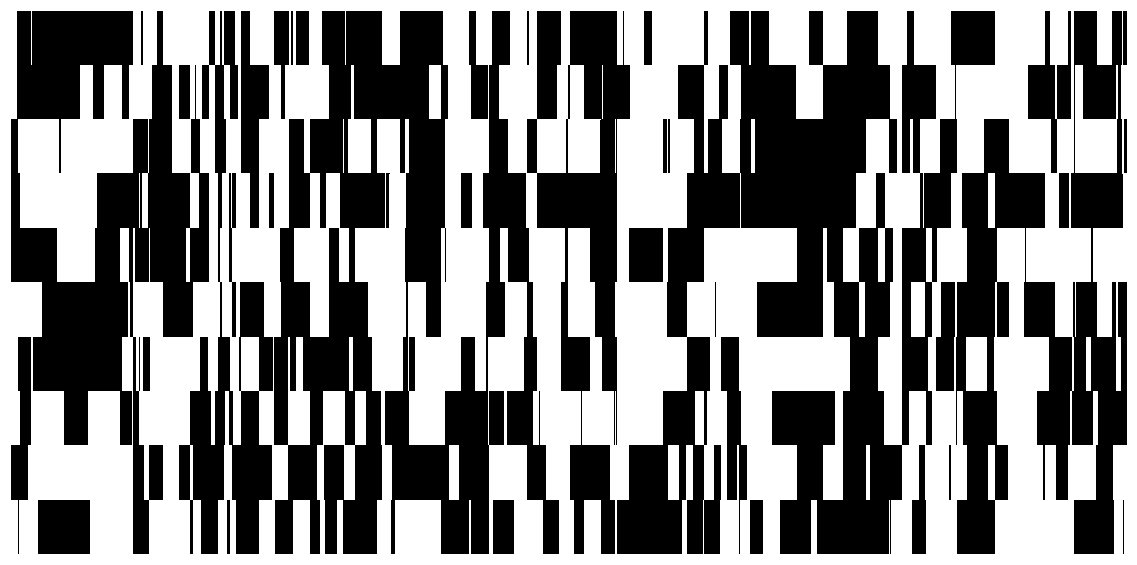

In [5]:
import seaborn as sns

plt.figure(figsize=(20, 10))
frame_start = np.random.RandomState().choice(range(1, genotypes_df["eQTLs_new"].shape[1] // 2))
frame_end = frame_start + 10
genotype_rows = genotypes_df["eQTLs_new"].iloc[:, frame_start:frame_end].values.T
genotype_rows[genotype_rows == 2] = 1
# genotype_rows += stats.uniform().rvs(size=genotype_rows.shape)
sns.heatmap(genotype_rows, xticklabels=False, yticklabels=False, cbar=False, cmap="Greys");
plt.savefig("./img/inheritance_patterns")
# plt.show()


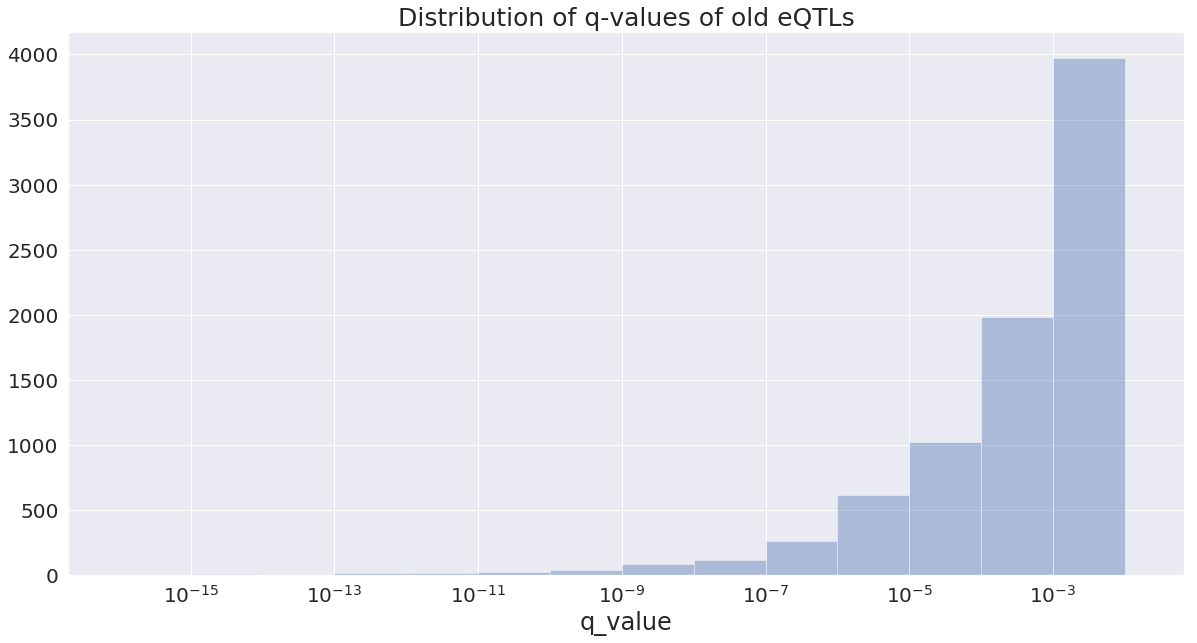

In [28]:
qtls_df["eQTLs_new_generated"] = pd.read_table("./data/eQTLs/new_qtls_from_scratch.csv")
qtls_df["eQTLs_new_generated"].columns = ["SNP", "gene", "p_value", "q_value"] 


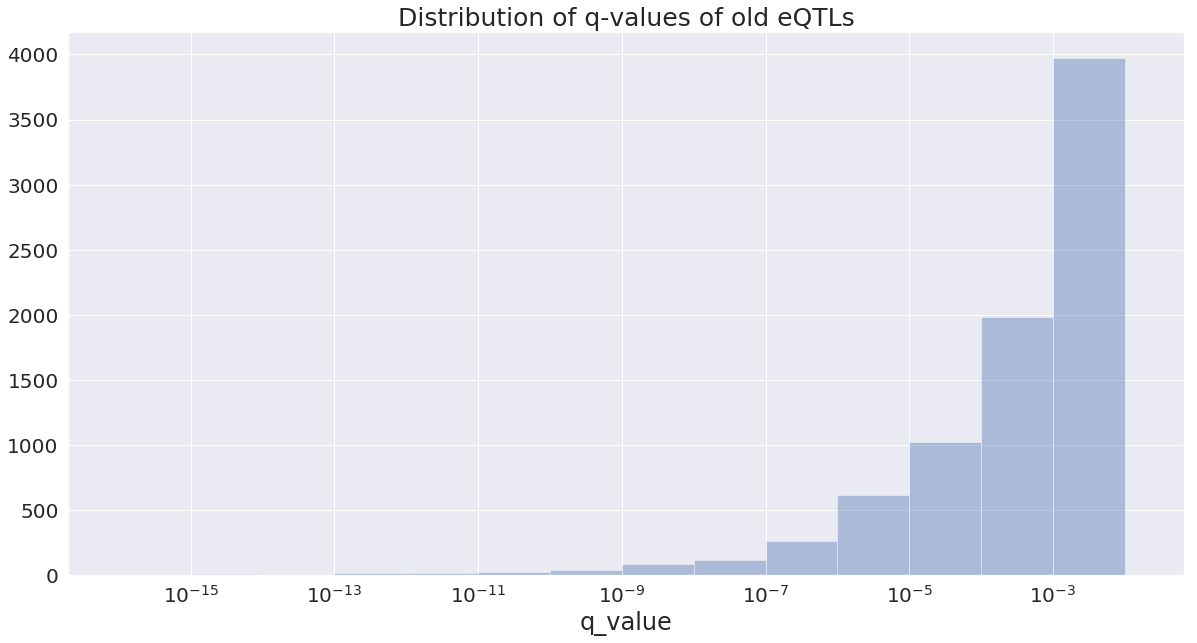

In [70]:
plt.figure(figsize=(20, 10))
plt.title("Distribution of q-values of old eQTLs", fontsize=25)
plt.xscale("log")
sns.set(color_codes=True)
sns.distplot(bins=10.**np.arange(-16, -1), a=qtls_df["pQTLs"]["q_value"], kde=False)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.savefig("./img/qtl_computing/pQTLs_old.png", dpi=300)
plt.show()
plt.close()


In [96]:
fdr_cutoffs = np.append(10. ** np.arange(-16, -1), 0.05)
i = 0
partial_leq = np.zeros_like(fdr_cutoffs)
for i, q_thr in enumerate(fdr_cutoffs):
    partial_leq[i] = len(
        set(map(tuple, qtls_df["eQTLs_old"].query("q_value <= {}".format(q_thr))[["SNP", "gene"]].values)) & 
        set(map(tuple, qtls_df["pQTLs"].query("q_value <= {}".format(q_thr))[["SNP", "gene"]].values))
    )
partial_leq = np.cumsum(partial_leq)

In [97]:
pd.DataFrame(
    np.column_stack((fdr_cutoffs, partial_leq)),
    columns=["q_value_threshold", "linkages_below"]
)

,q_value_threshold,linkages_below
0,1.000000e-16,0.0
1,1.000000e-15,0.0
2,1.000000e-14,0.0
3,1.000000e-13,0.0
4,1.000000e-12,0.0
5,1.000000e-11,9.0
6,1.000000e-10,33.0
7,1.000000e-09,63.0
8,1.000000e-08,119.0
9,1.000000e-07,190.0


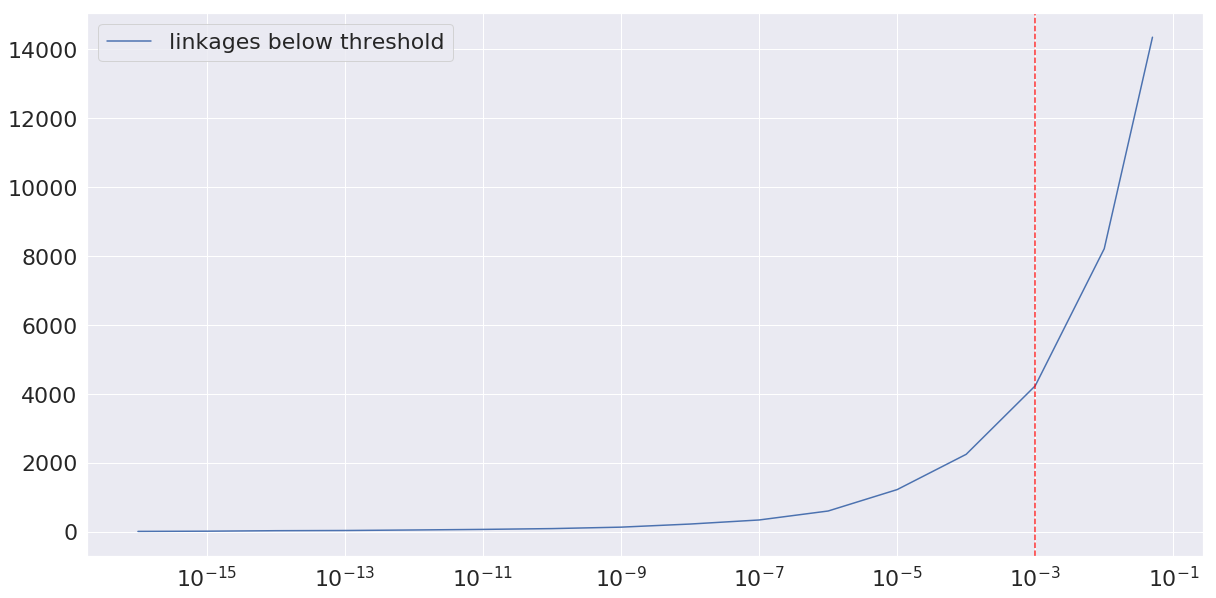

In [75]:
plt.figure(figsize=(20, 10))
plt.xscale("log")
sns.set(font_scale=2)
sns.lineplot(fdr_cutoffs, partial_leq, label="linkages below threshold")
plt.axvline(x=1e-3, linestyle="--", color="red", alpha=0.8)
plt.savefig("./img/qtl_computing/pQTLs_old_lineplot.png", dpi=300)
plt.show()
plt.close()


In [ ]:
""" Generating data for GFLasso """

module_genes = sorted(
    set(modules_dict["Respiration, oxidative phosphorylation, mitochondrial targeting"]) 
    & set(interactome_graph.vs["name"])
    & set(expression_df["eQTLs_old"].dropna()["gene"].values)
)
linked_markers = sorted(qtls_df["eQTLs_old"][qtls_df["eQTLs_old"]["gene"].isin(module_genes)]["SNP"].values)
genotypes = genotypes_df["eQTLs_old"][genotypes_df["eQTLs_old"]["SNP"].isin(linked_markers)].sort_values(by="SNP")
genotypes.dropna(inplace=True)
for colname in genotypes.columns[1:]:
    genotypes[colname] = genotypes[colname] - 1
expression = expression_df["eQTLs_old"][expression_df["eQTLs_old"]["gene"].isin(module_genes)].dropna().sort_values(by="gene")
genotypes.T.to_csv("./genotypes.csv", sep='\t', index=False)
expression.T.to_csv("./expression.csv", sep='\t', index=False)

incidence_matrix = np.zeros(shape=(len(module_genes), len(module_genes)), dtype=int)
for i in range(incidence_matrix.shape[0]):
    for j in range(incidence_matrix.shape[1]):
        if i != j and interactome_graph.are_connected(module_genes[i], module_genes[j]):
            incidence_matrix[i][j] = 1
np.savetxt(fname="./incidence_matrix.txt", X=incidence_matrix, fmt="%d")


CPU times: user 15.8 ms, sys: 0 ns, total: 15.8 ms
Wall time: 15.5 ms


In [3]:
%%time
""" Reproducing QTL mapping technique from https://elifesciences.org/articles/35471 """

from sklearn import preprocessing
import warnings

random.seed(time.time())
chromosome2markers = {i : genotypes_df["eQTLs_old"].groupby("chromosome").get_group(i)["SNP"] for i in range(1, 17)}


def nan_to_zero_then_scale(data, inplace=False, axis=1):
    """
    :param data: numpy ndarray; numerical at best, but type-casting is taken care of
    :param axis: integer; axis to scale along   
    :param inplace: boolean; whether to create a copy or to modify the matrix in-place
    :return: numerical numpy ndarray of the same shape with zero mean and unit variance along specified axis
    """
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        return preprocessing.scale(
            np.nan_to_num(data.astype(np.float32), copy=not inplace),
            axis=axis, copy=not inplace
        )


def linkage_LOD_scores(genotypes_matrix, expression_matrix, inplace=False):
    """
    LOD_score(gene, marker) = -n_strains * log(1 - r^2) / (2 log(10)),
    where r is the Pearson correlation coefficient between vectors of
    gene's expression values and marker's inheritance patterns among strains.
    Exact formula for LOD score was taken from this paper: https://elifesciences.org/articles/35471  
    
    :param genotypes_matrix: numerical matrix, dimensions = n_markers x n_strains; 
                             we used -1 for BY allele and 1 for RM allele, but this choice 
                             of numerical representation is rather arbitrary  
    :param expression_matrix: numerical matrix, dimensions = n_genes x n_strains
    :param inplace_flag: boolean flag, introduces side effects, but saves memory by pre-processing matrices in-place  
    :return: numerical n_genes x n_markers matrix; (i, j)-th entry is a LOD-score of (gene_i, marker_j) linkage.
    
    """
    # if samples X and Y are centered and scaled, their Pearson's r-coefficient
    # is simply (their dot product) / (samples'_size - 1).
    # Matrix multiplication can be used to speed up the computation of Pearson's r-coefficients
    # between rows of genotypes_matrix and rows of expression matrix.
    n_strains = genotypes_matrix.shape[1]
    pearsonr = np.matmul(
        nan_to_zero_then_scale(expression_matrix, inplace),
        nan_to_zero_then_scale(genotypes_matrix, inplace).T
    ) / (n_strains - 1)
    return -n_strains * np.log(1 - pearsonr ** 2) / (2 * np.log(10))


""" Finding peak LOD-score-per-chromosome markers for each gene as in https://elifesciences.org/articles/35471 """


import sklearn.linear_model
def compute_residual_expression(expression_df, genotypes_df, gene2model_components, covariates_df=None):
    """
    Fits a linear model: E = QG + R, 
        where E stands for expression profile of a particular gene, 
        G — for markers (one or several) with peak LOD-scores for that gene,
        Q — for coefficients of the linear model,
        R — for residual expression of that gene
    :param expression_df: pandas dataframe; columns — "["gene"] + phenotypes"
    :param genotypes_df: pandas dataframe; columns — "["SNP"] + phenotypes + ["chromosome", "position"]"
                                -1 stands for BY allele, 1 — for RM allele, 0 — for NaN 
    :param gene2model_components: dict: str —> list; mapping between genes and markers with peak LOD-scores for those genes.   
                                    Inheritance patterns of those markers are predictors in linear model. 
    :return: pandas dataframe; residual expression values for genes in initial expression dataframe
    """
    
    covariates_provided = covariates_df is not None
    expression_matrix = np.nan_to_num(expression_df.values[:, 1:].astype(np.float32))
    genotypes_matrix = nan_to_zero_then_scale(genotypes_df.values[:, 1:-2].astype(np.float32) - 1)
    covariates_mx = np.matrix(nan_to_zero_then_scale(np.ravel(covariates_df["batch"].values), axis=0)).T \
                        if covariates_provided else None
    
    residual_expression = []
    for i, gene in enumerate(expression_df["gene"]):
        X = None
        y = expression_matrix[expression_df["gene"] == gene].T
        large_effect_markers = gene2model_components[gene]
        if len(large_effect_markers) != 0:
            segregant_genotypes_mx = genotypes_matrix[genotypes_df["SNP"].isin(large_effect_markers)].T
            X = np.column_stack((covariates_mx, segregant_genotypes_mx)) \
                if covariates_provided else segregant_genotypes_mx
        if X is None:
            residual_expression.append(np.ravel(y))
        else:
            # Otherwise a linear model gets fitted.
            lm = sklearn.linear_model.LinearRegression()
            lm.fit(X, y)
            # New expression profile is a vector of residuals in the language of linear models.
            residual_expression.append(np.ravel(y - lm.predict(X)))
            # return gene, large_effect_markers, X, y, lm, residual_expression
    # Dataframe with residual expression values is later used instead of the original dataframe
    residual_expression_dataframe = pd.DataFrame(
        np.column_stack(
            (expression_df["gene"],
             np.vstack(residual_expression))
        ), 
        columns=expression_df.columns
    )
    return residual_expression_dataframe


/home/vvi/anaconda3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/vvi/anaconda3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


CPU times: user 135 ms, sys: 39 ms, total: 174 ms
Wall time: 572 ms


In [23]:
%%time
""" Preprocessing data as in https://elifesciences.org/articles/35471 """

# expression_dataframe = expression_df["pQTLs"].drop(["BY", "RM"], axis=1)
expression_dataframe = expression_df["eQTLs_new"]
# gene_occurences = collections.Counter(expression_dataframe["gene"].values)
# expression_dataframe = expression_dataframe[[
#     gene_occurences[gene] == 1 for gene in expression_dataframe["gene"]
# ]]
genotypes_dataframe = pd.read_table("./data/eQTLs/genotypes_2018_filtered.csv")
# genotypes_dataframe = genotypes_df["pQTLs"].drop(["BY", "RM"], axis=1)
covariates_dataframe = pd.read_table("./data/eQTLs/covariates_2018.csv")


CPU times: user 740 ms, sys: 40 ms, total: 780 ms
Wall time: 779 ms


In [5]:
def adjust_expression_data(chromosome_id, expression_df, genotypes_df, covariates_df=None, verbose=False):
    gene2rownum = {gene : i for i, gene in enumerate(expression_df["gene"].values)}
    remaining_chromosomes_df = genotypes_df.query("chromosome != {}".format(chromosome_id))
    used_markers_mask = np.zeros(
        shape=(expression_df.shape[0], remaining_chromosomes_df.shape[0]), 
        dtype=np.bool
    )
    
    preprocessing_iterations = 3
    residual_expression_df = expression_df
    gene2model_markers = collections.defaultdict(list)
    for current_iter in range(preprocessing_iterations):
        if verbose:
            print("Iteration {} of preprocessing".format(current_iter))
        genotypes_mx = nan_to_zero_then_scale(remaining_chromosomes_df.values[:, 1:-2].astype(np.float32) - 1)
        expression_mx = np.nan_to_num(residual_expression_df.values[:, 1:].astype(np.float32))

        LOD_scores = np.ma.array(linkage_LOD_scores(genotypes_mx, expression_mx), mask=used_markers_mask)
        peak_LOD_marker_ids = np.ma.argmax(LOD_scores, axis=1)
        peak_LOD_values = np.ma.max(LOD_scores, axis=1)

        candidate_linkages_df = pd.DataFrame(
            [(remaining_chromosomes_df["SNP"].values[peak_LOD_marker_ids[i]],
              gene, peak_LOD_values[i], peak_LOD_marker_ids[i])
             for i, gene in enumerate(expression_df["gene"])],
            columns=["SNP", "gene", "LOD", "marker_id"]
        ).query("LOD >= 3.5")

        for i, row in candidate_linkages_df.iterrows():
            gene2model_markers[row["gene"]].append(row["SNP"])
            used_markers_mask[gene2rownum[row["gene"]]][row["marker_id"]] = True
            
        residual_expression_df = compute_residual_expression(
            expression_df, remaining_chromosomes_df,
            gene2model_markers, covariates_df
        )
    return residual_expression_df


In [24]:

%%time
""" Mapping eQTLs as in https://elifesciences.org/articles/35471 """


def map_qtls(expression_dataframe, genotypes_dataframe, covariates_dataframe=None):
    qtl_list = []
    for chromosome_id in range(1, 17):
        chromosome_dataframe = genotypes_dataframe.groupby("chromosome").get_group(chromosome_id)
        
        # Find background QTLs (as described in the preprocessing step) and adjust expression values
        # to cancel out their effect by adding those QTLs to linear model for expression of a gene they
        # influence, fitting it and using residuals instead of original expression data.

        # residual_expression_dataframe = expression_dataframe        
        residual_expression_dataframe = adjust_expression_data(
            chromosome_id, 
            expression_dataframe, genotypes_dataframe, 
            covariates_dataframe,
            verbose=True
        )
        
        used_markers_mask = np.zeros(
            shape=(expression_dataframe.shape[0], chromosome_dataframe.shape[0]), 
            dtype=np.bool
        )
        gene2rownum = {gene : i for i, gene in enumerate(expression_dataframe["gene"].values)}
        remaining_genes_mask = np.ones_like(expression_dataframe["gene"].values, dtype=np.bool)
        gene2model_components = collections.defaultdict(list)
        
        current_iter = 1
        finding_linkages = True
        while(finding_linkages):
            print("Iteration {} of QTL mapping:".format(current_iter))
            genotypes_matrix = nan_to_zero_then_scale(chromosome_dataframe.values[:, 1:-2].astype(np.float32) - 1)
            expression_matrix = np.nan_to_num(residual_expression_dataframe.values[:, 1:].astype(np.float32))

            LOD_scores = np.ma.array(linkage_LOD_scores(genotypes_matrix, expression_matrix), mask=used_markers_mask[remaining_genes_mask, :])
            peak_LOD_marker_ids = np.ma.argmax(LOD_scores, axis=1)
            peak_LOD_values = np.ma.max(LOD_scores, axis=1)

            # All (marker, gene) pairs with the highest LOD score per gene are initially considered to be QTLs 
            candidate_linkages_dataframe = pd.DataFrame(
                [(chromosome_dataframe["SNP"].values[peak_LOD_marker_ids[i]], gene, peak_LOD_values[i], peak_LOD_marker_ids[i])
                 for i, gene in enumerate(residual_expression_dataframe["gene"])],
                columns=["SNP", "gene", "LOD", "marker_id"]
            )
            
            # Then LOD-score significance threshold is derived using permutations test.
            # There are 151 threshold candidates at the moment, ranging from 1.5 to 9 with step value of 0.05.
            # There are 1000 randomization iterations for each threshold.  
            # Phenotypes are permuted on each iteration, while the genotypes remain the same.
            # Then LOD-scores are calculated. Markers with peak LOD-per-gene with LOD-scores higher than current threshold get counted. 
            # Average of those counts is an expected number of linkages with LOD-scores above current threshold.
            # The lowest LOD-score threshold, such that the ratio of expected number of linkages above that threshold
            # to the observed number of such linkages is less than 0.05, is taken as a significance threshold.

            LOD_thresholds = np.arange(1.5, 9.05, 0.05)
            significance_threshold = np.nan
            n_permutations = 100
            
            for fdr_cutoff in LOD_thresholds:
                observed = candidate_linkages_dataframe.query("LOD >= {}".format(fdr_cutoff)).shape[0]
                if observed == 0:
                    break
                random_linkages_in_total = 0
                for _ in range(n_permutations):
                    column_permutation = np.random.permutation(range(expression_matrix.shape[1]))
                    permuted_expression_matrix = expression_matrix[:, column_permutation]
                    permuted_LOD_scores = linkage_LOD_scores(genotypes_matrix, permuted_expression_matrix)
                    permuted_peak_LOD_values = np.max(permuted_LOD_scores, axis=1)
                    random_linkages_in_total += np.count_nonzero(permuted_peak_LOD_values >= fdr_cutoff)
                expected = random_linkages_in_total / n_permutations
                if expected >= observed:
                    break
                print("{:.3}: {} <> {}\t{}".format(fdr_cutoff, expected, observed, expected / observed))
                if expected / observed < 0.05:
                    significance_threshold = fdr_cutoff
                    break
            if np.isnan(significance_threshold):
                finding_linkages = False
                print("Halting processing of chromosome {}".format(chromosome_id))
            else:
                candidate_linkages_dataframe = candidate_linkages_dataframe.query("LOD >= {}".format(significance_threshold))
                qtl_list.extend(candidate_linkages_dataframe[["SNP", "gene"]].values)
                print("Chromosome: {}\tratio: {:.2}\t linkages: {}".format(
                    chromosome_id,
                    significance_threshold,
                    candidate_linkages_dataframe.shape[0])
                )
                for i, row in candidate_linkages_dataframe.iterrows():
                    gene2model_components[row["gene"]].append(row["SNP"])
                    used_markers_mask[gene2rownum[row["gene"]]][row["marker_id"]] = True 
                residual_expression_dataframe = compute_residual_expression(
                    expression_dataframe, chromosome_dataframe, gene2model_components
                )
                residual_expression_dataframe = residual_expression_dataframe[
                    residual_expression_dataframe["gene"].isin(
                       [gene_name for gene_name, large_effect_markers in gene2model_components.items() 
                        if len(large_effect_markers) == current_iter]
                    ) 
                ]
                print("Genes to test after iteration {}:\t{}".format(current_iter, residual_expression_dataframe.shape[0]))
                remaining_genes_mask.fill(False)
                remaining_genes_mask[residual_expression_dataframe.index] = True
            current_iter += 1
    unique_qtls_list = list(set(map(tuple, qtl_list)))
    return np.asarray(unique_qtls_list, dtype=np.str)


qtl_list = map_qtls(expression_dataframe, genotypes_dataframe, covariates_dataframe) 


Iteration 0 of preprocessing


Iteration 1 of preprocessing


Iteration 2 of preprocessing


Iteration 1 of QTL mapping:


1.5: 656.75 <> 1301	0.504803996925442


1.55: 661.58 <> 1217	0.5436154478225144


1.6: 478.66 <> 1136	0.42135563380281693


1.65: 485.08 <> 1065	0.45547417840375587


1.7: 393.86 <> 1002	0.3930738522954092


1.75: 427.11 <> 936	0.4563141025641026


1.8: 387.67 <> 874	0.443558352402746


1.85: 293.5 <> 824	0.3561893203883495


1.9: 278.07 <> 780	0.3565


1.95: 297.28 <> 750	0.3963733333333333


2.0: 277.74 <> 709	0.3917348377997179


2.05: 213.22 <> 683	0.31218155197657393


2.1: 158.39 <> 658	0.2407142857142857


2.15: 139.4 <> 631	0.22091917591125199


2.2: 168.14 <> 605	0.2779173553719008


2.25: 110.6 <> 579	0.19101899827288427


2.3: 101.6 <> 545	0.18642201834862385


2.35: 102.94 <> 525	0.19607619047619046


2.4: 82.51 <> 503	0.1640357852882704


2.45: 72.91 <> 477	0.15285115303983227


2.5: 76.54 <> 455	0.16821978021978023


2.55: 67.5 <> 440	0.1534090909090909


2.6: 55.81 <> 417	0.1338369304556355


2.65: 39.74 <> 401	0.09910224438902744


2.7: 52.16 <> 383	0.13618798955613576


2.75: 35.61 <> 372	0.0957258064516129


2.8: 35.81 <> 360	0.09947222222222223


2.85: 37.82 <> 351	0.10774928774928776


2.9: 25.42 <> 338	0.07520710059171598


2.95: 23.04 <> 329	0.07003039513677811


3.0: 25.22 <> 320	0.0788125


3.05: 23.7 <> 316	0.075


3.1: 18.13 <> 306	0.059248366013071894


3.15: 15.86 <> 296	0.05358108108108108


3.2: 14.82 <> 290	0.05110344827586207


3.25: 13.93 <> 285	0.04887719298245614
Chromosome: 1	ratio: 3.3	 linkages: 285


Genes to test after iteration 1:	285
Iteration 2 of QTL mapping:


Halting processing of chromosome 1
Iteration 0 of preprocessing


Iteration 1 of preprocessing


Iteration 2 of preprocessing


Iteration 1 of QTL mapping:


1.5: 1700.13 <> 2139	0.7948246844319776


1.55: 1688.28 <> 2019	0.8361961367013373


1.6: 1348.55 <> 1931	0.6983687208700156


1.65: 1360.38 <> 1813	0.7503474903474904


1.7: 1213.78 <> 1717	0.706919044845661


1.75: 1090.84 <> 1644	0.6635279805352797


1.8: 1024.76 <> 1566	0.6543805874840357


1.85: 767.64 <> 1507	0.5093828798938288


1.9: 846.49 <> 1435	0.5898885017421602


1.95: 763.93 <> 1365	0.5596556776556776


2.0: 655.12 <> 1300	0.5039384615384616


2.05: 598.63 <> 1235	0.48472064777327933


2.1: 497.29 <> 1181	0.4210753598645216


2.15: 473.3 <> 1131	0.4184792219274978


2.2: 426.89 <> 1078	0.39600185528756954


2.25: 421.22 <> 1034	0.40736943907156675


2.3: 348.38 <> 985	0.3536852791878173


2.35: 282.9 <> 946	0.29904862579281183


2.4: 284.9 <> 916	0.3110262008733624


2.45: 290.17 <> 869	0.3339125431530495


2.5: 236.41 <> 832	0.2841466346153846


2.55: 184.48 <> 807	0.22859975216852538


2.6: 177.6 <> 780	0.2276923076923077


2.65: 166.27 <> 758	0.21935356200527706


2.7: 155.0 <> 744	0.20833333333333334


2.75: 138.01 <> 726	0.19009641873278235


2.8: 132.7 <> 704	0.18849431818181817


2.85: 119.24 <> 679	0.17561119293078056


2.9: 98.42 <> 661	0.14889561270801815


2.95: 74.39 <> 638	0.11659874608150471


3.0: 61.9 <> 618	0.10016181229773463


3.05: 68.98 <> 598	0.11535117056856188


3.1: 74.44 <> 586	0.12703071672354949


3.15: 53.82 <> 575	0.0936


3.2: 32.35 <> 558	0.057974910394265236


3.25: 37.69 <> 552	0.06827898550724637


3.3: 36.23 <> 535	0.06771962616822429


3.35: 29.78 <> 520	0.057269230769230774


3.4: 33.69 <> 510	0.06605882352941177


3.45: 29.11 <> 495	0.05880808080808081


3.5: 18.56 <> 479	0.038747390396659705
Chromosome: 2	ratio: 3.5	 linkages: 479


Genes to test after iteration 1:	479
Iteration 2 of QTL mapping:


1.5: 146.88 <> 217	0.6768663594470046


1.55: 136.99 <> 206	0.665


1.6: 114.33 <> 196	0.5833163265306123


1.65: 109.7 <> 187	0.5866310160427808


1.7: 99.78 <> 182	0.5482417582417582


1.75: 91.79 <> 170	0.5399411764705883


1.8: 79.35 <> 162	0.48981481481481476


1.85: 73.34 <> 155	0.47316129032258064


1.9: 64.16 <> 144	0.44555555555555554


1.95: 63.96 <> 138	0.46347826086956523


2.0: 55.03 <> 132	0.41689393939393943


2.05: 48.05 <> 125	0.38439999999999996


2.1: 43.28 <> 119	0.36369747899159666


2.15: 40.21 <> 109	0.3688990825688073


2.2: 36.17 <> 105	0.3444761904761905


2.25: 32.46 <> 103	0.3151456310679612


2.3: 28.39 <> 96	0.29572916666666665


2.35: 27.17 <> 91	0.2985714285714286


2.4: 25.01 <> 86	0.29081395348837213


2.45: 23.09 <> 82	0.2815853658536585


2.5: 20.75 <> 78	0.266025641025641


2.55: 16.39 <> 74	0.2214864864864865


2.6: 14.76 <> 69	0.21391304347826087


2.65: 14.22 <> 67	0.21223880597014927


2.7: 13.03 <> 62	0.21016129032258063


2.75: 10.84 <> 56	0.19357142857142856


2.8: 10.26 <> 52	0.1973076923076923


2.85: 11.03 <> 51	0.21627450980392154


2.9: 10.58 <> 49	0.21591836734693878


2.95: 7.11 <> 47	0.15127659574468086


3.0: 6.32 <> 45	0.14044444444444446


3.05: 4.91 <> 41	0.11975609756097562


3.1: 4.78 <> 38	0.12578947368421053


3.15: 4.3 <> 37	0.11621621621621621


3.2: 4.33 <> 31	0.1396774193548387


3.25: 3.85 <> 29	0.1327586206896552


3.3: 3.27 <> 29	0.11275862068965517


3.35: 2.86 <> 26	0.11


3.4: 3.16 <> 25	0.1264


3.45: 2.63 <> 25	0.1052


3.5: 2.28 <> 25	0.09119999999999999


3.55: 2.6 <> 24	0.10833333333333334


3.6: 1.66 <> 21	0.07904761904761905


3.65: 1.4 <> 20	0.06999999999999999


3.7: 1.4 <> 20	0.06999999999999999


3.75: 1.32 <> 19	0.06947368421052631


3.8: 1.1 <> 18	0.061111111111111116


3.85: 1.13 <> 17	0.06647058823529411


3.9: 0.78 <> 16	0.04875
Chromosome: 2	ratio: 3.9	 linkages: 16


Genes to test after iteration 2:	16
Iteration 3 of QTL mapping:


1.5: 4.81 <> 9	0.5344444444444444


1.55: 4.53 <> 8	0.56625


1.6: 3.91 <> 7	0.5585714285714286


1.65: 3.37 <> 6	0.5616666666666666


1.7: 3.62 <> 6	0.6033333333333334


1.75: 2.64 <> 4	0.66


Halting processing of chromosome 2
Iteration 0 of preprocessing


Iteration 1 of preprocessing


Iteration 2 of preprocessing


Iteration 1 of QTL mapping:


1.5: 938.52 <> 1125	0.83424


1.55: 866.06 <> 1039	0.8335514918190567


1.6: 876.97 <> 949	0.9240990516332982


1.65: 690.28 <> 878	0.7861958997722095


1.7: 631.01 <> 809	0.7799876390605686


1.75: 600.07 <> 741	0.8098110661268557


1.8: 490.16 <> 689	0.7114078374455733


1.85: 483.71 <> 633	0.7641548183254344


1.9: 384.85 <> 598	0.643561872909699


1.95: 357.32 <> 543	0.65804788213628


2.0: 356.5 <> 509	0.7003929273084479


2.05: 314.39 <> 468	0.6717735042735042


2.1: 258.51 <> 429	0.6025874125874126


2.15: 238.0 <> 404	0.5891089108910891


2.2: 175.15 <> 382	0.4585078534031414


2.25: 184.12 <> 358	0.5143016759776536


2.3: 159.5 <> 346	0.46098265895953755


2.35: 192.47 <> 326	0.590398773006135


2.4: 104.05 <> 310	0.33564516129032257


2.45: 122.37 <> 298	0.41063758389261745


2.5: 118.14 <> 283	0.4174558303886926


2.55: 97.98 <> 273	0.3589010989010989


2.6: 91.05 <> 259	0.35154440154440153


2.65: 63.08 <> 252	0.2503174603174603


2.7: 81.35 <> 239	0.3403765690376569


2.75: 41.24 <> 224	0.18410714285714286


2.8: 58.26 <> 214	0.2722429906542056


2.85: 45.67 <> 208	0.2195673076923077


2.9: 41.82 <> 201	0.2080597014925373


2.95: 25.07 <> 192	0.13057291666666668


3.0: 34.0 <> 187	0.18181818181818182


3.05: 33.24 <> 183	0.18163934426229508


3.1: 17.77 <> 183	0.09710382513661202


3.15: 21.12 <> 173	0.12208092485549134


3.2: 21.58 <> 170	0.12694117647058822


3.25: 27.69 <> 166	0.16680722891566266


3.3: 34.04 <> 165	0.2063030303030303


3.35: 12.76 <> 160	0.07975


3.4: 16.72 <> 159	0.10515723270440251


3.45: 10.66 <> 153	0.06967320261437909


3.5: 8.6 <> 151	0.05695364238410596


3.55: 22.12 <> 149	0.14845637583892618


3.6: 17.5 <> 147	0.11904761904761904


3.65: 6.19 <> 146	0.04239726027397261
Chromosome: 3	ratio: 3.7	 linkages: 146


Genes to test after iteration 1:	146
Iteration 2 of QTL mapping:


1.5: 24.27 <> 28	0.8667857142857143


1.55: 21.47 <> 26	0.8257692307692307


1.6: 20.22 <> 22	0.9190909090909091


1.65: 16.52 <> 19	0.8694736842105263


1.7: 15.5 <> 16	0.96875


1.75: 14.19 <> 16	0.886875


1.8: 11.73 <> 15	0.782


1.85: 11.17 <> 14	0.7978571428571428


1.9: 10.58 <> 13	0.8138461538461539


1.95: 8.25 <> 11	0.75


2.0: 8.8 <> 10	0.8800000000000001


2.05: 7.49 <> 8	0.93625


Halting processing of chromosome 3
Iteration 0 of preprocessing


Iteration 1 of preprocessing


Iteration 2 of preprocessing


Iteration 1 of QTL mapping:


1.5: 2634.4 <> 4196	0.6278360343183985


1.55: 2459.46 <> 4072	0.6039931237721021


1.6: 2265.28 <> 3935	0.5756747141041932


1.65: 2085.05 <> 3816	0.5463967505241091


1.7: 1914.16 <> 3678	0.5204350190320827


1.75: 1598.11 <> 3545	0.4508067700987306


1.8: 1558.14 <> 3415	0.4562635431918009


1.85: 1402.1 <> 3276	0.42799145299145297


1.9: 1313.03 <> 3160	0.41551582278481014


1.95: 1158.8 <> 3050	0.3799344262295082


2.0: 1081.87 <> 2940	0.3679829931972789


2.05: 963.59 <> 2834	0.3400105857445307


2.1: 853.58 <> 2732	0.31243777452415816


2.15: 795.26 <> 2628	0.3026103500761035


2.2: 713.05 <> 2540	0.2807283464566929


2.25: 633.88 <> 2450	0.2587265306122449


2.3: 581.06 <> 2361	0.2461075815332486


2.35: 488.03 <> 2271	0.21489652135623072


2.4: 462.06 <> 2179	0.21205139972464435


2.45: 433.64 <> 2101	0.2063969538315088


2.5: 363.12 <> 2018	0.17994053518334985


2.55: 311.85 <> 1950	0.15992307692307695


2.6: 327.82 <> 1868	0.17549250535331906


2.65: 272.01 <> 1798	0.15128476084538375


2.7: 261.59 <> 1735	0.15077233429394812


2.75: 208.44 <> 1678	0.12421930870083432


2.8: 195.69 <> 1613	0.12132052076875387


2.85: 179.53 <> 1557	0.11530507385998716


2.9: 149.85 <> 1503	0.09970059880239521


2.95: 161.14 <> 1453	0.1109015829318651


3.0: 125.49 <> 1406	0.08925320056899004


3.05: 123.79 <> 1351	0.09162842339008143


3.1: 107.15 <> 1315	0.08148288973384031


3.15: 128.43 <> 1281	0.1002576112412178


3.2: 92.93 <> 1249	0.0744035228182546


3.25: 84.01 <> 1207	0.0696023198011599


3.3: 73.6 <> 1177	0.06253186066270178


3.35: 69.9 <> 1136	0.06153169014084508


3.4: 52.07 <> 1102	0.047250453720508165
Chromosome: 4	ratio: 3.4	 linkages: 1102


Genes to test after iteration 1:	1102
Iteration 2 of QTL mapping:


1.5: 494.06 <> 791	0.6246017699115044


1.55: 457.04 <> 757	0.6037516512549538


1.6: 439.61 <> 718	0.6122701949860725


1.65: 386.76 <> 684	0.5654385964912281


1.7: 357.07 <> 656	0.5443140243902439


1.75: 327.05 <> 629	0.5199523052464229


1.8: 322.89 <> 603	0.5354726368159204


1.85: 281.37 <> 582	0.4834536082474227


1.9: 254.24 <> 556	0.4572661870503597


1.95: 218.79 <> 521	0.41994241842610364


2.0: 210.57 <> 499	0.42198396793587173


2.05: 191.09 <> 477	0.40060796645702307


2.1: 170.94 <> 457	0.3740481400437637


2.15: 153.54 <> 438	0.35054794520547944


2.2: 142.26 <> 424	0.3355188679245283


2.25: 120.78 <> 410	0.2945853658536585


2.3: 111.76 <> 385	0.2902857142857143


2.35: 97.34 <> 373	0.26096514745308313


2.4: 92.0 <> 352	0.26136363636363635


2.45: 84.6 <> 328	0.2579268292682927


2.5: 69.58 <> 314	0.2215923566878981


2.55: 64.98 <> 297	0.2187878787878788


2.6: 58.16 <> 275	0.2114909090909091


2.65: 53.93 <> 261	0.20662835249042147


2.7: 42.99 <> 242	0.17764462809917356


2.75: 37.8 <> 233	0.16223175965665235


2.8: 40.15 <> 218	0.1841743119266055


2.85: 34.78 <> 205	0.16965853658536587


2.9: 30.76 <> 197	0.15614213197969545


2.95: 26.61 <> 186	0.14306451612903226


3.0: 25.15 <> 173	0.1453757225433526


3.05: 25.07 <> 163	0.15380368098159508


3.1: 22.31 <> 157	0.14210191082802548


3.15: 16.26 <> 149	0.1091275167785235


3.2: 18.55 <> 141	0.13156028368794326


3.25: 13.65 <> 134	0.10186567164179104


3.3: 13.36 <> 124	0.10774193548387097


3.35: 12.06 <> 116	0.10396551724137931


3.4: 9.84 <> 110	0.08945454545454545


3.45: 10.67 <> 104	0.10259615384615385


3.5: 7.6 <> 97	0.07835051546391752


3.55: 7.65 <> 93	0.08225806451612903


3.6: 6.7 <> 91	0.07362637362637363


3.65: 4.88 <> 85	0.05741176470588235


3.7: 5.81 <> 81	0.07172839506172839


3.75: 4.56 <> 77	0.059220779220779216


3.8: 3.64 <> 74	0.04918918918918919
Chromosome: 4	ratio: 3.8	 linkages: 74


Genes to test after iteration 2:	74
Iteration 3 of QTL mapping:


1.5: 33.5 <> 61	0.5491803278688525


1.55: 30.95 <> 59	0.5245762711864407


1.6: 28.74 <> 56	0.5132142857142857


1.65: 26.36 <> 54	0.48814814814814816


1.7: 24.34 <> 51	0.4772549019607843


1.75: 22.07 <> 49	0.45040816326530614


1.8: 20.38 <> 48	0.4245833333333333


1.85: 19.15 <> 46	0.41630434782608694


1.9: 16.62 <> 43	0.38651162790697674


1.95: 15.04 <> 43	0.3497674418604651


2.0: 14.15 <> 41	0.3451219512195122


2.05: 12.5 <> 40	0.3125


2.1: 11.74 <> 38	0.30894736842105264


2.15: 10.35 <> 37	0.2797297297297297


2.2: 9.8 <> 36	0.27222222222222225


2.25: 8.36 <> 35	0.23885714285714285


2.3: 7.02 <> 33	0.2127272727272727


2.35: 7.29 <> 33	0.22090909090909092


2.4: 6.33 <> 28	0.22607142857142856


2.45: 5.6 <> 25	0.22399999999999998


2.5: 4.77 <> 24	0.19874999999999998


2.55: 5.08 <> 23	0.22086956521739132


2.6: 3.34 <> 23	0.14521739130434783


2.65: 3.35 <> 22	0.15227272727272728


2.7: 3.11 <> 19	0.1636842105263158


2.75: 3.07 <> 18	0.17055555555555554


2.8: 2.83 <> 18	0.15722222222222224


2.85: 2.3 <> 15	0.15333333333333332


2.9: 1.82 <> 14	0.13


2.95: 2.1 <> 14	0.15


3.0: 1.49 <> 12	0.12416666666666666


3.05: 1.62 <> 10	0.162


3.1: 1.19 <> 9	0.1322222222222222


3.15: 1.11 <> 8	0.13875


3.2: 1.22 <> 8	0.1525


3.25: 1.07 <> 8	0.13375


3.3: 0.87 <> 8	0.10875


3.35: 0.83 <> 8	0.10375


3.4: 0.78 <> 7	0.11142857142857143


3.45: 0.52 <> 7	0.07428571428571429


3.5: 0.57 <> 7	0.08142857142857142


3.55: 0.49 <> 6	0.08166666666666667


3.6: 0.41 <> 6	0.06833333333333333


3.65: 0.49 <> 5	0.098


3.7: 0.35 <> 5	0.06999999999999999


3.75: 0.25 <> 5	0.05


3.8: 0.23 <> 5	0.046
Chromosome: 4	ratio: 3.8	 linkages: 5


Genes to test after iteration 3:	5
Iteration 4 of QTL mapping:


1.5: 2.3 <> 3	0.7666666666666666


Halting processing of chromosome 4
Iteration 0 of preprocessing


Iteration 1 of preprocessing


Iteration 2 of preprocessing


Iteration 1 of QTL mapping:


1.5: 1431.56 <> 2450	0.5843102040816326


1.55: 1209.89 <> 2295	0.5271851851851852


1.6: 1068.0 <> 2132	0.50093808630394


1.65: 1099.28 <> 1962	0.5602854230377166


1.7: 868.31 <> 1824	0.476047149122807


1.75: 770.54 <> 1708	0.451135831381733


1.8: 779.64 <> 1586	0.4915762925598991


1.85: 649.5 <> 1472	0.44123641304347827


1.9: 672.41 <> 1346	0.49956166419019316


1.95: 574.14 <> 1262	0.4549445324881141


2.0: 516.02 <> 1170	0.441042735042735


2.05: 442.4 <> 1080	0.4096296296296296


2.1: 469.45 <> 1006	0.46665009940357854


2.15: 304.47 <> 942	0.32321656050955416


2.2: 349.79 <> 885	0.3952429378531074


2.25: 299.65 <> 820	0.3654268292682927


2.3: 257.73 <> 772	0.33384715025906736


2.35: 247.05 <> 719	0.34360222531293466


2.4: 237.41 <> 670	0.35434328358208955


2.45: 189.26 <> 615	0.30773983739837396


2.5: 186.74 <> 581	0.32141135972461277


2.55: 157.97 <> 535	0.2952710280373832


2.6: 147.06 <> 498	0.29530120481927713


2.65: 104.65 <> 468	0.22361111111111112


2.7: 89.0 <> 440	0.20227272727272727


2.75: 83.96 <> 411	0.20428223844282237


2.8: 107.51 <> 385	0.27924675324675324


2.85: 81.49 <> 362	0.22511049723756904


2.9: 68.73 <> 337	0.203946587537092


2.95: 60.74 <> 320	0.1898125


3.0: 37.06 <> 297	0.12478114478114478


3.05: 55.72 <> 280	0.19899999999999998


3.1: 39.17 <> 266	0.14725563909774436


3.15: 53.66 <> 256	0.209609375


3.2: 34.65 <> 246	0.14085365853658535


3.25: 32.5 <> 240	0.13541666666666666


3.3: 26.78 <> 228	0.1174561403508772


3.35: 25.54 <> 216	0.11824074074074074


3.4: 23.01 <> 211	0.1090521327014218


3.45: 19.51 <> 197	0.09903553299492386


3.5: 19.84 <> 193	0.1027979274611399


3.55: 19.5 <> 183	0.10655737704918032


3.6: 15.78 <> 178	0.08865168539325842


3.65: 14.06 <> 173	0.08127167630057804


3.7: 15.49 <> 168	0.09220238095238095


3.75: 11.6 <> 167	0.06946107784431138


3.8: 7.99 <> 163	0.04901840490797546
Chromosome: 5	ratio: 3.8	 linkages: 163


Genes to test after iteration 1:	163
Iteration 2 of QTL mapping:


Halting processing of chromosome 5
Iteration 0 of preprocessing


Iteration 1 of preprocessing


Iteration 2 of preprocessing


Iteration 1 of QTL mapping:


1.5: 998.47 <> 1851	0.5394219340896813


1.55: 844.63 <> 1725	0.4896405797101449


1.6: 755.15 <> 1601	0.47167395377888816


1.65: 712.01 <> 1498	0.4753070761014686


1.7: 584.81 <> 1406	0.4159388335704125


1.75: 503.43 <> 1294	0.38904945904173105


1.8: 454.26 <> 1213	0.3744929925803792


1.85: 427.06 <> 1128	0.3785992907801419


1.9: 281.08 <> 1057	0.265922421948912


1.95: 334.2 <> 987	0.3386018237082067


2.0: 337.22 <> 930	0.36260215053763445


2.05: 305.88 <> 871	0.35118254879448907


2.1: 232.23 <> 813	0.28564575645756457


2.15: 190.06 <> 772	0.2461917098445596


2.2: 174.95 <> 725	0.2413103448275862


2.25: 189.1 <> 682	0.2772727272727273


2.3: 152.87 <> 645	0.2370077519379845


2.35: 149.57 <> 605	0.24722314049586774


2.4: 128.0 <> 571	0.22416812609457093


2.45: 125.44 <> 532	0.23578947368421052


2.5: 106.22 <> 505	0.21033663366336633


2.55: 104.05 <> 474	0.21951476793248945


2.6: 69.24 <> 445	0.15559550561797753


2.65: 75.32 <> 428	0.17598130841121493


2.7: 72.56 <> 409	0.1774083129584352


2.75: 58.11 <> 384	0.151328125


2.8: 69.59 <> 365	0.19065753424657536


2.85: 45.52 <> 344	0.13232558139534883


2.9: 50.26 <> 325	0.15464615384615385


2.95: 38.89 <> 307	0.12667752442996744


3.0: 31.08 <> 292	0.10643835616438356


3.05: 32.39 <> 279	0.11609318996415771


3.1: 30.67 <> 269	0.11401486988847584


3.15: 19.55 <> 258	0.07577519379844962


3.2: 16.33 <> 250	0.06531999999999999


3.25: 28.55 <> 241	0.11846473029045644


3.3: 20.19 <> 229	0.08816593886462883


3.35: 13.96 <> 224	0.062321428571428576


3.4: 13.2 <> 207	0.06376811594202898


3.45: 7.56 <> 200	0.0378
Chromosome: 6	ratio: 3.5	 linkages: 200


Genes to test after iteration 1:	200
Iteration 2 of QTL mapping:


1.5: 29.62 <> 33	0.8975757575757576


1.55: 27.18 <> 31	0.876774193548387


1.6: 25.26 <> 30	0.8420000000000001


1.65: 23.49 <> 30	0.7829999999999999


1.7: 20.37 <> 27	0.7544444444444445


1.75: 18.63 <> 26	0.7165384615384615


1.8: 15.73 <> 24	0.6554166666666666


1.85: 16.21 <> 22	0.7368181818181818


1.9: 12.82 <> 20	0.641


1.95: 12.11 <> 19	0.6373684210526316


2.0: 10.06 <> 17	0.591764705882353


2.05: 9.89 <> 16	0.618125


2.1: 9.82 <> 16	0.61375


2.15: 7.78 <> 13	0.5984615384615385


2.2: 6.26 <> 13	0.4815384615384615


2.25: 6.59 <> 11	0.5990909090909091


2.3: 5.37 <> 9	0.5966666666666667


2.35: 4.66 <> 9	0.5177777777777778


2.4: 4.36 <> 9	0.48444444444444446


2.45: 4.13 <> 9	0.4588888888888889


2.5: 3.58 <> 9	0.3977777777777778


2.55: 3.03 <> 9	0.33666666666666667


2.6: 2.77 <> 9	0.30777777777777776


2.65: 3.01 <> 9	0.33444444444444443


2.7: 2.75 <> 8	0.34375


2.75: 2.04 <> 8	0.255


2.8: 2.3 <> 8	0.2875


2.85: 1.68 <> 7	0.24


2.9: 1.25 <> 7	0.17857142857142858


2.95: 1.03 <> 7	0.14714285714285716


3.0: 1.28 <> 6	0.21333333333333335


3.05: 0.81 <> 6	0.135


3.1: 0.87 <> 5	0.174


3.15: 0.8 <> 5	0.16


3.2: 0.7 <> 5	0.13999999999999999


3.25: 0.85 <> 5	0.16999999999999998


3.3: 0.54 <> 4	0.135


3.35: 0.57 <> 3	0.18999999999999997


3.4: 0.38 <> 3	0.12666666666666668


3.45: 0.56 <> 3	0.18666666666666668


3.5: 0.62 <> 2	0.31


3.55: 0.49 <> 2	0.245


3.6: 0.2 <> 2	0.1


3.65: 0.34 <> 2	0.17


3.7: 0.29 <> 2	0.145


3.75: 0.24 <> 1	0.24


3.8: 0.28 <> 1	0.28


3.85: 0.24 <> 1	0.24


3.9: 0.12 <> 1	0.12


3.95: 0.21 <> 1	0.21


4.0: 0.12 <> 1	0.12


4.05: 0.11 <> 1	0.11


4.1: 0.12 <> 1	0.12


4.15: 0.21 <> 1	0.21


4.2: 0.05 <> 1	0.05


4.25: 0.08 <> 1	0.08


4.3: 0.08 <> 1	0.08


4.35: 0.05 <> 1	0.05


4.4: 0.05 <> 1	0.05


4.45: 0.02 <> 1	0.02
Chromosome: 6	ratio: 4.5	 linkages: 1


Genes to test after iteration 2:	1
Iteration 3 of QTL mapping:
Halting processing of chromosome 6
Iteration 0 of preprocessing


Iteration 1 of preprocessing


Iteration 2 of preprocessing


Iteration 1 of QTL mapping:


1.5: 2158.8 <> 4713	0.45805219605346914


1.55: 1962.22 <> 4617	0.4249989170457007


1.6: 1797.13 <> 4506	0.39883044829116737


1.65: 1626.72 <> 4397	0.3699613372754151


1.7: 1495.6 <> 4294	0.34829995342338144


1.75: 1503.02 <> 4198	0.3580323963792282


1.8: 1213.17 <> 4091	0.2965460767538499


1.85: 1096.94 <> 3998	0.27437218609304653


1.9: 1063.32 <> 3906	0.2722273425499232


1.95: 941.12 <> 3811	0.2469483075308318


2.0: 920.09 <> 3712	0.24786907327586208


2.05: 803.23 <> 3632	0.22115363436123348


2.1: 735.31 <> 3530	0.20830311614730876


2.15: 584.16 <> 3446	0.16951828206616365


2.2: 565.09 <> 3352	0.1685829355608592


2.25: 502.11 <> 3268	0.15364443084455326


2.3: 493.51 <> 3195	0.15446322378716745


2.35: 393.89 <> 3128	0.12592391304347825


2.4: 368.31 <> 3062	0.12028412802090137


2.45: 285.05 <> 2990	0.09533444816053512


2.5: 284.63 <> 2915	0.09764322469982847


2.55: 320.18 <> 2845	0.11254130052724078


2.6: 233.84 <> 2785	0.08396409335727109


2.65: 205.62 <> 2731	0.07529110216038082


2.7: 214.38 <> 2671	0.08026207412953949


2.75: 187.52 <> 2613	0.07176425564485267


2.8: 176.03 <> 2557	0.06884239342980054


2.85: 154.05 <> 2510	0.06137450199203188


2.9: 110.65 <> 2459	0.044997966653111024
Chromosome: 7	ratio: 2.9	 linkages: 2459


Genes to test after iteration 1:	2459
Iteration 2 of QTL mapping:


1.5: 915.41 <> 1693	0.5407028942705256


1.55: 881.29 <> 1623	0.5430006161429451


1.6: 769.99 <> 1542	0.4993450064850843


1.65: 753.59 <> 1458	0.5168655692729767


1.7: 666.6 <> 1386	0.48095238095238096


1.75: 552.51 <> 1306	0.4230551301684533


1.8: 515.11 <> 1237	0.4164187550525465


1.85: 488.9 <> 1156	0.4229238754325259


1.9: 483.32 <> 1077	0.44876508820798516


1.95: 417.05 <> 1012	0.412104743083004


2.0: 353.02 <> 954	0.370041928721174


2.05: 329.72 <> 904	0.3647345132743363


2.1: 298.12 <> 846	0.35238770685579196


2.15: 293.39 <> 796	0.3685804020100502


2.2: 218.01 <> 750	0.29068


2.25: 211.45 <> 709	0.2982369534555712


2.3: 213.2 <> 669	0.3186846038863976


2.35: 181.99 <> 638	0.2852507836990596


2.4: 153.67 <> 596	0.25783557046979866


2.45: 147.16 <> 556	0.2646762589928057


2.5: 123.58 <> 528	0.2340530303030303


2.55: 122.72 <> 500	0.24544


2.6: 118.3 <> 473	0.25010570824524314


2.65: 85.03 <> 445	0.19107865168539326


2.7: 90.43 <> 412	0.21949029126213593


2.75: 74.9 <> 388	0.19304123711340207


2.8: 60.95 <> 358	0.1702513966480447


2.85: 66.1 <> 335	0.19731343283582087


2.9: 45.22 <> 321	0.14087227414330217


2.95: 45.32 <> 301	0.15056478405315615


3.0: 50.2 <> 289	0.17370242214532872


3.05: 36.57 <> 277	0.1320216606498195


3.1: 38.45 <> 253	0.15197628458498025


3.15: 29.76 <> 231	0.12883116883116882


3.2: 27.35 <> 222	0.1231981981981982


3.25: 25.58 <> 211	0.12123222748815166


3.3: 17.88 <> 201	0.08895522388059701


3.35: 21.81 <> 189	0.11539682539682539


3.4: 17.02 <> 181	0.09403314917127072


3.45: 16.66 <> 174	0.09574712643678161


3.5: 12.67 <> 162	0.07820987654320988


3.55: 17.58 <> 150	0.11719999999999998


3.6: 12.78 <> 144	0.08875


3.65: 12.0 <> 139	0.08633093525179857


3.7: 9.1 <> 132	0.06893939393939394


3.75: 6.44 <> 128	0.0503125


3.8: 6.5 <> 121	0.05371900826446281


3.85: 5.72 <> 113	0.05061946902654867


3.9: 5.79 <> 110	0.052636363636363634


3.95: 4.48 <> 101	0.04435643564356436
Chromosome: 7	ratio: 4.0	 linkages: 101


Genes to test after iteration 2:	101
Iteration 3 of QTL mapping:


1.5: 37.15 <> 53	0.7009433962264151


1.55: 34.15 <> 51	0.6696078431372549


1.6: 31.99 <> 48	0.6664583333333333


1.65: 28.24 <> 46	0.6139130434782608


1.7: 26.37 <> 46	0.5732608695652174


1.75: 24.75 <> 43	0.5755813953488372


1.8: 22.68 <> 42	0.54


1.85: 20.02 <> 41	0.48829268292682926


1.9: 17.59 <> 38	0.46289473684210525


1.95: 16.86 <> 35	0.4817142857142857


2.0: 15.55 <> 32	0.4859375


2.05: 13.06 <> 26	0.5023076923076923


2.1: 12.2 <> 23	0.5304347826086956


2.15: 10.92 <> 19	0.5747368421052631


2.2: 9.61 <> 18	0.5338888888888889


2.25: 8.77 <> 17	0.5158823529411765


2.3: 8.93 <> 16	0.558125


2.35: 7.28 <> 16	0.455


2.4: 7.46 <> 15	0.49733333333333335


2.45: 6.14 <> 12	0.5116666666666666


2.5: 5.55 <> 9	0.6166666666666667


2.55: 4.75 <> 9	0.5277777777777778


2.6: 4.08 <> 8	0.51


2.65: 3.98 <> 8	0.4975


2.7: 3.19 <> 8	0.39875


2.75: 3.24 <> 8	0.405


2.8: 2.91 <> 8	0.36375


2.85: 2.32 <> 7	0.3314285714285714


2.9: 2.21 <> 7	0.3157142857142857


2.95: 2.08 <> 7	0.29714285714285715


3.0: 1.96 <> 7	0.27999999999999997


3.05: 2.0 <> 7	0.2857142857142857


3.1: 1.63 <> 6	0.27166666666666667


3.15: 1.75 <> 5	0.35


3.2: 1.15 <> 5	0.22999999999999998


3.25: 0.95 <> 5	0.19


3.3: 1.0 <> 5	0.2


3.35: 1.02 <> 5	0.20400000000000001


3.4: 0.83 <> 5	0.16599999999999998


3.45: 0.67 <> 4	0.1675


3.5: 0.83 <> 4	0.2075


3.55: 0.51 <> 2	0.255


3.6: 0.75 <> 2	0.375


3.65: 0.39 <> 2	0.195


3.7: 0.31 <> 2	0.155


3.75: 0.38 <> 2	0.19


3.8: 0.26 <> 2	0.13


3.85: 0.19 <> 2	0.095


3.9: 0.36 <> 2	0.18


3.95: 0.24 <> 2	0.12


4.0: 0.17 <> 2	0.085


4.05: 0.15 <> 2	0.075


4.1: 0.17 <> 2	0.085


4.15: 0.11 <> 2	0.055


4.2: 0.11 <> 2	0.055


4.25: 0.09 <> 2	0.045
Chromosome: 7	ratio: 4.3	 linkages: 2


Genes to test after iteration 3:	2
Iteration 4 of QTL mapping:


1.5: 0.82 <> 1	0.82


1.55: 0.64 <> 1	0.64
Halting processing of chromosome 7
Iteration 0 of preprocessing


Iteration 1 of preprocessing


Iteration 2 of preprocessing


Iteration 1 of QTL mapping:


1.5: 1438.4 <> 3094	0.4648998060762767


1.55: 1238.91 <> 2977	0.4161605643265032


1.6: 1046.39 <> 2871	0.36446882619296417


1.65: 999.7 <> 2784	0.35908764367816093


1.7: 910.94 <> 2695	0.33801113172541747


1.75: 857.23 <> 2604	0.3291973886328725


1.8: 737.12 <> 2523	0.29216012683313514


1.85: 605.45 <> 2450	0.24712244897959185


1.9: 623.18 <> 2372	0.2627234401349072


1.95: 514.25 <> 2296	0.22397648083623695


2.0: 497.82 <> 2229	0.2233378196500673


2.05: 384.43 <> 2157	0.17822438572090868


2.1: 454.68 <> 2075	0.21912289156626508


2.15: 351.85 <> 2024	0.17383893280632412


2.2: 310.3 <> 1962	0.15815494393476046


2.25: 222.25 <> 1900	0.11697368421052631


2.3: 212.73 <> 1850	0.11498918918918918


2.35: 242.79 <> 1794	0.1353344481605351


2.4: 199.41 <> 1750	0.11394857142857143


2.45: 189.75 <> 1702	0.11148648648648649


2.5: 170.77 <> 1646	0.10374848116646417


2.55: 141.19 <> 1609	0.08775015537600994


2.6: 96.64 <> 1560	0.06194871794871795


2.65: 120.31 <> 1513	0.07951751487111698


2.7: 89.3 <> 1471	0.060707002039428956


2.75: 89.52 <> 1424	0.06286516853932583


2.8: 68.91 <> 1387	0.04968276856524874
Chromosome: 8	ratio: 2.8	 linkages: 1387


Genes to test after iteration 1:	1387
Iteration 2 of QTL mapping:


Halting processing of chromosome 8
Iteration 0 of preprocessing


Iteration 1 of preprocessing


Iteration 2 of preprocessing


Iteration 1 of QTL mapping:


1.5: 1106.85 <> 1870	0.591898395721925


1.55: 1010.36 <> 1752	0.576689497716895


1.6: 899.31 <> 1654	0.5437182587666263


1.65: 914.0 <> 1551	0.5892972275951


1.7: 714.43 <> 1459	0.4896710075394105


1.75: 702.16 <> 1366	0.5140263543191801


1.8: 553.68 <> 1286	0.4305443234836703


1.85: 559.38 <> 1217	0.45963845521774854


1.9: 513.87 <> 1151	0.44645525629887056


1.95: 487.5 <> 1094	0.44561243144424134


2.0: 392.78 <> 1042	0.3769481765834933


2.05: 431.77 <> 980	0.4405816326530612


2.1: 304.08 <> 930	0.32696774193548384


2.15: 356.87 <> 888	0.4018806306306306


2.2: 267.57 <> 843	0.3174021352313167


2.25: 236.81 <> 818	0.28949877750611247


2.3: 208.58 <> 786	0.26536895674300254


2.35: 189.59 <> 753	0.25177954847277556


2.4: 213.37 <> 726	0.29389807162534437


2.45: 154.3 <> 697	0.22137733142037305


2.5: 134.13 <> 676	0.19841715976331362


2.55: 126.3 <> 658	0.19194528875379938


2.6: 105.28 <> 639	0.16475743348982785


2.65: 106.94 <> 606	0.17646864686468647


2.7: 97.74 <> 591	0.16538071065989846


2.75: 83.65 <> 573	0.14598603839441537


2.8: 54.37 <> 555	0.09796396396396397


2.85: 66.67 <> 541	0.12323475046210722


2.9: 53.78 <> 528	0.1018560606060606


2.95: 59.79 <> 516	0.11587209302325581


3.0: 48.67 <> 495	0.09832323232323233


3.05: 46.01 <> 486	0.09467078189300411


3.1: 37.61 <> 469	0.08019189765458422


3.15: 34.44 <> 458	0.07519650655021834


3.2: 29.54 <> 442	0.06683257918552037


3.25: 23.62 <> 429	0.05505827505827506


3.3: 26.92 <> 425	0.06334117647058823


3.35: 20.32 <> 420	0.04838095238095238
Chromosome: 9	ratio: 3.4	 linkages: 420


Genes to test after iteration 1:	420
Iteration 2 of QTL mapping:


1.5: 84.3 <> 89	0.9471910112359551


1.55: 77.48 <> 84	0.9223809523809524


1.6: 70.79 <> 77	0.9193506493506495


1.65: 61.32 <> 70	0.876


1.7: 59.22 <> 67	0.8838805970149254


1.75: 50.84 <> 60	0.8473333333333334


1.8: 44.95 <> 53	0.8481132075471699


Halting processing of chromosome 9
Iteration 0 of preprocessing


Iteration 1 of preprocessing


Iteration 2 of preprocessing


Iteration 1 of QTL mapping:


1.5: 1662.9 <> 4161	0.3996395097332372


1.55: 1427.18 <> 4024	0.35466699801192847


1.6: 1418.85 <> 3920	0.3619515306122449


1.65: 1248.11 <> 3776	0.3305376059322034


1.7: 1152.87 <> 3636	0.31707095709570954


1.75: 941.14 <> 3509	0.26820746651467653


1.8: 970.51 <> 3387	0.2865397106583998


1.85: 859.27 <> 3253	0.26414694128496774


1.9: 791.4 <> 3118	0.25381654906991663


1.95: 715.87 <> 2992	0.23926136363636363


2.0: 630.61 <> 2881	0.21888580354043735


2.05: 567.47 <> 2766	0.2051590744757773


2.1: 482.62 <> 2638	0.1829492039423806


2.15: 430.77 <> 2529	0.17033214709371292


2.2: 400.96 <> 2407	0.16658080598255087


2.25: 403.43 <> 2298	0.17555700609225414


2.3: 321.43 <> 2206	0.14570716228467814


2.35: 279.2 <> 2089	0.13365246529439923


2.4: 335.02 <> 1996	0.16784569138276553


2.45: 243.47 <> 1919	0.12687337154768108


2.5: 214.53 <> 1831	0.11716548334243583


2.55: 220.53 <> 1767	0.12480475382003396


2.6: 200.15 <> 1683	0.1189245395127748


2.65: 149.49 <> 1622	0.09216399506781751


2.7: 159.67 <> 1562	0.1022215108834827


2.75: 105.33 <> 1492	0.07059651474530831


2.8: 108.61 <> 1444	0.07521468144044322


2.85: 108.3 <> 1393	0.07774587221823402


2.9: 90.56 <> 1325	0.06834716981132076


2.95: 98.81 <> 1280	0.0771953125


3.0: 83.46 <> 1238	0.0674151857835218


3.05: 68.08 <> 1192	0.05711409395973154


3.1: 45.45 <> 1157	0.039282627484874676
Chromosome: 10	ratio: 3.1	 linkages: 1157


Genes to test after iteration 1:	1157
Iteration 2 of QTL mapping:


1.5: 328.71 <> 674	0.48770029673590504


1.55: 302.36 <> 639	0.47317683881064165


1.6: 290.96 <> 609	0.4777668308702791


1.65: 257.92 <> 581	0.44392426850258176


1.7: 230.55 <> 560	0.4116964285714286


1.75: 224.5 <> 533	0.42120075046904315


1.8: 204.0 <> 507	0.40236686390532544


1.85: 184.56 <> 477	0.3869182389937107


1.9: 162.33 <> 457	0.3552078774617068


1.95: 148.69 <> 434	0.3426036866359447


2.0: 119.07 <> 408	0.2918382352941176


2.05: 107.87 <> 391	0.27588235294117647


2.1: 101.42 <> 371	0.27336927223719676


2.15: 94.42 <> 356	0.2652247191011236


2.2: 83.83 <> 338	0.24801775147928995


2.25: 80.5 <> 319	0.25235109717868337


2.3: 73.01 <> 308	0.23704545454545456


2.35: 64.73 <> 285	0.22712280701754387


2.4: 54.9 <> 272	0.20183823529411765


2.45: 46.55 <> 256	0.1818359375


2.5: 50.99 <> 246	0.20727642276422764


2.55: 43.86 <> 231	0.18987012987012986


2.6: 30.0 <> 219	0.136986301369863


2.65: 32.12 <> 205	0.1566829268292683


2.7: 30.55 <> 190	0.16078947368421054


2.75: 23.96 <> 184	0.13021739130434784


2.8: 21.47 <> 173	0.12410404624277456


2.85: 19.99 <> 167	0.1197005988023952


2.9: 20.0 <> 164	0.12195121951219512


2.95: 14.58 <> 155	0.09406451612903226


3.0: 12.38 <> 148	0.08364864864864865


3.05: 14.71 <> 141	0.10432624113475178


3.1: 10.58 <> 130	0.08138461538461539


3.15: 11.89 <> 121	0.09826446280991737


3.2: 10.49 <> 114	0.09201754385964912


3.25: 6.84 <> 104	0.06576923076923077


3.3: 7.52 <> 93	0.08086021505376344


3.35: 7.6 <> 92	0.08260869565217391


3.4: 6.87 <> 90	0.07633333333333334


3.45: 5.67 <> 89	0.06370786516853932


3.5: 5.62 <> 85	0.06611764705882353


3.55: 5.11 <> 81	0.06308641975308642


3.6: 4.25 <> 73	0.05821917808219178


3.65: 3.24 <> 72	0.045000000000000005
Chromosome: 10	ratio: 3.7	 linkages: 72


Genes to test after iteration 2:	72
Iteration 3 of QTL mapping:


1.5: 21.29 <> 30	0.7096666666666667


1.55: 18.17 <> 29	0.6265517241379311


1.6: 17.54 <> 25	0.7016


1.65: 16.28 <> 22	0.7400000000000001


1.7: 14.74 <> 20	0.737


1.75: 12.43 <> 19	0.6542105263157895


1.8: 10.54 <> 19	0.5547368421052631


1.85: 11.18 <> 18	0.6211111111111111


1.9: 10.69 <> 18	0.5938888888888889


1.95: 8.77 <> 17	0.5158823529411765


2.0: 7.84 <> 17	0.4611764705882353


2.05: 7.36 <> 17	0.4329411764705883


2.1: 6.64 <> 16	0.415


2.15: 6.07 <> 14	0.4335714285714286


2.2: 5.56 <> 14	0.39714285714285713


2.25: 5.26 <> 12	0.4383333333333333


2.3: 3.9 <> 11	0.35454545454545455


2.35: 3.58 <> 11	0.32545454545454544


2.4: 2.94 <> 11	0.2672727272727273


2.45: 2.57 <> 9	0.28555555555555556


2.5: 2.22 <> 8	0.2775


2.55: 3.05 <> 8	0.38125


2.6: 2.13 <> 8	0.26625


2.65: 2.13 <> 7	0.30428571428571427


2.7: 1.65 <> 6	0.27499999999999997


2.75: 1.48 <> 6	0.24666666666666667


2.8: 1.47 <> 6	0.245


2.85: 1.99 <> 5	0.398


2.9: 1.32 <> 5	0.264


2.95: 1.15 <> 5	0.22999999999999998


3.0: 1.06 <> 5	0.21200000000000002


3.05: 0.69 <> 5	0.13799999999999998


3.1: 0.78 <> 5	0.156


3.15: 0.7 <> 5	0.13999999999999999


3.2: 0.61 <> 5	0.122


3.25: 0.56 <> 5	0.11200000000000002


3.3: 0.41 <> 5	0.08199999999999999


3.35: 0.61 <> 4	0.1525


3.4: 0.3 <> 4	0.075


3.45: 0.26 <> 4	0.065


3.5: 0.34 <> 4	0.085


3.55: 0.13 <> 3	0.043333333333333335
Chromosome: 10	ratio: 3.6	 linkages: 3


Genes to test after iteration 3:	3
Iteration 4 of QTL mapping:


1.5: 0.81 <> 1	0.81


1.55: 0.86 <> 1	0.86


1.6: 0.64 <> 1	0.64


1.65: 0.74 <> 1	0.74


1.7: 0.65 <> 1	0.65


1.75: 0.6 <> 1	0.6


1.8: 0.54 <> 1	0.54


1.85: 0.44 <> 1	0.44


1.9: 0.51 <> 1	0.51


1.95: 0.34 <> 1	0.34


2.0: 0.41 <> 1	0.41


2.05: 0.26 <> 1	0.26
Halting processing of chromosome 10
Iteration 0 of preprocessing


Iteration 1 of preprocessing


Iteration 2 of preprocessing


Iteration 1 of QTL mapping:


1.5: 1519.75 <> 1847	0.8228207904710341


1.55: 1459.95 <> 1730	0.8439017341040462


1.6: 1315.09 <> 1624	0.8097844827586207


1.65: 1278.18 <> 1537	0.8316070266753416


1.7: 1101.55 <> 1459	0.7550034270047977


1.75: 972.18 <> 1402	0.6934236804564907


1.8: 869.01 <> 1330	0.653390977443609


1.85: 793.91 <> 1254	0.6331020733652313


1.9: 711.76 <> 1205	0.5906721991701245


1.95: 642.53 <> 1148	0.5596951219512195


2.0: 637.03 <> 1091	0.5838955087076076


2.05: 510.93 <> 1051	0.48613701236917223


2.1: 496.44 <> 1011	0.4910385756676558


2.15: 403.79 <> 974	0.41456878850102674


2.2: 444.09 <> 934	0.47547109207708776


2.25: 300.03 <> 900	0.33336666666666664


2.3: 325.42 <> 864	0.3766435185185185


2.35: 296.12 <> 833	0.3554861944777911


2.4: 257.52 <> 806	0.3195037220843672


2.45: 241.43 <> 770	0.31354545454545457


2.5: 184.51 <> 747	0.24700133868808566


2.55: 182.38 <> 726	0.2512121212121212


2.6: 146.98 <> 700	0.20997142857142856


2.65: 140.02 <> 674	0.20774480712166174


2.7: 123.37 <> 653	0.1889280245022971


2.75: 129.81 <> 634	0.20474763406940064


2.8: 113.13 <> 618	0.18305825242718446


2.85: 93.58 <> 600	0.15596666666666667


2.9: 90.01 <> 579	0.15545768566493956


2.95: 90.36 <> 565	0.159929203539823


3.0: 64.24 <> 555	0.11574774774774774


3.05: 64.61 <> 542	0.11920664206642066


3.1: 60.24 <> 531	0.11344632768361582


3.15: 40.17 <> 521	0.0771017274472169


3.2: 47.29 <> 510	0.09272549019607843


3.25: 52.23 <> 496	0.10530241935483871


3.3: 30.58 <> 483	0.06331262939958592


3.35: 24.45 <> 476	0.05136554621848739


3.4: 27.44 <> 463	0.05926565874730022


3.45: 31.42 <> 456	0.06890350877192983


3.5: 18.99 <> 451	0.042106430155210636
Chromosome: 11	ratio: 3.5	 linkages: 451


Genes to test after iteration 1:	451
Iteration 2 of QTL mapping:


Halting processing of chromosome 11
Iteration 0 of preprocessing


Iteration 1 of preprocessing


Iteration 2 of preprocessing


Iteration 1 of QTL mapping:


1.5: 2256.78 <> 5441	0.41477301966550273


1.55: 2052.01 <> 5397	0.38021308134148607


1.6: 1883.95 <> 5356	0.35174570575056013


1.65: 1698.16 <> 5307	0.3199849255700019


1.7: 1538.73 <> 5257	0.2927011603576184


1.75: 1454.3 <> 5205	0.27940441882804995


1.8: 1288.65 <> 5150	0.2502233009708738


1.85: 1208.16 <> 5095	0.23712659470068698


1.9: 1027.17 <> 5029	0.20424935374826012


1.95: 1028.54 <> 4960	0.20736693548387097


2.0: 877.5 <> 4895	0.17926455566905006


2.05: 843.39 <> 4804	0.17555995004163197


2.1: 755.12 <> 4729	0.15967857898075702


2.15: 744.31 <> 4658	0.1597917561185058


2.2: 647.65 <> 4570	0.14171772428884025


2.25: 519.26 <> 4494	0.11554517133956387


2.3: 415.52 <> 4411	0.094200861482657


2.35: 494.61 <> 4332	0.11417590027700832


2.4: 375.04 <> 4268	0.08787253983130272


2.45: 326.87 <> 4219	0.07747570514339891


2.5: 312.5 <> 4146	0.07537385431741438


2.55: 305.82 <> 4088	0.0748091976516634


2.6: 219.41 <> 4012	0.05468843469591226


2.65: 228.17 <> 3953	0.057720718441689856


2.7: 230.09 <> 3901	0.05898231222763394


2.75: 201.46 <> 3845	0.05239531859557867


2.8: 208.06 <> 3778	0.05507146638433033


2.85: 170.08 <> 3725	0.04565906040268457
Chromosome: 12	ratio: 2.9	 linkages: 3725


Genes to test after iteration 1:	3725
Iteration 2 of QTL mapping:


1.5: 1466.72 <> 2957	0.49601623266824485


1.55: 1297.34 <> 2876	0.4510917941585535


1.6: 1264.08 <> 2791	0.4529129344321032


1.65: 1164.16 <> 2696	0.43181008902077156


1.7: 1094.83 <> 2612	0.41915390505359873


1.75: 971.51 <> 2532	0.38369273301737755


1.8: 851.97 <> 2425	0.3513278350515464


1.85: 853.53 <> 2338	0.36506843455945254


1.9: 708.7 <> 2254	0.31441881100266195


1.95: 673.49 <> 2164	0.311224584103512


2.0: 587.34 <> 2084	0.2818330134357006


2.05: 502.98 <> 2010	0.25023880597014925


2.1: 464.49 <> 1936	0.23992252066115702


2.15: 380.29 <> 1855	0.20500808625336928


2.2: 376.84 <> 1781	0.21158899494665917


2.25: 308.82 <> 1707	0.18091388400702987


2.3: 289.39 <> 1638	0.17667277167277168


2.35: 281.8 <> 1560	0.18064102564102566


2.4: 253.71 <> 1502	0.16891478029294274


2.45: 246.63 <> 1438	0.17150904033379694


2.5: 235.24 <> 1384	0.16997109826589596


2.55: 176.17 <> 1335	0.1319625468164794


2.6: 167.29 <> 1286	0.1300855365474339


2.65: 150.59 <> 1233	0.1221330089213301


2.7: 122.13 <> 1169	0.10447390932420872


2.75: 119.67 <> 1120	0.10684821428571428


2.8: 111.44 <> 1073	0.1038583410997204


2.85: 91.49 <> 1028	0.08899805447470817


2.9: 96.59 <> 978	0.09876278118609408


2.95: 90.75 <> 942	0.0963375796178344


3.0: 75.01 <> 909	0.08251925192519252


3.05: 62.79 <> 873	0.07192439862542956


3.1: 69.34 <> 834	0.08314148681055156


3.15: 46.0 <> 803	0.057285180572851806


3.2: 47.23 <> 765	0.06173856209150327


3.25: 43.19 <> 732	0.05900273224043716


3.3: 36.54 <> 703	0.05197724039829303


3.35: 31.04 <> 680	0.04564705882352941
Chromosome: 12	ratio: 3.4	 linkages: 680


Genes to test after iteration 2:	680
Iteration 3 of QTL mapping:


1.5: 257.82 <> 440	0.5859545454545454


1.55: 256.37 <> 421	0.6089548693586698


1.6: 227.22 <> 403	0.5638213399503722


1.65: 213.62 <> 387	0.5519896640826873


1.7: 189.78 <> 370	0.5129189189189189


1.75: 169.63 <> 353	0.4805382436260623


1.8: 150.14 <> 337	0.4455192878338278


1.85: 137.24 <> 319	0.43021943573667715


1.9: 118.19 <> 305	0.3875081967213115


1.95: 123.58 <> 290	0.4261379310344828


2.0: 101.43 <> 282	0.3596808510638298


2.05: 97.11 <> 275	0.35312727272727273


2.1: 85.25 <> 264	0.3229166666666667


2.15: 81.08 <> 248	0.3269354838709677


2.2: 66.88 <> 237	0.2821940928270042


2.25: 62.46 <> 220	0.2839090909090909


2.3: 61.97 <> 205	0.30229268292682926


2.35: 47.2 <> 190	0.24842105263157896


2.4: 43.06 <> 182	0.2365934065934066


2.45: 48.45 <> 175	0.27685714285714286


2.5: 40.4 <> 167	0.24191616766467064


2.55: 32.44 <> 164	0.19780487804878047


2.6: 29.36 <> 157	0.18700636942675158


2.65: 29.78 <> 150	0.19853333333333334


2.7: 28.37 <> 141	0.20120567375886525


2.75: 21.55 <> 128	0.168359375


2.8: 21.48 <> 124	0.1732258064516129


2.85: 18.57 <> 117	0.15871794871794873


2.9: 19.44 <> 109	0.178348623853211


2.95: 13.79 <> 107	0.1288785046728972


3.0: 12.83 <> 100	0.1283


3.05: 13.2 <> 98	0.1346938775510204


3.1: 10.2 <> 91	0.11208791208791208


3.15: 10.28 <> 86	0.11953488372093023


3.2: 8.94 <> 82	0.10902439024390244


3.25: 7.55 <> 77	0.09805194805194804


3.3: 7.66 <> 75	0.10213333333333334


3.35: 5.27 <> 72	0.07319444444444444


3.4: 6.23 <> 63	0.0988888888888889


3.45: 5.56 <> 59	0.09423728813559322


3.5: 3.78 <> 56	0.06749999999999999


3.55: 4.04 <> 51	0.07921568627450981


3.6: 3.95 <> 50	0.079


3.65: 4.98 <> 45	0.11066666666666668


3.7: 3.79 <> 39	0.09717948717948718


3.75: 2.24 <> 38	0.05894736842105264


3.8: 3.0 <> 36	0.08333333333333333


3.85: 1.81 <> 35	0.05171428571428571


3.9: 1.86 <> 28	0.06642857142857143


3.95: 1.55 <> 27	0.05740740740740741


4.0: 1.24 <> 24	0.051666666666666666


4.05: 0.93 <> 24	0.03875
Chromosome: 12	ratio: 4.1	 linkages: 24


Genes to test after iteration 3:	24
Iteration 4 of QTL mapping:


1.5: 9.52 <> 15	0.6346666666666666


1.55: 8.34 <> 15	0.5559999999999999


1.6: 7.93 <> 15	0.5286666666666666


1.65: 7.32 <> 15	0.48800000000000004


1.7: 6.88 <> 15	0.45866666666666667


1.75: 6.19 <> 14	0.44214285714285717


1.8: 5.35 <> 14	0.3821428571428571


1.85: 4.96 <> 14	0.35428571428571426


1.9: 4.44 <> 13	0.34153846153846157


1.95: 3.75 <> 12	0.3125


2.0: 3.98 <> 11	0.3618181818181818


2.05: 3.04 <> 11	0.27636363636363637


2.1: 3.48 <> 11	0.31636363636363635


2.15: 2.97 <> 11	0.27


2.2: 2.5 <> 11	0.22727272727272727


2.25: 2.15 <> 10	0.215


2.3: 2.02 <> 9	0.22444444444444445


2.35: 1.81 <> 8	0.22625


2.4: 1.63 <> 8	0.20375


2.45: 1.48 <> 8	0.185


2.5: 1.55 <> 8	0.19375


2.55: 1.32 <> 8	0.165


2.6: 1.02 <> 8	0.1275


2.65: 0.92 <> 8	0.115


2.7: 0.76 <> 7	0.10857142857142857


2.75: 0.78 <> 7	0.11142857142857143


2.8: 0.9 <> 7	0.1285714285714286


2.85: 0.52 <> 6	0.08666666666666667


2.9: 0.72 <> 4	0.18


2.95: 0.52 <> 4	0.13


3.0: 0.6 <> 4	0.15


3.05: 0.47 <> 4	0.1175


3.1: 0.33 <> 4	0.0825


3.15: 0.47 <> 4	0.1175


3.2: 0.4 <> 4	0.1


3.25: 0.24 <> 4	0.06


3.3: 0.23 <> 4	0.0575


3.35: 0.25 <> 4	0.0625


3.4: 0.2 <> 4	0.05


3.45: 0.23 <> 4	0.0575


3.5: 0.21 <> 4	0.0525


3.55: 0.16 <> 4	0.04
Chromosome: 12	ratio: 3.6	 linkages: 4


Genes to test after iteration 4:	4
Iteration 5 of QTL mapping:


Halting processing of chromosome 12
Iteration 0 of preprocessing


Iteration 1 of preprocessing


Iteration 2 of preprocessing


Iteration 1 of QTL mapping:


1.5: 1859.3 <> 4386	0.4239170086639307


1.55: 1762.08 <> 4278	0.4118934081346423


1.6: 1682.76 <> 4147	0.4057776706052568


1.65: 1425.5 <> 4031	0.3536343339121806


1.7: 1238.61 <> 3917	0.31621393923921365


1.75: 1133.33 <> 3787	0.29926855030367044


1.8: 979.55 <> 3672	0.2667619825708061


1.85: 997.8 <> 3543	0.28162574089754444


1.9: 950.84 <> 3417	0.27826748609891716


1.95: 804.93 <> 3288	0.24480839416058392


2.0: 778.83 <> 3165	0.24607582938388628


2.05: 614.34 <> 3040	0.2020855263157895


2.1: 580.99 <> 2920	0.19896917808219178


2.15: 554.47 <> 2796	0.19830829756795423


2.2: 432.08 <> 2690	0.1606245353159851


2.25: 441.27 <> 2590	0.17037451737451736


2.3: 398.12 <> 2502	0.1591207034372502


2.35: 304.66 <> 2389	0.1275261615738803


2.4: 335.89 <> 2307	0.14559601213697443


2.45: 272.99 <> 2222	0.12285778577857787


2.5: 262.4 <> 2149	0.12210330386226151


2.55: 222.22 <> 2057	0.10803111327175498


2.6: 188.01 <> 1987	0.09462003019627578


2.65: 194.76 <> 1912	0.10186192468619247


2.7: 146.83 <> 1856	0.07911099137931035


2.75: 153.91 <> 1797	0.08564830272676684


2.8: 131.88 <> 1736	0.07596774193548386


2.85: 127.54 <> 1682	0.07582639714625446


2.9: 108.36 <> 1622	0.06680641183723798


2.95: 110.79 <> 1572	0.07047709923664122


3.0: 84.51 <> 1517	0.05570863546473303


3.05: 70.23 <> 1472	0.047710597826086956
Chromosome: 13	ratio: 3.1	 linkages: 1472


Genes to test after iteration 1:	1472
Iteration 2 of QTL mapping:


1.5: 481.85 <> 1003	0.4804087736789631


1.55: 440.9 <> 966	0.4564182194616977


1.6: 417.52 <> 924	0.45186147186147185


1.65: 379.31 <> 883	0.4295696489241223


1.7: 341.74 <> 851	0.40157461809635725


1.75: 302.39 <> 817	0.3701223990208078


1.8: 279.19 <> 784	0.35610969387755104


1.85: 245.55 <> 760	0.3230921052631579


1.9: 246.1 <> 733	0.33574351978171896


1.95: 225.21 <> 695	0.3240431654676259


2.0: 186.6 <> 664	0.28102409638554215


2.05: 176.7 <> 633	0.2791469194312796


2.1: 151.03 <> 597	0.2529815745393635


2.15: 144.67 <> 570	0.25380701754385965


2.2: 114.0 <> 545	0.20917431192660552


2.25: 105.45 <> 520	0.20278846153846156


2.3: 100.42 <> 489	0.20535787321063395


2.35: 94.85 <> 453	0.2093818984547461


2.4: 81.13 <> 426	0.19044600938967135


2.45: 73.44 <> 396	0.18545454545454546


2.5: 70.88 <> 375	0.1890133333333333


2.55: 53.95 <> 353	0.15283286118980172


2.6: 52.42 <> 335	0.15647761194029852


2.65: 44.0 <> 316	0.13924050632911392


2.7: 41.31 <> 296	0.13956081081081081


2.75: 35.1 <> 281	0.12491103202846976


2.8: 35.13 <> 257	0.13669260700389105


2.85: 30.38 <> 242	0.12553719008264463


2.9: 29.14 <> 229	0.12724890829694324


2.95: 23.19 <> 214	0.10836448598130842


3.0: 20.13 <> 204	0.0986764705882353


3.05: 21.88 <> 191	0.11455497382198952


3.1: 19.44 <> 182	0.10681318681318681


3.15: 16.93 <> 169	0.10017751479289941


3.2: 14.09 <> 154	0.09149350649350649


3.25: 13.5 <> 150	0.09


3.3: 12.05 <> 141	0.08546099290780142


3.35: 10.16 <> 136	0.07470588235294118


3.4: 8.83 <> 129	0.06844961240310078


3.45: 7.69 <> 120	0.06408333333333334


3.5: 6.6 <> 113	0.0584070796460177


3.55: 5.57 <> 105	0.05304761904761905


3.6: 7.98 <> 100	0.07980000000000001


3.65: 4.07 <> 93	0.04376344086021506
Chromosome: 13	ratio: 3.7	 linkages: 93


Genes to test after iteration 2:	93
Iteration 3 of QTL mapping:


1.5: 30.44 <> 64	0.475625


1.55: 27.84 <> 62	0.44903225806451613


1.6: 26.37 <> 61	0.4322950819672131


1.65: 24.03 <> 58	0.4143103448275862


1.7: 21.18 <> 54	0.3922222222222222


1.75: 19.4 <> 54	0.3592592592592592


1.8: 17.54 <> 51	0.343921568627451


1.85: 16.78 <> 47	0.35702127659574473


1.9: 15.29 <> 44	0.3475


1.95: 12.24 <> 44	0.2781818181818182


2.0: 12.13 <> 40	0.30325


2.05: 11.08 <> 38	0.29157894736842105


2.1: 9.81 <> 35	0.2802857142857143


2.15: 8.68 <> 35	0.248


2.2: 7.77 <> 34	0.22852941176470587


2.25: 7.19 <> 33	0.2178787878787879


2.3: 5.83 <> 30	0.19433333333333333


2.35: 5.5 <> 28	0.19642857142857142


2.4: 5.12 <> 26	0.19692307692307692


2.45: 4.46 <> 26	0.17153846153846153


2.5: 4.43 <> 25	0.1772


2.55: 3.7 <> 24	0.15416666666666667


2.6: 3.21 <> 20	0.1605


2.65: 3.59 <> 17	0.2111764705882353


2.7: 2.74 <> 17	0.1611764705882353


2.75: 2.08 <> 17	0.1223529411764706


2.8: 2.37 <> 15	0.158


2.85: 2.05 <> 14	0.1464285714285714


2.9: 1.69 <> 13	0.13


2.95: 1.49 <> 11	0.13545454545454547


3.0: 1.54 <> 11	0.14


3.05: 1.41 <> 10	0.141


3.1: 1.11 <> 10	0.11100000000000002


3.15: 0.97 <> 10	0.097


3.2: 1.02 <> 10	0.10200000000000001


3.25: 0.66 <> 9	0.07333333333333333


3.3: 0.95 <> 7	0.1357142857142857


3.35: 0.68 <> 7	0.09714285714285716


3.4: 0.61 <> 7	0.08714285714285715


3.45: 0.47 <> 7	0.06714285714285714


3.5: 0.51 <> 7	0.07285714285714286


3.55: 0.42 <> 6	0.06999999999999999


3.6: 0.47 <> 6	0.07833333333333332


3.65: 0.33 <> 6	0.055


3.7: 0.3 <> 6	0.049999999999999996
Chromosome: 13	ratio: 3.7	 linkages: 6


Genes to test after iteration 3:	6
Iteration 4 of QTL mapping:


1.5: 1.97 <> 3	0.6566666666666666


1.55: 1.64 <> 2	0.82


1.6: 1.77 <> 2	0.885


1.65: 1.51 <> 2	0.755


1.7: 1.28 <> 2	0.64


1.75: 1.09 <> 2	0.545


1.8: 1.27 <> 2	0.635


1.85: 1.14 <> 2	0.57


1.9: 1.03 <> 2	0.515


1.95: 0.85 <> 2	0.425


2.0: 0.52 <> 2	0.26


2.05: 0.62 <> 2	0.31


2.1: 0.62 <> 2	0.31


2.15: 0.58 <> 2	0.29


2.2: 0.63 <> 1	0.63


2.25: 0.47 <> 1	0.47


2.3: 0.34 <> 1	0.34


2.35: 0.41 <> 1	0.41


2.4: 0.38 <> 1	0.38


2.45: 0.31 <> 1	0.31


2.5: 0.29 <> 1	0.29


2.55: 0.37 <> 1	0.37


2.6: 0.17 <> 1	0.17


2.65: 0.25 <> 1	0.25


2.7: 0.1 <> 1	0.1


2.75: 0.16 <> 1	0.16


2.8: 0.18 <> 1	0.18


2.85: 0.1 <> 1	0.1


2.9: 0.13 <> 1	0.13


2.95: 0.11 <> 1	0.11


3.0: 0.14 <> 1	0.14


3.05: 0.05 <> 1	0.05


3.1: 0.13 <> 1	0.13


3.15: 0.03 <> 1	0.03
Chromosome: 13	ratio: 3.2	 linkages: 1


Genes to test after iteration 4:	1
Iteration 5 of QTL mapping:
Halting processing of chromosome 13
Iteration 0 of preprocessing


Iteration 1 of preprocessing


Iteration 2 of preprocessing


Iteration 1 of QTL mapping:


1.5: 1702.38 <> 5371	0.31695773598957366


1.55: 1636.51 <> 5344	0.30623315868263473


1.6: 1374.33 <> 5307	0.2589655172413793


1.65: 1341.03 <> 5289	0.2535507657402155


1.7: 1113.38 <> 5263	0.2115485464563937


1.75: 1043.34 <> 5239	0.19914869249856842


1.8: 978.3 <> 5218	0.1874856266768877


1.85: 787.09 <> 5183	0.15185992668338802


1.9: 770.52 <> 5155	0.14947041707080505


1.95: 687.48 <> 5129	0.13403782413725873


2.0: 637.68 <> 5096	0.12513343799058083


2.05: 583.98 <> 5072	0.11513801261829654


2.1: 547.22 <> 5045	0.10846778989098117


2.15: 478.07 <> 5018	0.09527102431247508


2.2: 400.83 <> 4994	0.08026231477773328


2.25: 343.56 <> 4973	0.06908505932032978


2.3: 326.35 <> 4942	0.06603601780655606


2.35: 324.99 <> 4923	0.0660146252285192


2.4: 247.85 <> 4896	0.05062295751633987


2.45: 223.14 <> 4871	0.045809895298706625
Chromosome: 14	ratio: 2.5	 linkages: 4871


Genes to test after iteration 1:	4871
Iteration 2 of QTL mapping:


1.5: 1509.11 <> 3771	0.40018827897109516


1.55: 1304.82 <> 3692	0.35341820151679304


1.6: 1243.97 <> 3627	0.34297491039426525


1.65: 1057.61 <> 3572	0.2960834266517357


1.7: 961.64 <> 3509	0.2740495867768595


1.75: 885.59 <> 3449	0.2567671788924326


1.8: 780.16 <> 3383	0.23061188294413243


1.85: 685.34 <> 3328	0.2059314903846154


1.9: 680.5 <> 3287	0.20702768481898387


1.95: 549.5 <> 3233	0.1699659758738014


2.0: 517.11 <> 3189	0.16215428033866416


2.05: 509.91 <> 3124	0.16322343149807939


2.1: 405.66 <> 3075	0.1319219512195122


2.15: 450.16 <> 3019	0.14910897648227892


2.2: 367.02 <> 2967	0.12370070778564206


2.25: 300.11 <> 2917	0.1028830990743915


2.3: 305.85 <> 2876	0.10634561891515995


2.35: 256.07 <> 2842	0.09010204081632653


2.4: 205.49 <> 2800	0.07338928571428571


2.45: 205.57 <> 2758	0.07453589557650471


2.5: 211.18 <> 2723	0.07755416819684172


2.55: 163.99 <> 2667	0.06148856392950881


2.6: 147.3 <> 2616	0.05630733944954129


2.65: 143.75 <> 2579	0.05573865839472664


2.7: 126.52 <> 2540	0.04981102362204724
Chromosome: 14	ratio: 2.7	 linkages: 2540


Genes to test after iteration 2:	2540
Iteration 3 of QTL mapping:


1.5: 663.38 <> 1345	0.49321933085501857


1.55: 651.41 <> 1290	0.504968992248062


1.6: 577.38 <> 1235	0.46751417004048584


1.65: 535.23 <> 1167	0.4586375321336761


1.7: 495.42 <> 1125	0.44037333333333334


1.75: 514.69 <> 1082	0.4756839186691313


1.8: 457.01 <> 1038	0.44027938342967243


1.85: 373.86 <> 993	0.3764954682779456


1.9: 367.19 <> 960	0.3824895833333333


1.95: 310.66 <> 928	0.3347629310344828


2.0: 273.78 <> 894	0.306241610738255


2.05: 244.92 <> 872	0.2808715596330275


2.1: 231.09 <> 836	0.27642344497607657


2.15: 197.17 <> 808	0.24402227722772277


2.2: 194.33 <> 778	0.24978149100257072


2.25: 181.38 <> 751	0.24151797603195738


2.3: 127.87 <> 717	0.17834030683403068


2.35: 123.63 <> 688	0.17969476744186047


2.4: 108.15 <> 660	0.16386363636363638


2.45: 104.42 <> 637	0.16392464678178964


2.5: 97.63 <> 610	0.16004918032786886


2.55: 97.39 <> 595	0.16368067226890756


2.6: 71.64 <> 575	0.12459130434782609


2.65: 70.56 <> 560	0.126


2.7: 68.25 <> 541	0.12615526802218113


2.75: 55.71 <> 522	0.10672413793103448


2.8: 59.68 <> 501	0.11912175648702594


2.85: 47.38 <> 476	0.09953781512605042


2.9: 36.93 <> 459	0.08045751633986928


2.95: 36.71 <> 446	0.08230941704035874


3.0: 29.98 <> 433	0.06923787528868361


3.05: 31.91 <> 421	0.0757957244655582


3.1: 24.74 <> 409	0.06048899755501222


3.15: 22.21 <> 392	0.05665816326530612


3.2: 23.61 <> 380	0.06213157894736842


3.25: 15.44 <> 370	0.04172972972972973
Chromosome: 14	ratio: 3.3	 linkages: 370


Genes to test after iteration 3:	370
Iteration 4 of QTL mapping:


1.5: 112.77 <> 130	0.8674615384615384


1.55: 96.19 <> 119	0.8083193277310924


1.6: 89.75 <> 106	0.8466981132075472


1.65: 81.95 <> 98	0.8362244897959183


1.7: 75.94 <> 91	0.8345054945054945


1.75: 66.96 <> 86	0.7786046511627907


1.8: 58.65 <> 81	0.7240740740740741


1.85: 52.23 <> 76	0.6872368421052631


1.9: 51.3 <> 70	0.7328571428571428


1.95: 43.8 <> 66	0.6636363636363636


2.0: 39.68 <> 59	0.6725423728813559


2.05: 38.93 <> 55	0.7078181818181818


2.1: 32.3 <> 54	0.5981481481481481


2.15: 32.69 <> 52	0.6286538461538461


2.2: 24.44 <> 50	0.4888


2.25: 23.96 <> 46	0.5208695652173914


2.3: 20.89 <> 42	0.49738095238095237


2.35: 20.84 <> 36	0.5788888888888889


2.4: 18.58 <> 34	0.546470588235294


2.45: 13.84 <> 30	0.4613333333333333


2.5: 15.0 <> 27	0.5555555555555556


2.55: 12.05 <> 26	0.4634615384615385


2.6: 13.95 <> 25	0.5579999999999999


2.65: 10.55 <> 25	0.42200000000000004


2.7: 9.04 <> 25	0.3616


2.75: 8.58 <> 23	0.3730434782608696


2.8: 5.95 <> 22	0.27045454545454545


2.85: 7.59 <> 21	0.36142857142857143


2.9: 6.6 <> 20	0.32999999999999996


2.95: 5.0 <> 16	0.3125


3.0: 5.99 <> 13	0.46076923076923076


3.05: 4.93 <> 12	0.41083333333333333


3.1: 3.32 <> 12	0.27666666666666667


3.15: 2.91 <> 12	0.24250000000000002


3.2: 2.65 <> 12	0.22083333333333333


3.25: 3.07 <> 11	0.27909090909090906


3.3: 2.24 <> 11	0.20363636363636364


3.35: 2.36 <> 9	0.2622222222222222


3.4: 1.55 <> 9	0.17222222222222222


3.45: 1.99 <> 9	0.22111111111111112


3.5: 2.19 <> 9	0.24333333333333332


3.55: 1.57 <> 9	0.17444444444444446


3.6: 0.8 <> 9	0.08888888888888889


3.65: 0.84 <> 9	0.09333333333333332


3.7: 1.45 <> 9	0.1611111111111111


3.75: 0.97 <> 9	0.10777777777777778


3.8: 0.88 <> 9	0.09777777777777778


3.85: 0.69 <> 9	0.07666666666666666


3.9: 0.25 <> 8	0.03125
Chromosome: 14	ratio: 3.9	 linkages: 8


Genes to test after iteration 4:	8
Iteration 5 of QTL mapping:
Halting processing of chromosome 14
Iteration 0 of preprocessing


Iteration 1 of preprocessing


Iteration 2 of preprocessing


Iteration 1 of QTL mapping:


1.5: 2225.39 <> 4891	0.4549969331425066


1.55: 1969.88 <> 4798	0.410562734472697


1.6: 1775.46 <> 4701	0.37767708998085514


1.65: 1560.78 <> 4602	0.33915254237288134


1.7: 1517.92 <> 4495	0.3376907675194661


1.75: 1308.74 <> 4406	0.2970358601906491


1.8: 1204.9 <> 4303	0.28001394376016736


1.85: 1104.78 <> 4195	0.26335637663885575


1.9: 1015.92 <> 4094	0.24814851001465557


1.95: 859.69 <> 3987	0.21562327564584902


2.0: 745.47 <> 3886	0.19183479155944416


2.05: 757.72 <> 3783	0.20029606132698916


2.1: 721.86 <> 3703	0.1949392384553065


2.15: 529.95 <> 3602	0.14712659633536926


2.2: 616.45 <> 3511	0.17557675875818857


2.25: 420.23 <> 3435	0.12233770014556042


2.3: 411.65 <> 3341	0.1232116132894343


2.35: 408.8 <> 3259	0.12543725069039582


2.4: 331.21 <> 3183	0.1040559220860823


2.45: 307.79 <> 3108	0.09903153153153153


2.5: 315.15 <> 3037	0.10377016792887718


2.55: 296.06 <> 2975	0.09951596638655462


2.6: 233.85 <> 2890	0.08091695501730103


2.65: 189.28 <> 2820	0.06712056737588652


2.7: 187.07 <> 2745	0.06814936247723133


2.75: 209.05 <> 2689	0.07774265526217926


2.8: 145.07 <> 2638	0.05499241849886277


2.85: 113.27 <> 2572	0.04403965785381026
Chromosome: 15	ratio: 2.9	 linkages: 2572


Genes to test after iteration 1:	2572
Iteration 2 of QTL mapping:


1.5: 956.51 <> 1802	0.5308046614872364


1.55: 875.76 <> 1733	0.5053433352567801


1.6: 763.5 <> 1674	0.4560931899641577


1.65: 763.58 <> 1620	0.4713456790123457


1.7: 672.31 <> 1567	0.42904275686024246


1.75: 628.0 <> 1498	0.4192256341789052


1.8: 550.63 <> 1433	0.38424982554082343


1.85: 501.05 <> 1374	0.364665211062591


1.9: 460.0 <> 1318	0.3490136570561457


1.95: 452.36 <> 1260	0.359015873015873


2.0: 354.65 <> 1201	0.2952955870108243


2.05: 337.09 <> 1143	0.2949168853893263


2.1: 279.23 <> 1102	0.2533847549909256


2.15: 291.61 <> 1051	0.27745956232159846


2.2: 265.63 <> 991	0.26804238143289605


2.25: 227.76 <> 946	0.24076109936575052


2.3: 213.97 <> 894	0.2393400447427293


2.35: 199.02 <> 837	0.23777777777777778


2.4: 172.56 <> 788	0.21898477157360408


2.45: 151.87 <> 741	0.2049527665317139


2.5: 148.84 <> 693	0.2147763347763348


2.55: 107.61 <> 655	0.16429007633587786


2.6: 114.75 <> 625	0.1836


2.65: 97.14 <> 590	0.16464406779661017


2.7: 83.53 <> 559	0.14942754919499104


2.75: 69.33 <> 525	0.13205714285714285


2.8: 68.2 <> 503	0.13558648111332008


2.85: 62.77 <> 485	0.12942268041237115


2.9: 52.25 <> 454	0.11508810572687225


2.95: 45.84 <> 438	0.10465753424657535


3.0: 39.96 <> 414	0.09652173913043478


3.05: 36.17 <> 385	0.09394805194805195


3.1: 37.62 <> 366	0.10278688524590163


3.15: 38.88 <> 346	0.1123699421965318


3.2: 25.87 <> 330	0.07839393939393939


3.25: 24.38 <> 315	0.0773968253968254


3.3: 18.44 <> 297	0.062087542087542094


3.35: 20.58 <> 284	0.07246478873239436


3.4: 15.73 <> 269	0.058475836431226766


3.45: 14.1 <> 251	0.05617529880478087


3.5: 12.95 <> 239	0.05418410041841004


3.55: 17.28 <> 235	0.07353191489361703


3.6: 9.96 <> 229	0.04349344978165939
Chromosome: 15	ratio: 3.6	 linkages: 229


Genes to test after iteration 2:	229
Iteration 3 of QTL mapping:


1.5: 84.68 <> 141	0.6005673758865249


1.55: 80.27 <> 136	0.5902205882352941


1.6: 71.14 <> 132	0.5389393939393939


1.65: 66.16 <> 124	0.5335483870967742


1.7: 56.86 <> 121	0.4699173553719008


1.75: 54.68 <> 116	0.4713793103448276


1.8: 48.72 <> 109	0.44697247706422016


1.85: 46.65 <> 96	0.48593749999999997


1.9: 40.78 <> 91	0.44813186813186817


1.95: 36.9 <> 82	0.44999999999999996


2.0: 31.62 <> 79	0.400253164556962


2.05: 29.76 <> 72	0.41333333333333333


2.1: 26.28 <> 69	0.38086956521739135


2.15: 23.54 <> 64	0.3678125


2.2: 21.57 <> 62	0.3479032258064516


2.25: 20.02 <> 58	0.3451724137931034


2.3: 18.83 <> 57	0.33035087719298245


2.35: 15.32 <> 52	0.2946153846153846


2.4: 14.4 <> 47	0.30638297872340425


2.45: 13.35 <> 40	0.33375


2.5: 11.97 <> 38	0.315


2.55: 10.6 <> 35	0.3028571428571428


2.6: 11.49 <> 34	0.33794117647058824


2.65: 9.66 <> 34	0.28411764705882353


2.7: 7.16 <> 32	0.22375


2.75: 5.84 <> 31	0.18838709677419355


2.8: 5.47 <> 28	0.19535714285714284


2.85: 5.62 <> 28	0.2007142857142857


2.9: 4.97 <> 25	0.19879999999999998


2.95: 5.39 <> 23	0.2343478260869565


3.0: 4.06 <> 21	0.1933333333333333


3.05: 3.35 <> 19	0.1763157894736842


3.1: 3.22 <> 18	0.1788888888888889


3.15: 2.56 <> 17	0.15058823529411766


3.2: 2.77 <> 16	0.173125


3.25: 2.32 <> 14	0.1657142857142857


3.3: 1.96 <> 13	0.15076923076923077


3.35: 1.65 <> 13	0.12692307692307692


3.4: 1.87 <> 13	0.14384615384615385


3.45: 1.19 <> 11	0.10818181818181817


3.5: 1.17 <> 10	0.11699999999999999


3.55: 0.98 <> 9	0.10888888888888888


3.6: 1.06 <> 8	0.1325


3.65: 0.7 <> 8	0.0875


3.7: 1.08 <> 8	0.135


3.75: 0.67 <> 8	0.08375


3.8: 0.83 <> 8	0.10375


3.85: 0.75 <> 6	0.125


3.9: 0.44 <> 3	0.14666666666666667


3.95: 0.68 <> 3	0.22666666666666668


4.0: 0.49 <> 2	0.245


4.05: 0.64 <> 2	0.32


4.1: 0.5 <> 2	0.25


4.15: 0.22 <> 2	0.11


4.2: 0.28 <> 2	0.14


4.25: 0.3 <> 2	0.15


4.3: 0.26 <> 2	0.13


4.35: 0.22 <> 2	0.11


4.4: 0.24 <> 2	0.12


4.45: 0.14 <> 2	0.07


4.5: 0.22 <> 2	0.11


4.55: 0.19 <> 2	0.095


4.6: 0.16 <> 2	0.08


4.65: 0.09 <> 2	0.045
Chromosome: 15	ratio: 4.7	 linkages: 2


Genes to test after iteration 3:	2
Iteration 4 of QTL mapping:


1.5: 0.78 <> 1	0.78


1.55: 0.59 <> 1	0.59


1.6: 0.74 <> 1	0.74


1.65: 0.73 <> 1	0.73


1.7: 0.51 <> 1	0.51


1.75: 0.51 <> 1	0.51


1.8: 0.46 <> 1	0.46


1.85: 0.31 <> 1	0.31


1.9: 0.25 <> 1	0.25


1.95: 0.33 <> 1	0.33


2.0: 0.35 <> 1	0.35


2.05: 0.22 <> 1	0.22


2.1: 0.33 <> 1	0.33


2.15: 0.27 <> 1	0.27


2.2: 0.17 <> 1	0.17


2.25: 0.21 <> 1	0.21


2.3: 0.12 <> 1	0.12


2.35: 0.16 <> 1	0.16


2.4: 0.12 <> 1	0.12


2.45: 0.07 <> 1	0.07


2.5: 0.1 <> 1	0.1
Halting processing of chromosome 15
Iteration 0 of preprocessing


Iteration 1 of preprocessing


Iteration 2 of preprocessing


Iteration 1 of QTL mapping:


1.5: 1935.56 <> 3555	0.5444613220815753


1.55: 1672.68 <> 3401	0.49182005292561015


1.6: 1611.38 <> 3217	0.5008952440161641


1.65: 1476.53 <> 3089	0.47799611524765295


1.7: 1259.8 <> 2937	0.4289410963568267


1.75: 1090.76 <> 2793	0.3905334765485141


1.8: 1076.17 <> 2650	0.40610188679245285


1.85: 998.75 <> 2507	0.39838452333466295


1.9: 936.81 <> 2391	0.39180677540777914


1.95: 810.19 <> 2271	0.3567547335975341


2.0: 755.89 <> 2152	0.35125


2.05: 621.13 <> 2052	0.30269493177387913


2.1: 662.5 <> 1955	0.3388746803069054


2.15: 520.52 <> 1867	0.2788002142474558


2.2: 486.86 <> 1781	0.2733632790567097


2.25: 455.16 <> 1677	0.2714132379248658


2.3: 367.51 <> 1600	0.22969375


2.35: 324.45 <> 1523	0.21303348653972423


2.4: 314.9 <> 1445	0.21792387543252595


2.45: 277.63 <> 1375	0.20191272727272727


2.5: 278.43 <> 1309	0.21270435446906036


2.55: 308.99 <> 1237	0.24978981406628942


2.6: 212.99 <> 1176	0.1811139455782313


2.65: 172.55 <> 1128	0.15296985815602837


2.7: 159.38 <> 1074	0.14839851024208567


2.75: 118.09 <> 1023	0.11543499511241447


2.8: 127.78 <> 974	0.13119096509240247


2.85: 143.04 <> 930	0.1538064516129032


2.9: 94.03 <> 885	0.10624858757062147


2.95: 82.26 <> 842	0.09769596199524941


3.0: 93.97 <> 807	0.11644361833952911


3.05: 72.33 <> 769	0.09405721716514955


3.1: 79.68 <> 737	0.10811397557666215


3.15: 67.79 <> 704	0.09629261363636364


3.2: 57.72 <> 663	0.08705882352941176


3.25: 49.53 <> 634	0.07812302839116719


3.3: 51.3 <> 617	0.08314424635332253


3.35: 40.83 <> 585	0.06979487179487179


3.4: 34.51 <> 565	0.061079646017699114


3.45: 28.11 <> 543	0.05176795580110497


3.5: 24.73 <> 520	0.04755769230769231
Chromosome: 16	ratio: 3.5	 linkages: 520


Genes to test after iteration 1:	520
Iteration 2 of QTL mapping:


1.5: 172.02 <> 285	0.6035789473684211


1.55: 160.08 <> 270	0.5928888888888889


1.6: 141.43 <> 257	0.5503112840466926


1.65: 129.73 <> 239	0.5428033472803346


1.7: 108.05 <> 228	0.4739035087719298


1.75: 106.59 <> 208	0.5124519230769231


1.8: 94.42 <> 194	0.48670103092783507


1.85: 90.38 <> 180	0.5021111111111111


1.9: 82.94 <> 173	0.4794219653179191


1.95: 72.64 <> 158	0.45974683544303796


2.0: 62.86 <> 150	0.41906666666666664


2.05: 60.2 <> 135	0.44592592592592595


2.1: 50.9 <> 131	0.3885496183206107


2.15: 46.18 <> 127	0.36362204724409447


2.2: 44.48 <> 121	0.36760330578512396


2.25: 36.35 <> 110	0.33045454545454545


2.3: 34.04 <> 106	0.3211320754716981


2.35: 30.2 <> 98	0.3081632653061224


2.4: 27.12 <> 89	0.3047191011235955


2.45: 26.35 <> 84	0.3136904761904762


2.5: 18.99 <> 77	0.2466233766233766


2.55: 20.59 <> 70	0.29414285714285715


2.6: 20.11 <> 64	0.31421875


2.65: 18.23 <> 61	0.29885245901639346


2.7: 15.85 <> 56	0.2830357142857143


2.75: 12.22 <> 50	0.2444


2.8: 10.72 <> 47	0.22808510638297874


2.85: 9.75 <> 43	0.22674418604651161


2.9: 9.96 <> 39	0.25538461538461543


2.95: 8.76 <> 37	0.23675675675675675


3.0: 7.46 <> 33	0.22606060606060607


3.05: 8.55 <> 32	0.2671875


3.1: 6.45 <> 29	0.22241379310344828


3.15: 5.58 <> 27	0.20666666666666667


3.2: 5.18 <> 25	0.2072


3.25: 5.38 <> 24	0.22416666666666665


3.3: 4.29 <> 23	0.1865217391304348


3.35: 3.24 <> 20	0.162


3.4: 3.37 <> 17	0.19823529411764707


3.45: 2.63 <> 14	0.18785714285714286


3.5: 3.46 <> 11	0.3145454545454545


3.55: 1.83 <> 10	0.183


3.6: 2.06 <> 10	0.20600000000000002


3.65: 1.58 <> 10	0.158


3.7: 1.81 <> 7	0.25857142857142856


3.75: 1.83 <> 7	0.26142857142857145


3.8: 1.45 <> 7	0.20714285714285713


3.85: 1.58 <> 6	0.26333333333333336


3.9: 1.0 <> 6	0.16666666666666666


3.95: 0.84 <> 6	0.13999999999999999


4.0: 0.65 <> 6	0.10833333333333334


4.05: 0.68 <> 6	0.11333333333333334


4.1: 0.73 <> 6	0.12166666666666666


4.15: 0.67 <> 5	0.134


4.2: 0.49 <> 3	0.16333333333333333


4.25: 0.44 <> 3	0.14666666666666667


4.3: 0.44 <> 3	0.14666666666666667


4.35: 0.36 <> 3	0.12


4.4: 0.32 <> 3	0.10666666666666667


4.45: 0.29 <> 3	0.09666666666666666


4.5: 0.28 <> 3	0.09333333333333334


4.55: 0.29 <> 3	0.09666666666666666


4.6: 0.17 <> 3	0.05666666666666667


4.65: 0.18 <> 3	0.06


4.7: 0.26 <> 3	0.08666666666666667


4.75: 0.18 <> 3	0.06


4.8: 0.17 <> 3	0.05666666666666667


4.85: 0.08 <> 3	0.02666666666666667
Chromosome: 16	ratio: 4.9	 linkages: 3


Genes to test after iteration 2:	3
Iteration 3 of QTL mapping:


Halting processing of chromosome 16
CPU times: user 16h 24min 7s, sys: 22min 57s, total: 16h 47min 5s
Wall time: 4h 13min 43s


In [27]:
len(set(map(tuple, qtls_df["eQTLs_new"][["SNP", "gene"]].values)) & set(map(tuple, recomputed_qtls_df[["SNP", "gene"]].values))) / qtls_df["eQTLs_new"].shape[0]

0.959970409337498

In [33]:
pd.DataFrame(np.vstack(qtl_list), columns=["SNP", "gene"]).to_csv("./data/eQTLs/qtls_new_24_08_2018.csv", sep='\t', index=False)

In [9]:
len(set(map(tuple, recomputed_qtls_df[["SNP", "gene"]].values)))

47882

In [31]:
qtls.jaccard(set(map(tuple, qtls_df["eQTLs_new"][["SNP", "gene"]].values)), set(map(tuple, recomputed_qtls_df[["SNP", "gene"]].values)))

0.7100703240581238